# **LSTM Predictive Model**

# 1. Preparation

In [463]:
# Installing needed packages for the project

install.packages(c(
  "ggplot2", "dplyr", "corrplot", "infotheo", "tsoutliers", "quantmod",
  "zoo", "xts", "tidytext", "textdata", "lubridate", "tidyr", "tidyverse", 
  "ggcorrplot","urca", "seasonal", "TSA", "forecast", "tseries", "keras3", "tensorflow", "fredr", "gridExtra"
))


The downloaded binary packages are in
	/var/folders/qr/q21h7_jx5dg8h09qbgx75ng00000gn/T//RtmpXhrZ7c/downloaded_packages


In [464]:
library(ggplot2)
library(dplyr)
library(corrplot)
library(infotheo)
library(tsoutliers)
library(quantmod)
library(zoo)
library(xts)
library(tidytext)
library(textdata)
library(lubridate)
library(tidyr)
library(tidyverse)
library(ggcorrplot)
library(urca)
library(seasonal)
library(TSA)
library(forecast)
library(tseries)
library(keras3)
library(tensorflow)
library(fredr)
library(gridExtra)

## 1.1 Data Collection

The Stock, Sector and SP500 data was gathered from Yahoo Finance with timespan of 25 years.

Unemployment and GDP data was sourced from the Federal Reserve Economic Data (FRED) database, which is maintained by the Federal Reserve Bank of St. Louis. For Unemployment data, set up of an API Key was necessary.

In [465]:
# Codes to gather needed data

symbols = c("IBM", "AAPL", "AXP", "JPM", "XOM", "OXY")
getSymbols(symbols, src = "yahoo", from = "1999-01-01", to = "2023-12-31")

getSymbols("^GSPC", src = "yahoo", from = "1999-01-01", to = "2023-12-31")

sectorsymbols = c("XLK", "XLF", "XLE")
getSymbols(sectorsymbols, src = "yahoo", from = "1999-01-01", to = "2023-12-31")

getSymbols("GDP", src = "FRED", from = "1999-01-01", to = "2023-12-31")

FredApiKey = "58b152804a83f8381eb10f7d3a3e9346"
Sys.setenv(FRED_API_KEY = FredApiKey)

seriesID = "UNRATE"

UnemploymentRate = getSymbols(Symbols = seriesID, src = "FRED", auto.assign = FALSE, from = "1999-01-01", to = "2023-12-31")

[1] "IBM"  "AAPL" "AXP"  "JPM"  "XOM"  "OXY"

[1] "GSPC"

[1] "XLK" "XLF" "XLE"

[1] "GDP"

## 1.2 Data preparation & Data Preprocessing

Data inspection and check dimensions of variables, as well as zero & NA values.

Character vectors were looped through with head() function. Variables that don't belong to a vector were inspected with head() function without a loop. A similar approach was used to inspect the structure of data in terms of the number of rows, columns, zero-values and NA values.

In [466]:
# First five rows of each variable to inspect gathered data

for (symbol in symbols) {
  data <- get(symbol)
  cat("Head content for", symbol, ":\n")
  print(head(data))
  cat("\n")
}

for (symbol in sectorsymbols) {
  data = get(symbol)
  cat("Head content for", symbol, ":\n")
  print(head(data))
  cat("\n")
}

head(GSPC)
head(GDP)
head(UnemploymentRate)


Head content for IBM :
           IBM.Open IBM.High  IBM.Low IBM.Close IBM.Volume IBM.Adjusted
1999-01-04 88.43212 89.14914 86.75908  87.47610    8524482     47.00879
1999-01-05 87.47610 90.76243 87.38647  90.64292   10363350     48.71059
1999-01-06 90.97156 92.13671 90.10516  90.22466    9978422     48.48583
1999-01-07 89.83628 91.95746 89.38815  90.91180    8688913     48.85508
1999-01-08 91.30019 91.77821 88.73088  89.65703    9598933     48.18077
1999-01-11 90.34417 90.55330 89.38815  90.46367    7595634     48.61426

Head content for AAPL :
           AAPL.Open AAPL.High AAPL.Low AAPL.Close AAPL.Volume AAPL.Adjusted
1999-01-04  0.376116  0.377232 0.357143   0.368304   952884800     0.3113836
1999-01-05  0.374442  0.392299 0.370536   0.386719  1410113600     0.3269527
1999-01-06  0.393973  0.393973 0.366071   0.372768  1348569600     0.3151577
1999-01-07  0.377232  0.402344 0.376116   0.401786  1429019200     0.3396910
1999-01-08  0.415737  0.418527 0.392857   0.401786   678832000 

           GSPC.Open GSPC.High GSPC.Low GSPC.Close GSPC.Volume GSPC.Adjusted
1999-01-04   1229.23   1248.81  1219.10    1228.10   877000000       1228.10
1999-01-05   1228.10   1246.11  1228.10    1244.78   775000000       1244.78
1999-01-06   1244.78   1272.50  1244.78    1272.34   986900000       1272.34
1999-01-07   1272.34   1272.34  1257.68    1269.73   863000000       1269.73
1999-01-08   1269.73   1278.24  1261.82    1275.09   937800000       1275.09
1999-01-11   1275.09   1276.22  1253.34    1263.88   818000000       1263.88

                 GDP
1999-01-01  9411.682
1999-04-01  9526.210
1999-07-01  9686.626
1999-10-01  9900.169
2000-01-01 10002.179
2000-04-01 10247.720

           UNRATE
1999-01-01    4.3
1999-02-01    4.4
1999-03-01    4.2
1999-04-01    4.3
1999-05-01    4.2
1999-06-01    4.3

In [467]:
# Check for number of columns and rows for each variable

for (symbol in symbols) {
  data = get(symbol)  
  num_rows = nrow(data)  
  cat(symbol, "has", num_rows, "rows \n")  
}

for (symbol in symbols) {
  data1 = get(symbol)  
  num_columns = ncol(data1)  
  cat(symbol, "has", num_columns, "columns of data\n")  
}

for (symbol in sectorsymbols) {
  data = get(symbol)  
  num_rows = nrow(data)  
  cat(symbol, "has", num_rows, "rows \n")  
}

for (symbol in sectorsymbols) {
  data1 = get(symbol)  
  num_columns = ncol(data1)  
  cat(symbol, "has", num_columns, "columns of data\n")  
}

nrow(GSPC)
ncol(GSPC)

nrow(GDP)
ncol(GDP)

nrow(UnemploymentRate)
ncol(UnemploymentRate)

IBM has 6289 rows 
AAPL has 6289 rows 
AXP has 6289 rows 
JPM has 6289 rows 
XOM has 6289 rows 
OXY has 6289 rows 
IBM has 6 columns of data
AAPL has 6 columns of data
AXP has 6 columns of data
JPM has 6 columns of data
XOM has 6 columns of data
OXY has 6 columns of data
XLK has 6289 rows 
XLF has 6289 rows 
XLE has 6289 rows 
XLK has 6 columns of data
XLF has 6 columns of data
XLE has 6 columns of data


[1] 6289

[1] 6

[1] 100

[1] 1

[1] 300

[1] 1

In [468]:
# Check for zero values from the variables

for (symbol in symbols) {
  if (any(get(symbol) == 0)) {
    cat("Zero value found in", symbol, "\n")
  } else {
    cat("No zero values", symbol, "\n")
  }
}

for (symbol in sectorsymbols) {
  if (any(get(symbol) == 0)) {
    cat("Zero value found in", symbol, "\n")
  } else {
    cat("No zero values in", symbol, "\n")
  }
}

any(GDP == 0)
any(UnemploymentRate == 0)
any(GSPC == 0)

No zero values IBM 
No zero values AAPL 
No zero values AXP 
No zero values JPM 
No zero values XOM 
No zero values OXY 
No zero values in XLK 
No zero values in XLF 
No zero values in XLE 


[1] FALSE

[1] FALSE

[1] FALSE

In [469]:
# Checking for NA values from the variables

for (symbol in symbols) {
  data = get(symbol)  
  if (any(is.na(data))) {
    cat("NA value found in", symbol, "\n")
  } else {
    cat("No NA values in", symbol, "\n")
  }
}

for (symbol in sectorsymbols) {
  data = get(symbol)  
  if (any(is.na(data))) {
    cat("NA value found in", symbol, "\n")
  } else {
    cat("No NA values in", symbol, "\n")
  }
}

any(is.na(GDP))
any(is.na(UnemploymentRate))
any(is.na(GSPC))

No NA values in IBM 
No NA values in AAPL 
No NA values in AXP 
No NA values in JPM 
No NA values in XOM 
No NA values in OXY 
No NA values in XLK 
No NA values in XLF 
No NA values in XLE 


[1] FALSE

[1] FALSE

[1] FALSE

Data gathered from FRED for GDP held a quarterly data and the Unemployment Rate was published monthly, as notable from rowcount.

Both variables were linearly interpolated to daily values.

The values below represent new row counts for the variables.

In [470]:
# Interpolating GDP & Unemployment Rate to daily values for further data preparation

GDP = na.approx(GDP, xout = seq(as.Date(start(GDP)), as.Date(end(GDP)), by = "day"))
nrow(GDP)

UnemploymentRate = na.approx(UnemploymentRate, xout = seq(as.Date(start(UnemploymentRate)), as.Date(end(UnemploymentRate)), by = "day"))
nrow(UnemploymentRate)

[1] 9040

[1] 9101

All variables are merged together with a created date function "mergebydate".

After merging all variables, the dataset is linearly interpolated to fill in missing values, which were difference between trading day / day.

All columns with missing values were removed and start and end date were set to first monday of 1999 and last available day for GDP variable, which is 4.1.1999-1.10.2023.

In [471]:
# Listing all variables

liststockdata = list(IBM, AAPL, AXP, JPM, XOM, OXY)
sectordatalist = list(XLF, XLK, XLE)
AllDataList = c(liststockdata, sectordatalist, list(GSPC, UnemploymentRate, GDP))

# Merging function

mergebydate = function(x, y) {
  merge(x, y, by = "Date", all = TRUE)
}

# Merging data, interpolation, removing NA columns

MergedData = Reduce(mergebydate, AllDataList)
MergedData = na.approx(MergedData)
MergedData = MergedData[, colSums(is.na(MergedData)) < nrow(MergedData)]

startdate = as.Date("1999-01-04")
enddate = as.Date("2023-10-01")

# Finalizing dataset by aligning variables to first and last available data points for GDP.

MergedData = MergedData[index(MergedData) >= startdate & index(MergedData) <= enddate]

str(MergedData)

Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning message in merge.xts(x, y, by = "Date", all = TRUE):
“NAs introduced by coercion”
Warning me

An xts object on 1999-01-04 / 2023-10-01 containing: 
  Data:    double [9037, 62]
  Columns: IBM.Open, IBM.High, IBM.Low, IBM.Close, IBM.Volume ... with 57 more columns
  Index:   Date [9037] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2024-07-16 11:50:58"


Merged dataset was set as a data frame format, checked headings, possible NA and 0 values to make sure data is ready for Explanatory Data Analysis.

In [472]:
MergedData = as.data.frame(MergedData)
str(MergedData)
head(MergedData)
is.na(MergedData)
any(MergedData == 0)

'data.frame':	9037 obs. of  62 variables:
 $ IBM.Open     : num  88.4 87.5 91 89.8 91.3 ...
 $ IBM.High     : num  89.1 90.8 92.1 92 91.8 ...
 $ IBM.Low      : num  86.8 87.4 90.1 89.4 88.7 ...
 $ IBM.Close    : num  87.5 90.6 90.2 90.9 89.7 ...
 $ IBM.Volume   : num  8524482 10363350 9978422 8688913 9598933 ...
 $ IBM.Adjusted : num  47 48.7 48.5 48.9 48.2 ...
 $ AAPL.Open    : num  0.376 0.374 0.394 0.377 0.416 ...
 $ AAPL.High    : num  0.377 0.392 0.394 0.402 0.419 ...
 $ AAPL.Low     : num  0.357 0.371 0.366 0.376 0.393 ...
 $ AAPL.Close   : num  0.368 0.387 0.373 0.402 0.402 ...
 $ AAPL.Volume  : num  9.53e+08 1.41e+09 1.35e+09 1.43e+09 6.79e+08 ...
 $ AAPL.Adjusted: num  0.311 0.327 0.315 0.34 0.34 ...
 $ AXP.Open     : num  29.8 29.5 29.8 29.8 31.1 ...
 $ AXP.High     : num  30.6 29.6 30.4 30.7 31.8 ...
 $ AXP.Low      : num  29.6 28.8 29.4 29.7 30.8 ...
 $ AXP.Close    : num  29.6 29 30.2 30.6 31.5 ...
 $ AXP.Volume   : num  3541186 5736090 5971210 5833429 5544499 ...
 $ AXP.A

IBM.Open IBM.High IBM.Low  IBM.Close IBM.Volume IBM.Adjusted
1999-01-04 88.43212 89.14914 86.75908 87.47610   8524482   47.00879    
1999-01-05 87.47610 90.76243 87.38647 90.64292  10363350   48.71059    
1999-01-06 90.97156 92.13671 90.10516 90.22466   9978422   48.48583    
1999-01-07 89.83628 91.95746 89.38815 90.91180   8688913   48.85508    
1999-01-08 91.30019 91.77821 88.73088 89.65703   9598933   48.18077    
1999-01-09 90.98152 91.36990 88.94997 89.92591   8931167   48.32527    
           AAPL.Open AAPL.High AAPL.Low  AAPL.Close ⋯ XLE.Volume XLE.Adjusted
1999-01-04 0.3761160 0.3772320 0.3571430 0.368304   ⋯  28600     12.16605    
1999-01-05 0.3744420 0.3922990 0.3705360 0.386719   ⋯  42700     12.10086    
1999-01-06 0.3939730 0.3939730 0.3660710 0.372768   ⋯  56400     12.50015    
1999-01-07 0.3772320 0.4023440 0.3761160 0.401786   ⋯  72600     12.44311    
1999-01-08 0.4157370 0.4185270 0.3928570 0.401786   ⋯ 421100     12.50015    
1999-01-09 0.4133187 0.4161087 0.3954613 0.404390   ⋯ 292400     12.42138    
           GSPC.Open GSPC.High GSPC.Low GSPC.Close GSPC.Volume GSPC.Adjusted
1999-01-04 1229.230  1248.810  1219.100 1228.100   877000000   1228.100     
1999-01-05 1228.100  1246.110  1228.100 1244.780   775000000   1244.780     
1999-01-06 1244.780  1272.500  1244.780 1272.340   986900000   1272.340     
1999-01-07 1272.340  1272.340  1257.680 1269.730   863000000   1269.730     
1999-01-08 1269.730  1278.240  1261.820 1275.090   937800000   1275.090     
1999-01-09 1271.517  1277.567  1258.993 1271.353   897866667   1271.353     
           UNRATE   GDP     
1999-01-04 4.309677 9415.500
1999-01-05 4.312903 9416.772
1999-01-06 4.316129 9418.045
1999-01-07 4.319355 9419.317
1999-01-08 4.322581 9420.590
1999-01-09 4.325806 9421.862

IBM.Open IBM.High IBM.Low IBM.Close IBM.Volume IBM.Adjusted
1999-01-04 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-05 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-06 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-07 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-08 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-09 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-10 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-11 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-12 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-13 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-14 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-15 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-16 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-17 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-18 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-19 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-20 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-21 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-22 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-23 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-24 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-25 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-26 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-27 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-28 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-29 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-30 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-01-31 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-02-01 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
1999-02-02 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
⋮          ⋮        ⋮        ⋮       ⋮         ⋮          ⋮           
2023-09-02 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-03 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-04 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-05 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-06 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-07 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-08 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-09 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-10 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-11 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-12 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-13 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-14 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-15 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-16 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-17 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-18 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-19 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-20 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-21 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-22 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-23 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-24 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-25 FALSE    FALSE    FALSE   FALSE     FALSE      FALSE       
2023-09-26 FALSE    FALSE    FALSE 

[1] FALSE

# 2. Explanatory Data Analysis (EDA)

In Explanatory Data Analysis main focus was set to statistical analysis of daily volumes, highs, lows and closing prices.

Some data separation was inevitable to gain all columns representing inspected attributes E.g. Volume.

In [473]:
# Overall average daily trading Volume for all considered Stocks and Sector Indices

Volumes = grep("\\Volume$", colnames(MergedData), value = TRUE, ignore.case = TRUE)
GSPCVolume = grep("GSPC", Volumes, value = TRUE)
Volumes = setdiff(Volumes, GSPCVolume)

AllVolumes = MergedData %>%
  select(all_of(Volumes)) %>%
  unlist(use.names = FALSE)
OverallAverageVolume = mean(AllVolumes, na.rm = TRUE)
OverallAverageVolume

[1] 59576434

In [474]:
# Overall average daily trading Volume for all considered Sector Indices

sectors = paste(sectorsymbols, collapse = "|")
SectorVolumes = Volumes[grep(sectors, Volumes)]

SectorVolumesData = MergedData %>%
  select(all_of(SectorVolumes)) %>%
  unlist(use.names = FALSE)
SectorAverageVolume = mean(SectorVolumesData, na.rm = TRUE)
SectorAverageVolume

[1] 25919239

Notably, the average daily trading volume for Sector Indices is significantly lower than the same value for Stocks and Sector Indices, indicating that individual stocks are traded in substantially higher volume.

In [475]:
# Average daily high price for considered stocks.

Highs = grep("\\High$", colnames(MergedData), value = TRUE, ignore.case = TRUE)
notstockcolumns = c("XLK.High", "XLF.High", "XLE.High", "GSPC.High")
stockhigh = setdiff(Highs, notstockcolumns)

stockhighs = MergedData %>% select(all_of(stockhigh))
averagehighs = colMeans(stockhighs, na.rm = TRUE)
averagehighs

# Average daily low price for considered stocks.

Lows = grep("\\Low$", colnames(MergedData), value = TRUE, ignore.case = TRUE)
notstockcolumnslows = c("XLK.Low", "XLF.Low", "XLE.Low", "GSPC.Low")
stocklow = setdiff(Lows, notstockcolumnslows)

stocklows = MergedData %>% select(all_of(stocklow))
averagelows = colMeans(stocklows, na.rm = TRUE)
averagelows

IBM.High AAPL.High  AXP.High  JPM.High  XOM.High  OXY.High 
124.77703  33.27100  71.70504  66.11934  69.34553  52.25895

IBM.Low  AAPL.Low   AXP.Low   JPM.Low   XOM.Low   OXY.Low 
122.58977  32.55529  70.16360  64.65618  68.05930  50.92920

As expected differences between daily highs and lows are relatively low. During the review period on average, IBM has the highest daily prices from the stocks considered.

In [476]:
# Maxium and Minimum closing price for each Stock during the review period

Closing = grep("\\Close$", colnames(MergedData), value = TRUE, ignore.case = TRUE)
notstockcolumnsclose = c("XLK.Close", "XLF.Close", "XLE.Close", "GSPC.Close")
stockclosing = setdiff(Closing, notstockcolumnsclose)

closingvalues = MergedData %>% select(all_of(stockclosing))
maxclosingvalue = apply(closingvalues, 2, max, na.rm = TRUE)
maxclosingvalue

minclosingvalue = apply(closingvalues, 2, min, na.rm = TRUE)
minclosingvalue

IBM.Close AAPL.Close  AXP.Close  JPM.Close  XOM.Close  OXY.Close 
  206.3098   196.4500   198.3800   171.7800   120.2000   110.8860

IBM.Close AAPL.Close  AXP.Close  JPM.Close  XOM.Close  OXY.Close 
 52.648186   0.234286  10.260000  15.450000  30.270000   7.065703

The highest maximum closing price during the review period is from IBM as well as the highest minimum. Apple has the lowest minimum closing price and nearly as high maximum as IBM, indicating significantly higher variance in stock performance.

In [477]:
# Summary statistics for SP500, Unemployment Rate and GDP

summary(MergedData$GSPC.Close)
summary(MergedData$UNRATE)
summary(MergedData$GDP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  676.5  1197.9  1426.7  1922.4  2439.1  4796.6 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.400   4.261   5.100   5.721   6.571  14.800 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9416   12888   15605   16539   19782   27957 

SP500 Index mean value is 1922.4 with minimum of 676.5 and maximum of 4796.6. In SP500 mean is higher than the median in a dataset, it typically suggests that the data is positively skewed or right-skewed, which in essence means that there are more values concentrated on the lower end.

During the review period highest Unemployment Rate was 14.8 and the lowest 3.4 with mean and median being close to 5. This indicates that majority of the review period Unemployment Rate has been significantly closer to low end rather than maximum.

GDP has had mean value of 16539 with minimum of 9416 and maximum of 27957. Ratio between mean and median suggests positive skewness, just like with SP500.

### Outlier detection

In [478]:
# Outlier detection was done with Z-Score

identify_outliers_zscore = function(column, threshold = 3) {
  mean_col = mean(column, na.rm = TRUE)
  sd_col = sd(column, na.rm = TRUE)
  z_scores = abs((column - mean_col) / sd_col)
  has_outliers = any(z_scores > threshold, na.rm = TRUE)
  return(has_outliers)
}

outlierszscore = sapply(MergedData, identify_outliers_zscore)
columnswithoutliers = names(outlierszscore[outlierszscore])
columnswithoutliers

[1] "IBM.Volume"    "AAPL.Open"     "AAPL.High"     "AAPL.Low"     
 [5] "AAPL.Close"    "AAPL.Volume"   "AAPL.Adjusted" "AXP.Open"     
 [9] "AXP.High"      "AXP.Low"       "AXP.Close"     "AXP.Volume"   
[13] "AXP.Adjusted"  "JPM.Volume"    "XOM.Volume"    "XOM.Adjusted" 
[17] "OXY.Volume"    "XLF.Volume"    "XLK.Open"      "XLK.High"     
[21] "XLK.Low"       "XLK.Close"     "XLK.Volume"    "XLK.Adjusted" 
[25] "XLE.Volume"    "GSPC.Volume"   "UNRATE"

All variables with notable high Z-Scores in outlier detection are further investigated distribution and datapoint wise visually below.

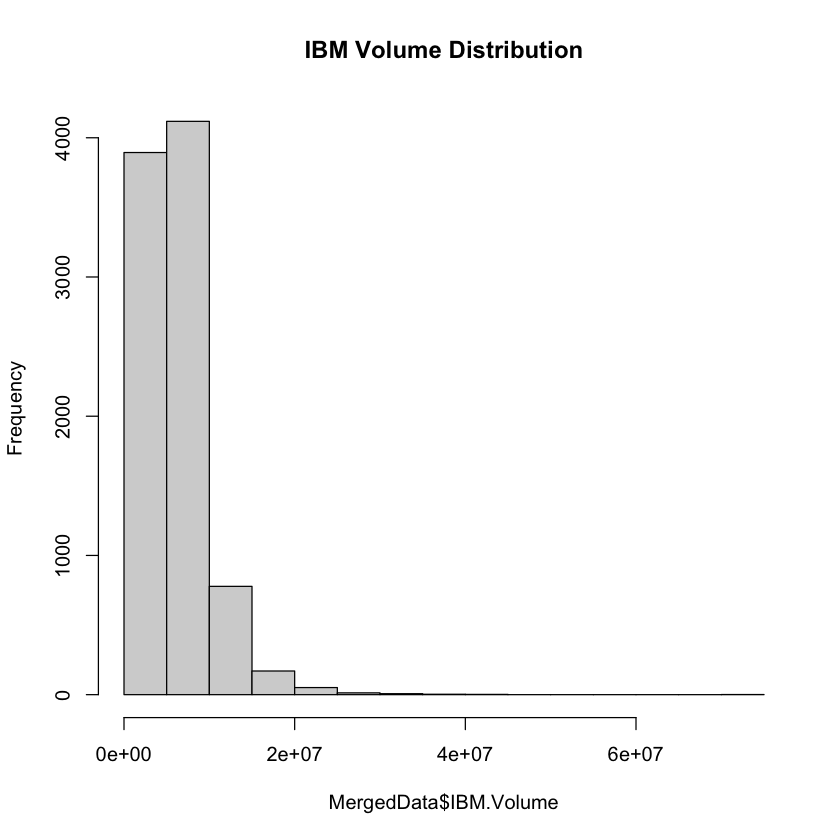

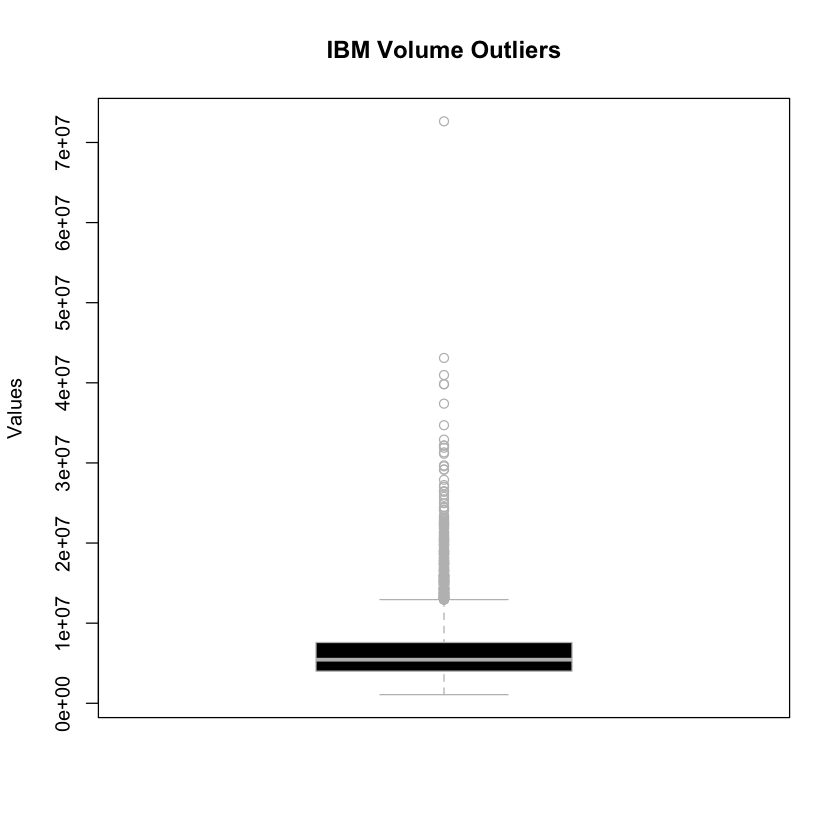

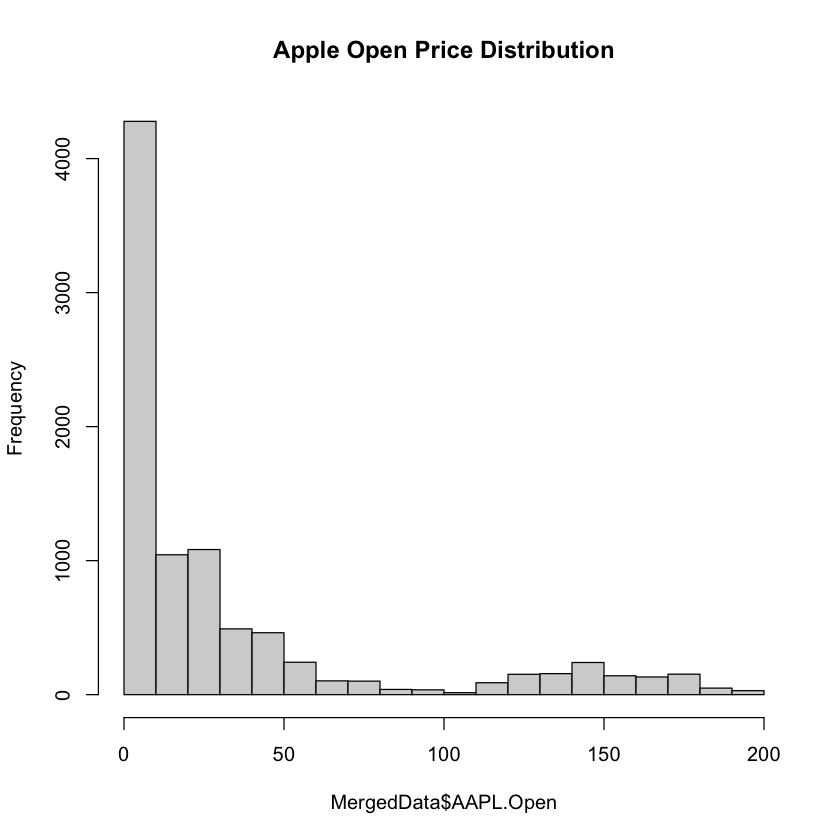

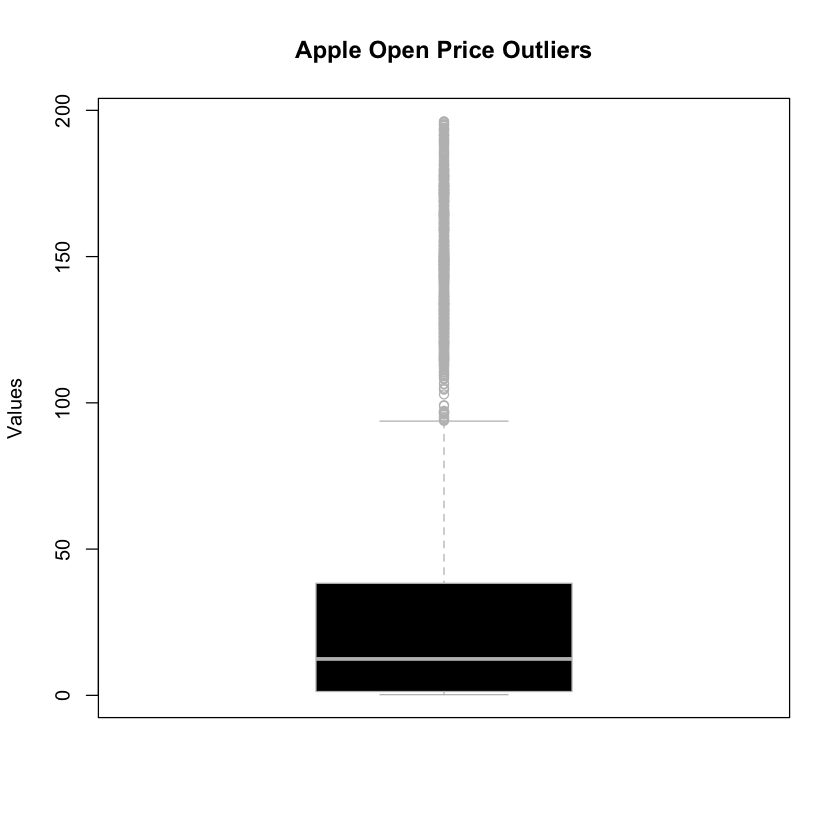

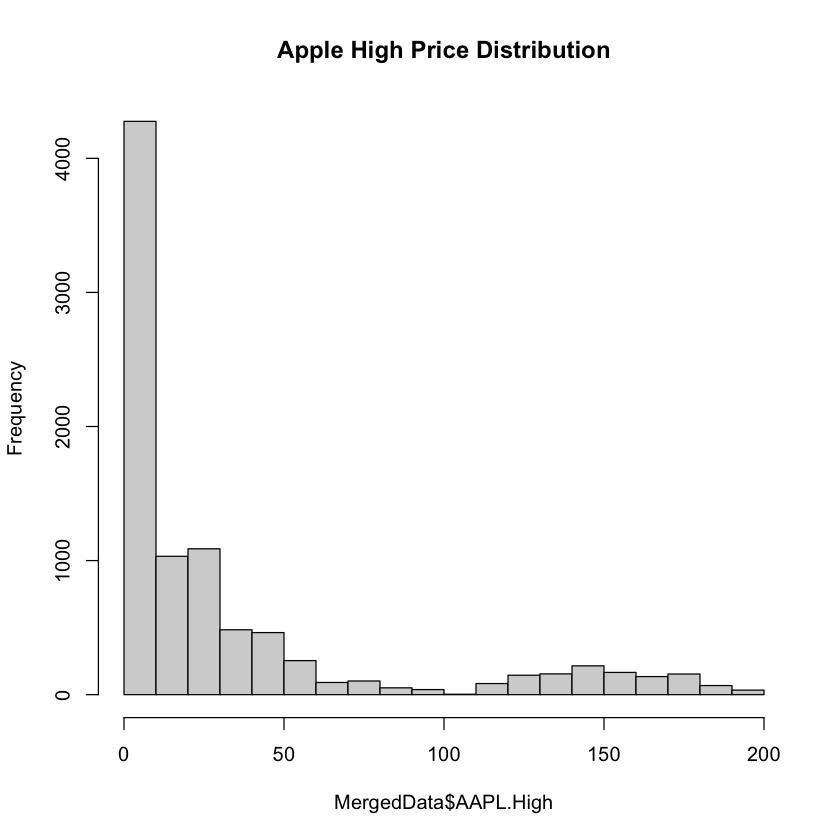

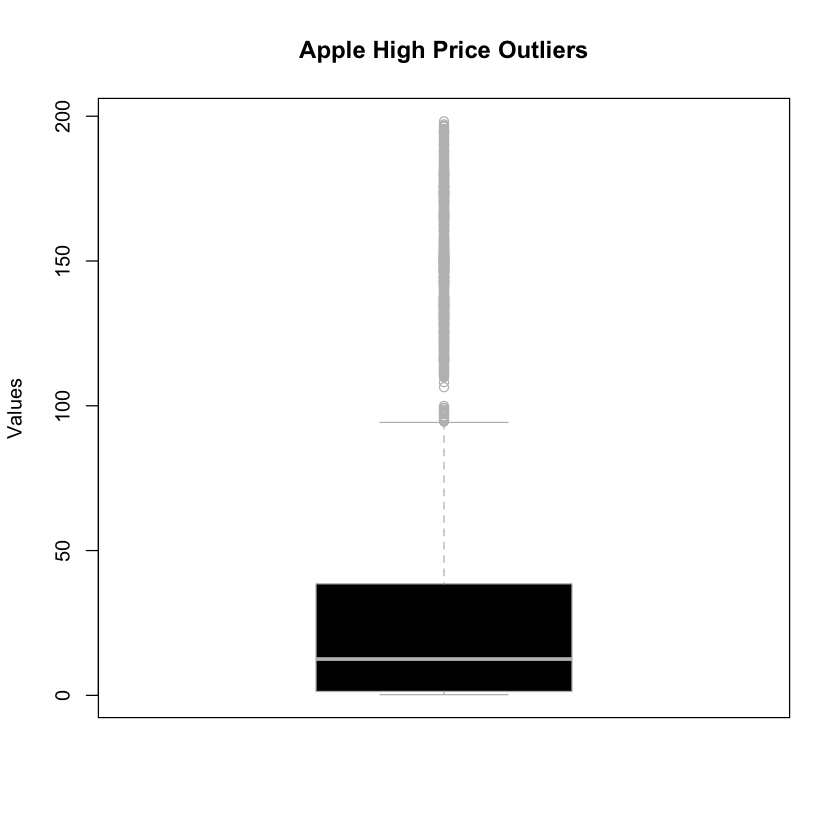

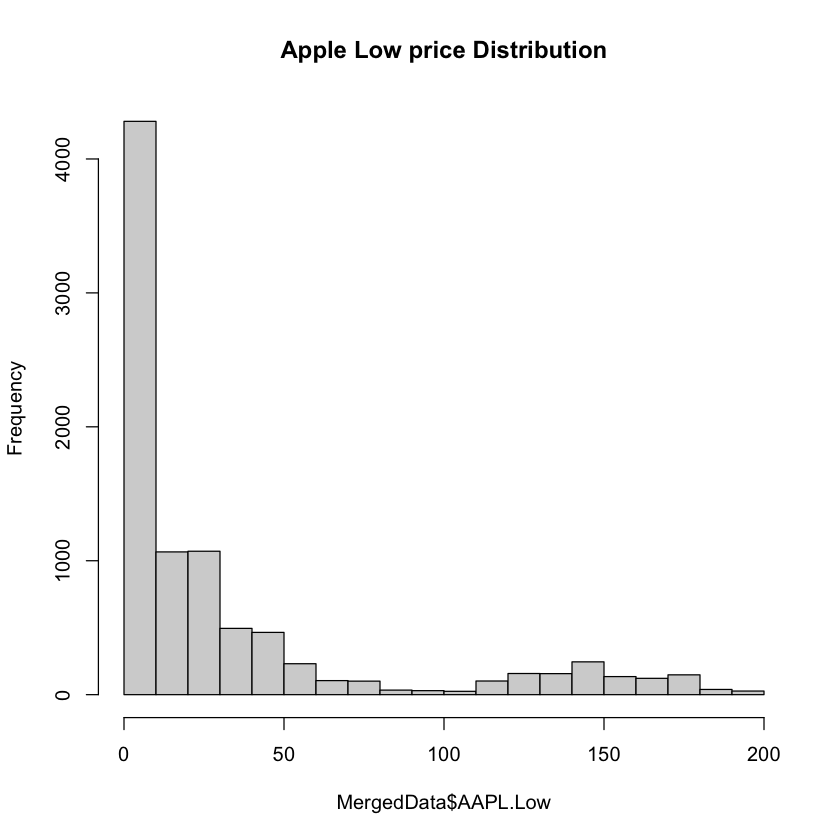

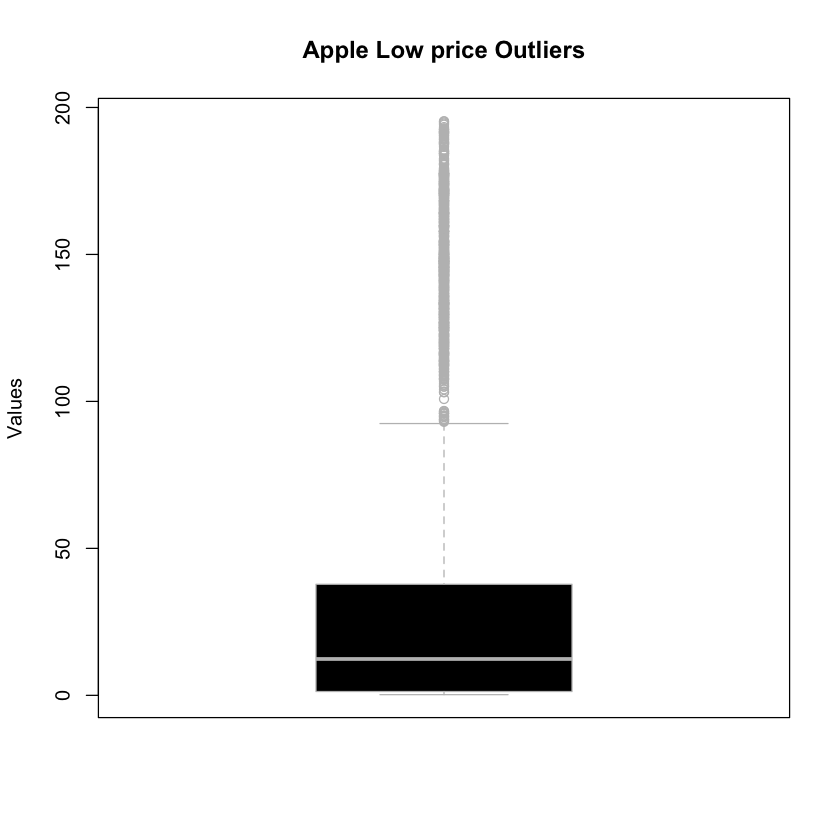

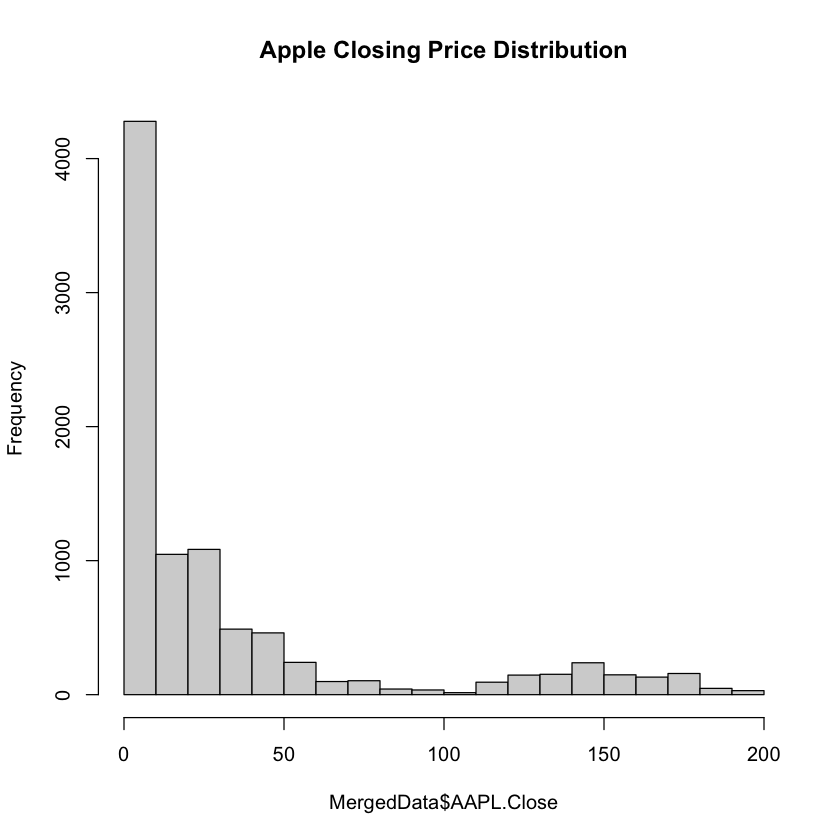

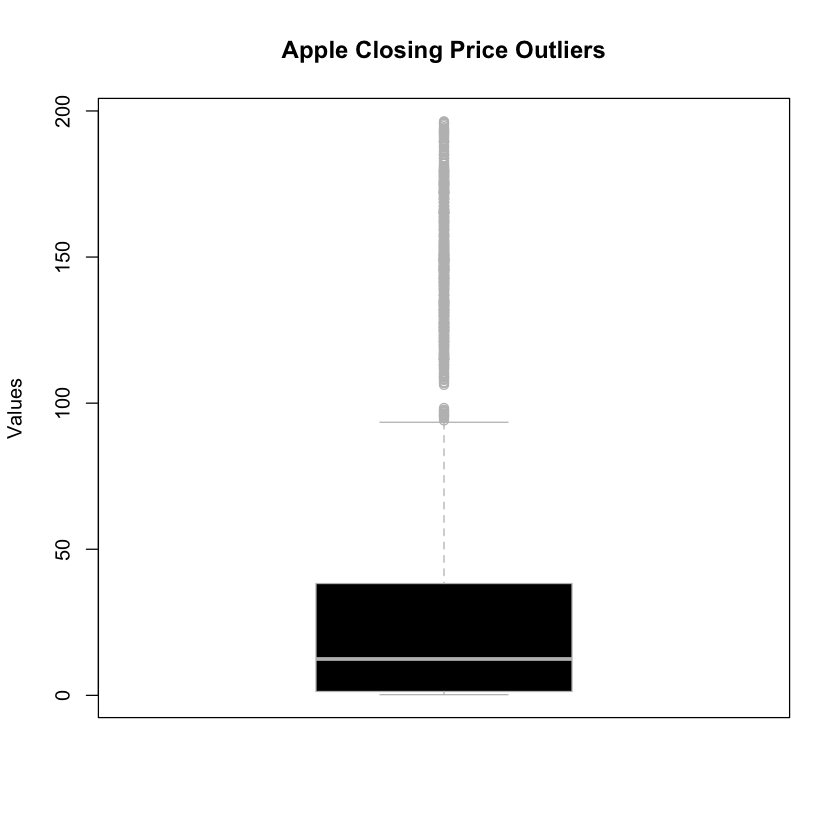

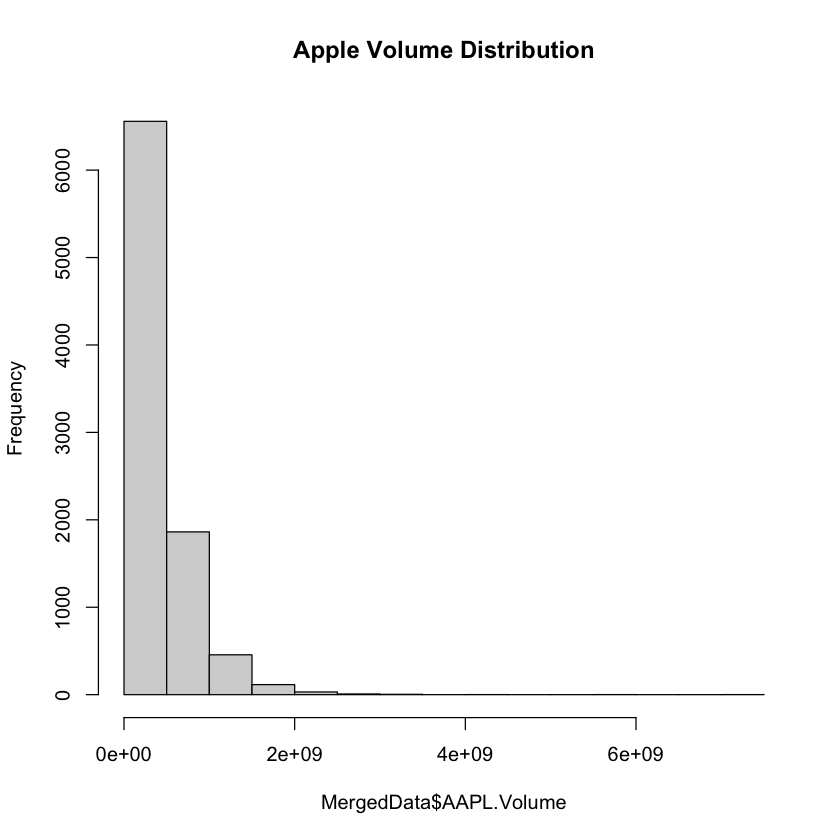

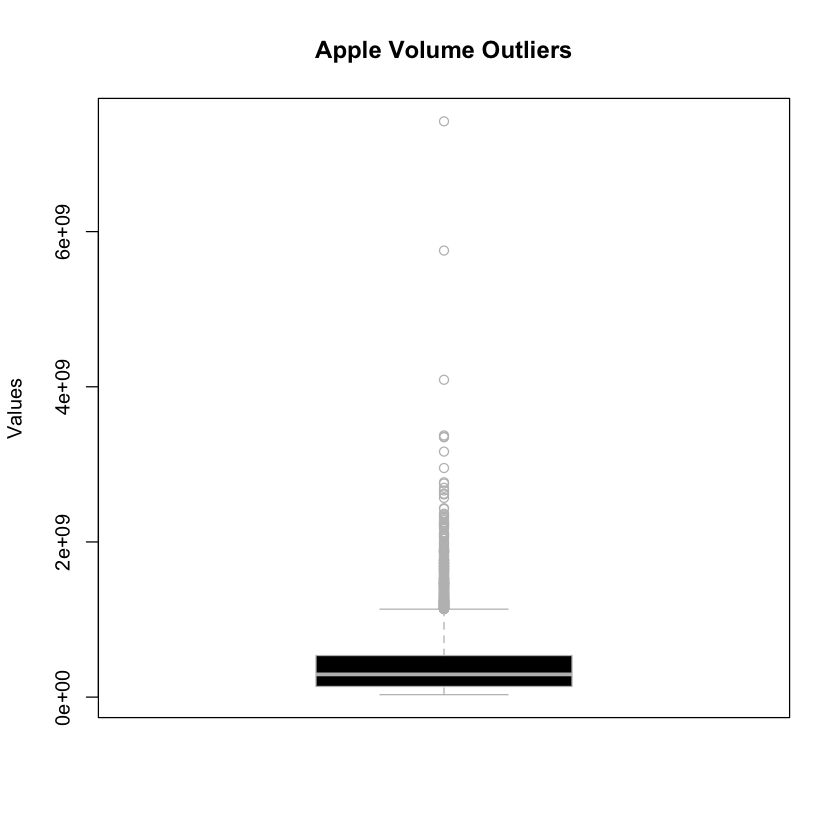

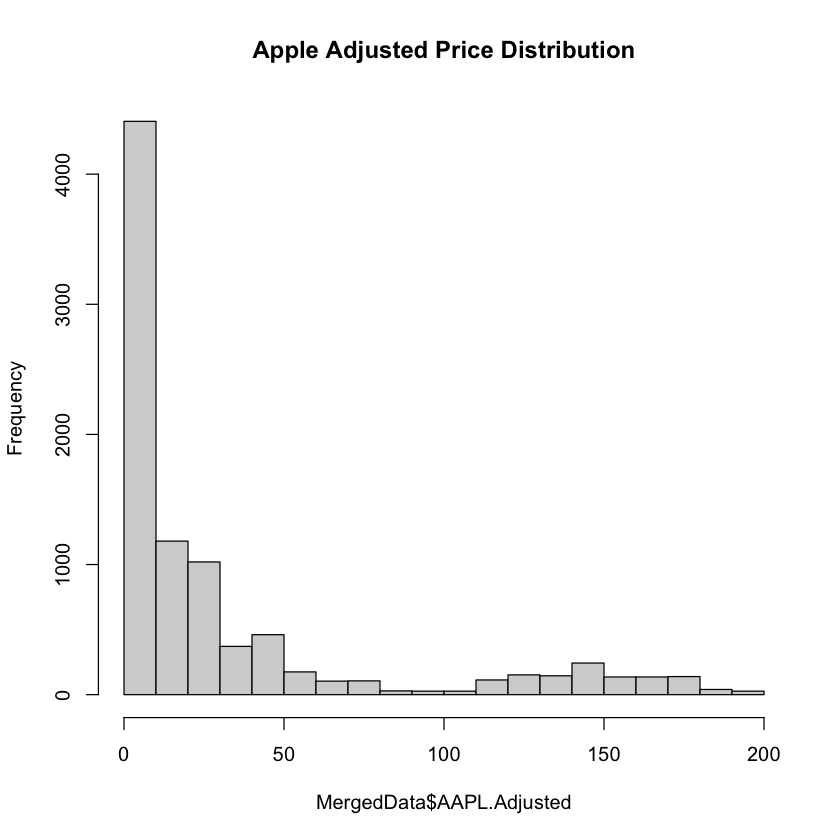

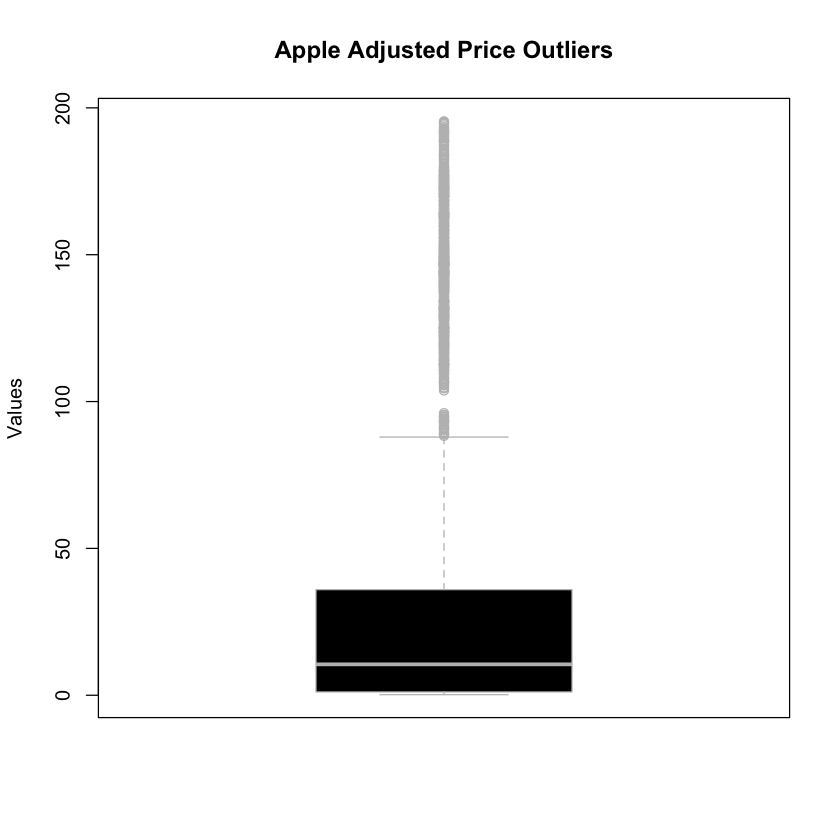

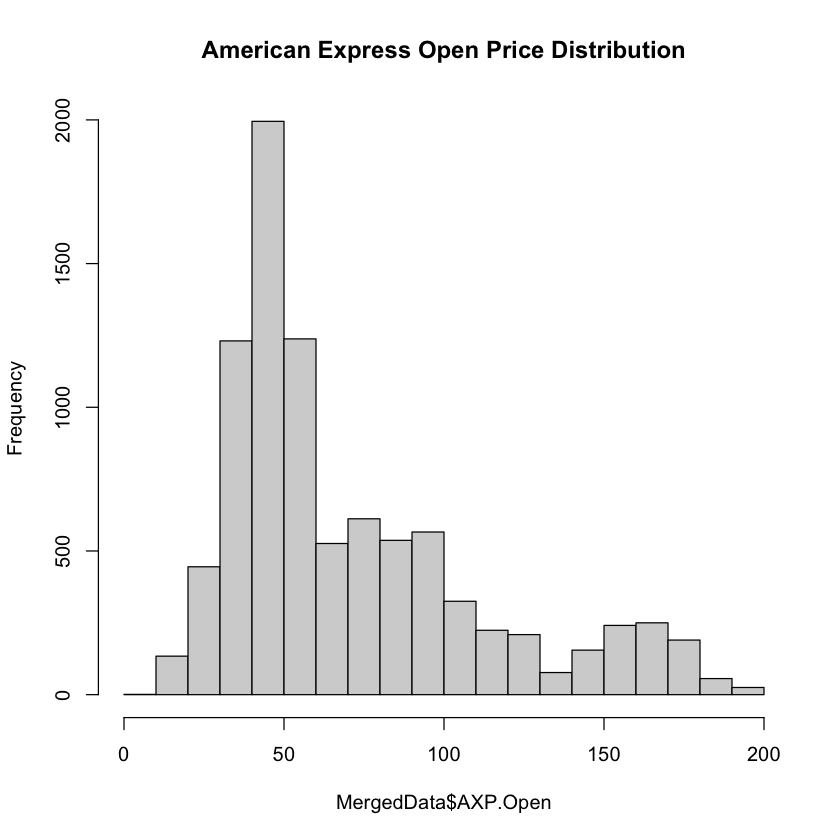

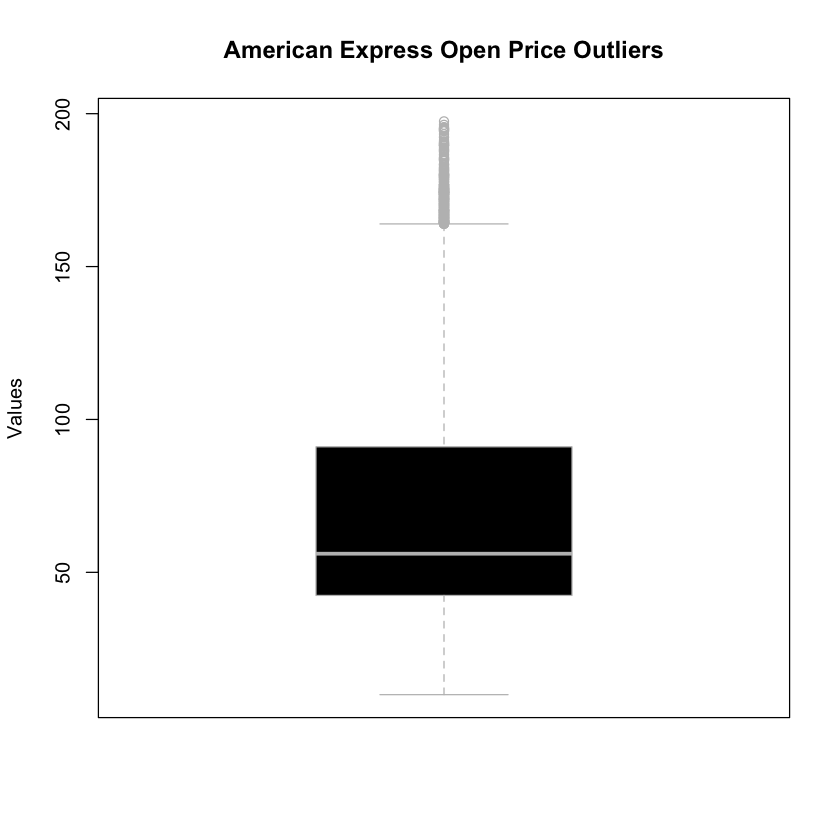

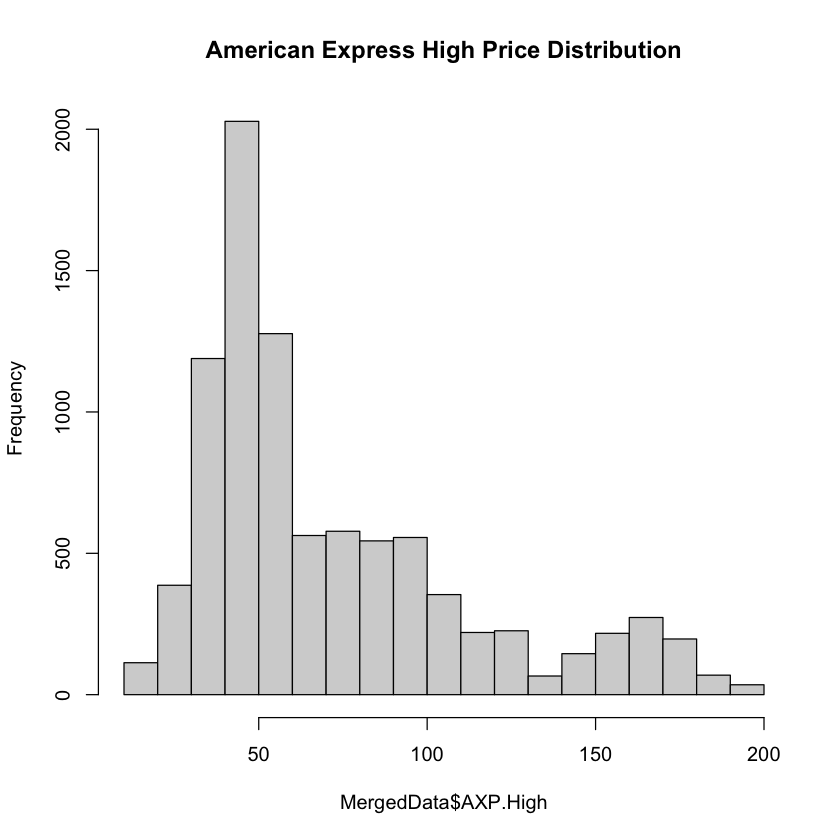

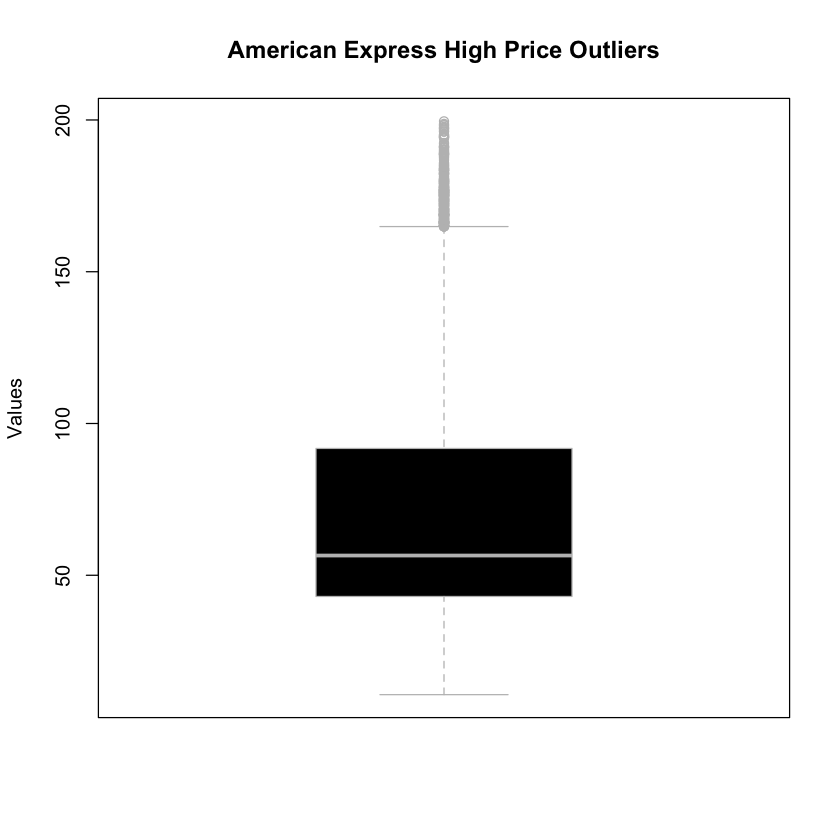

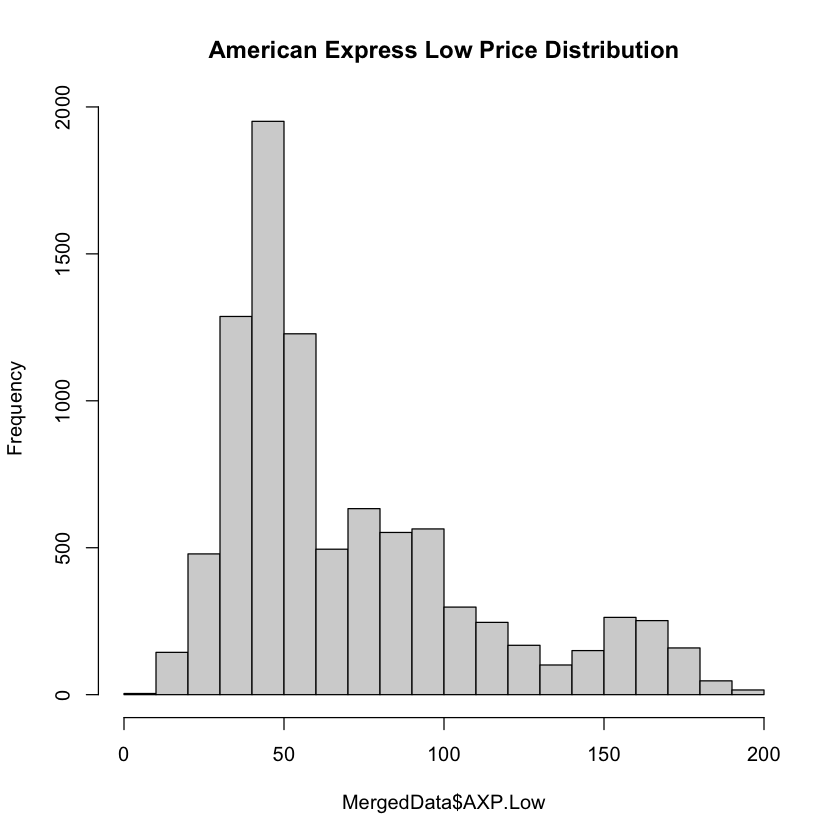

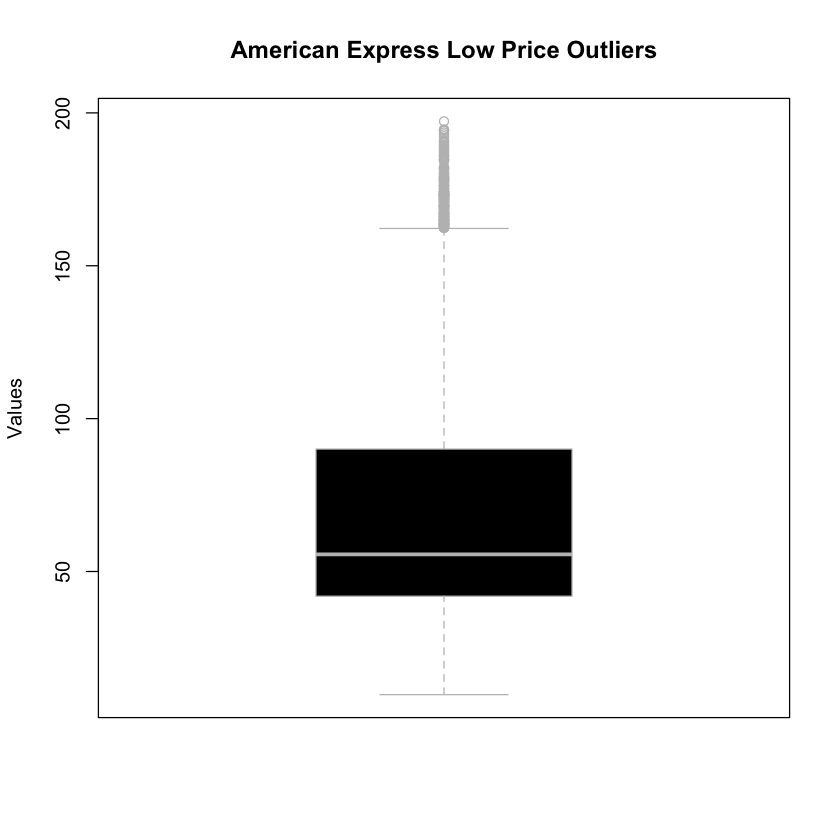

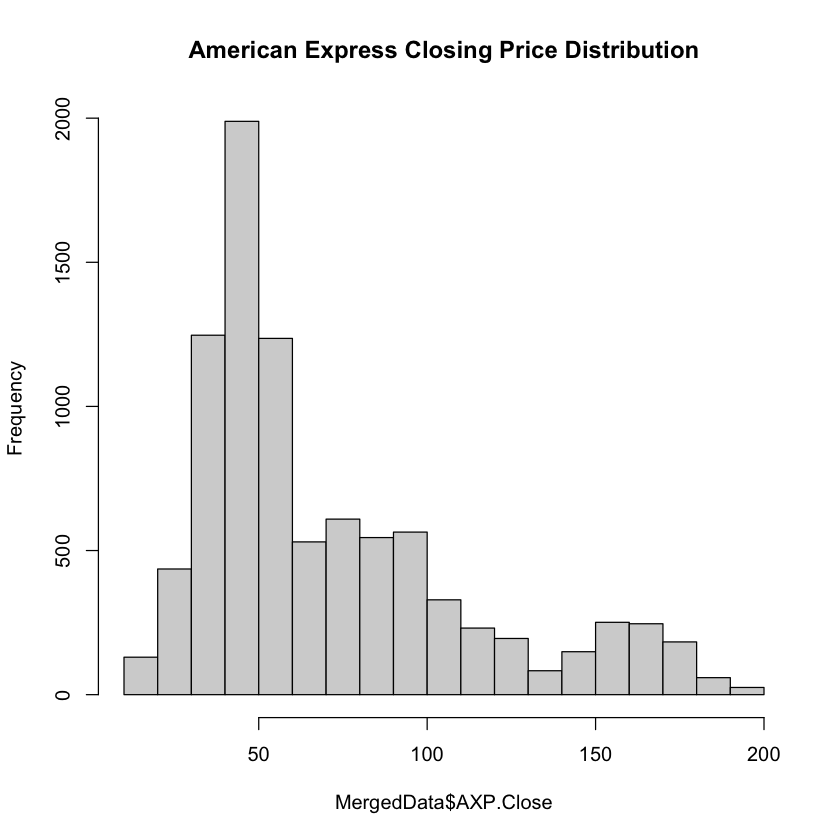

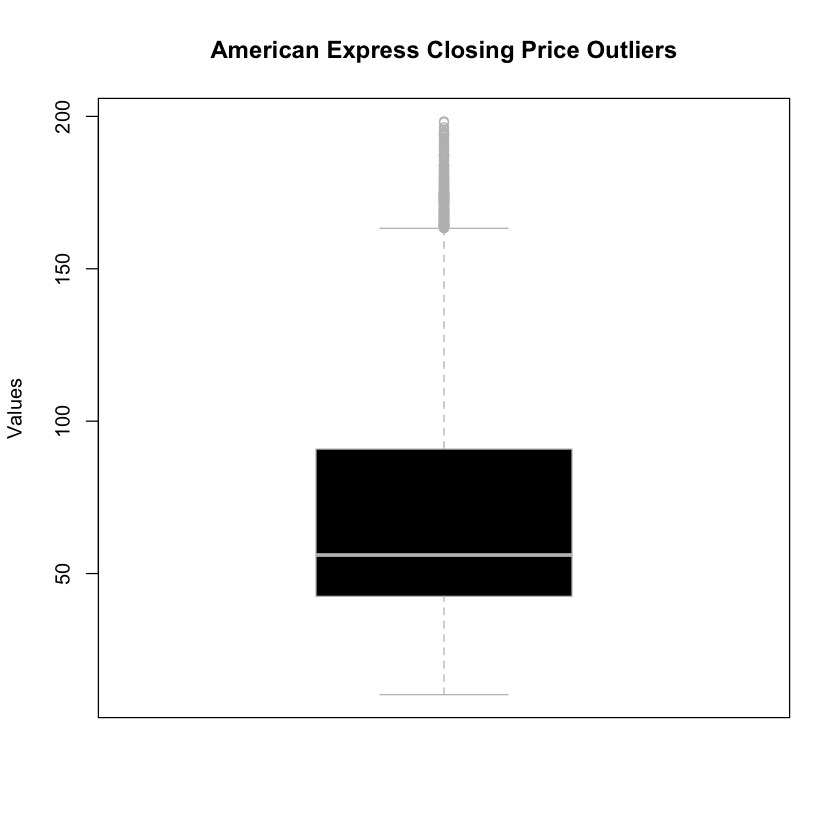

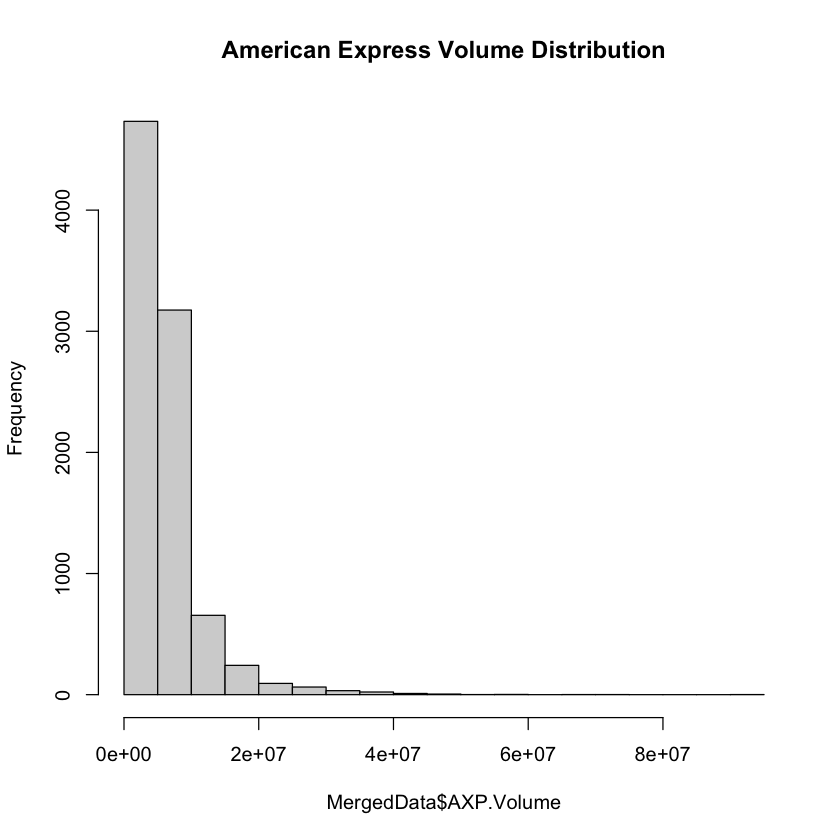

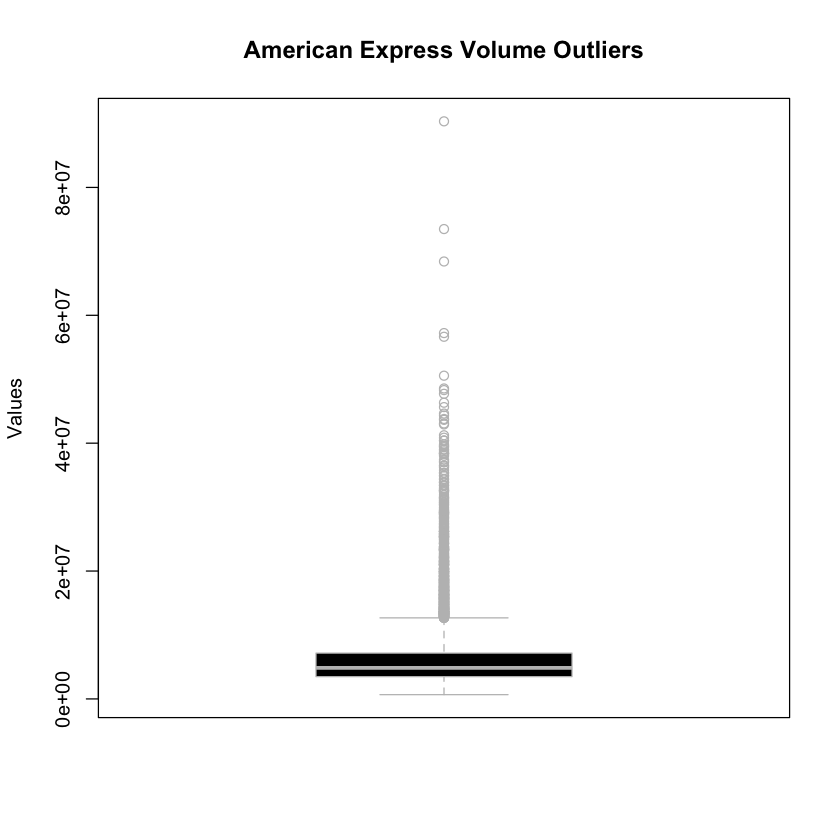

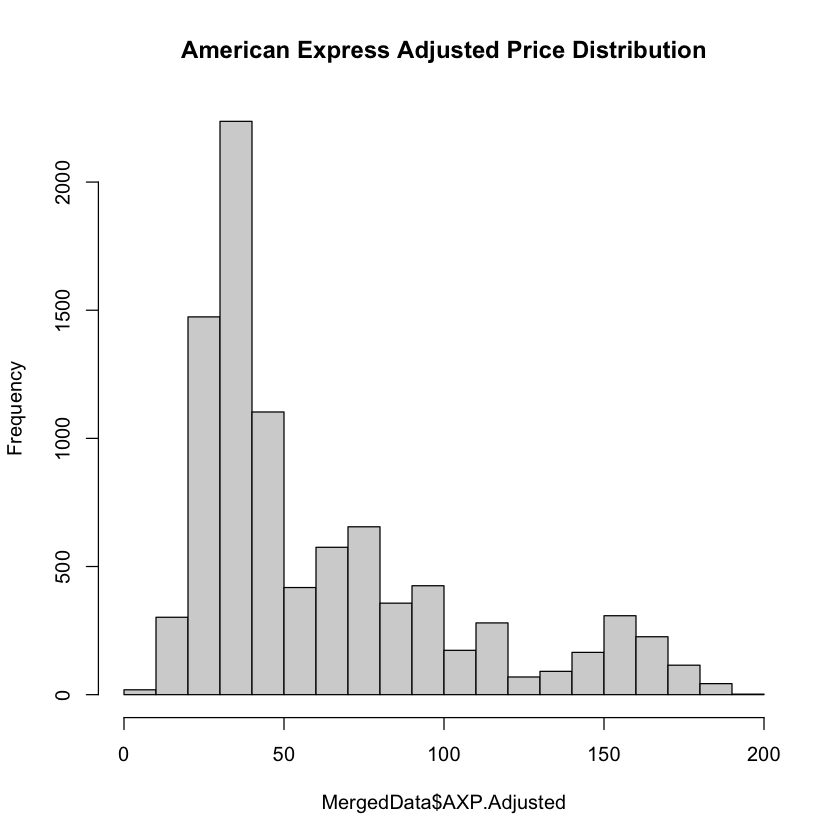

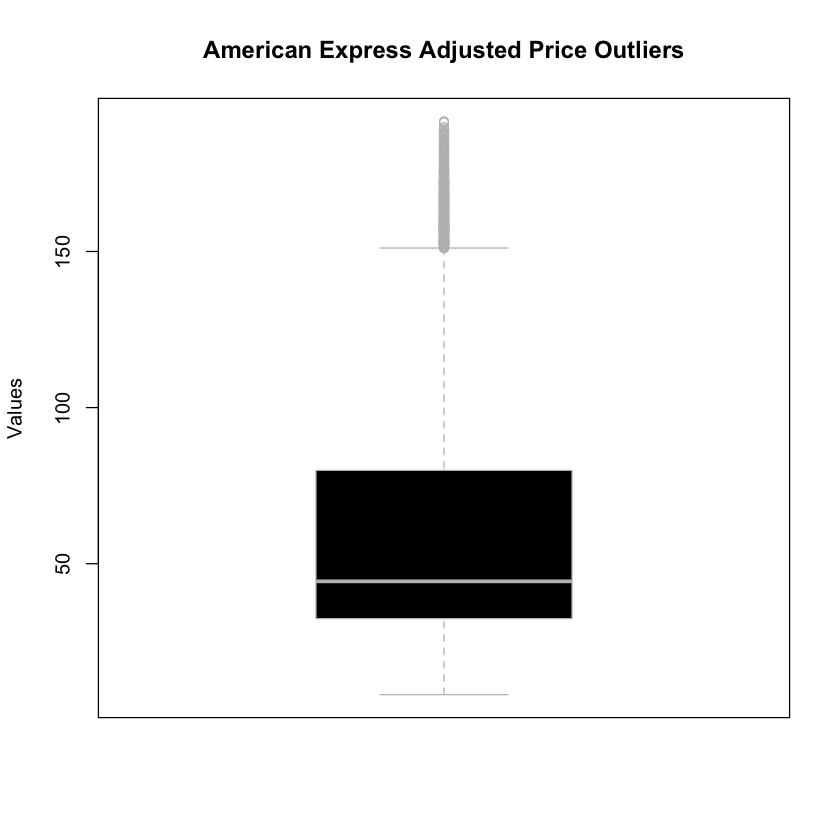

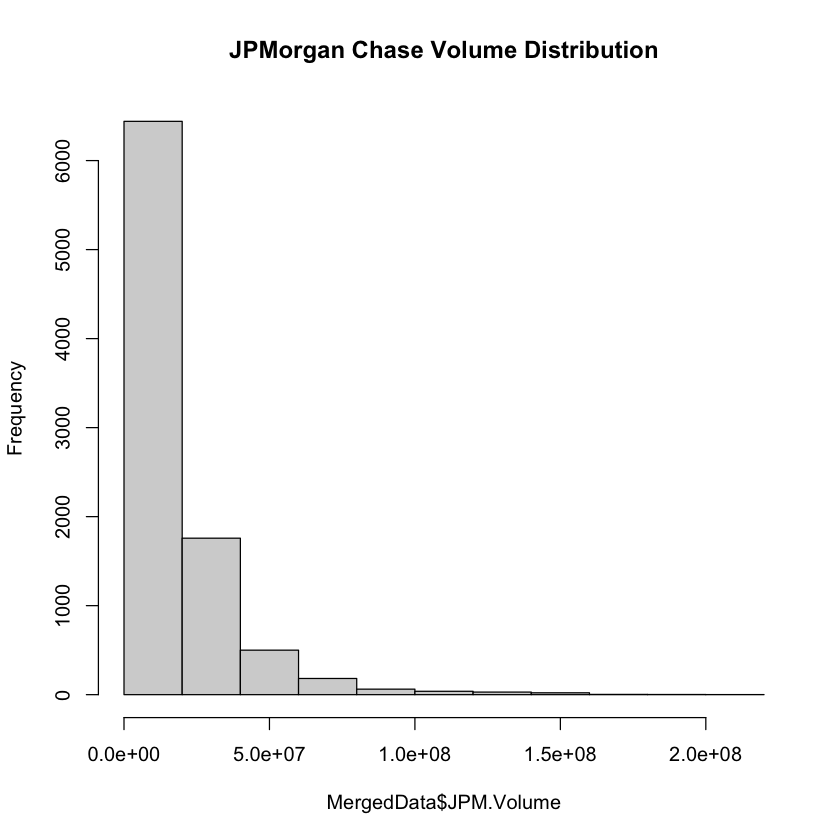

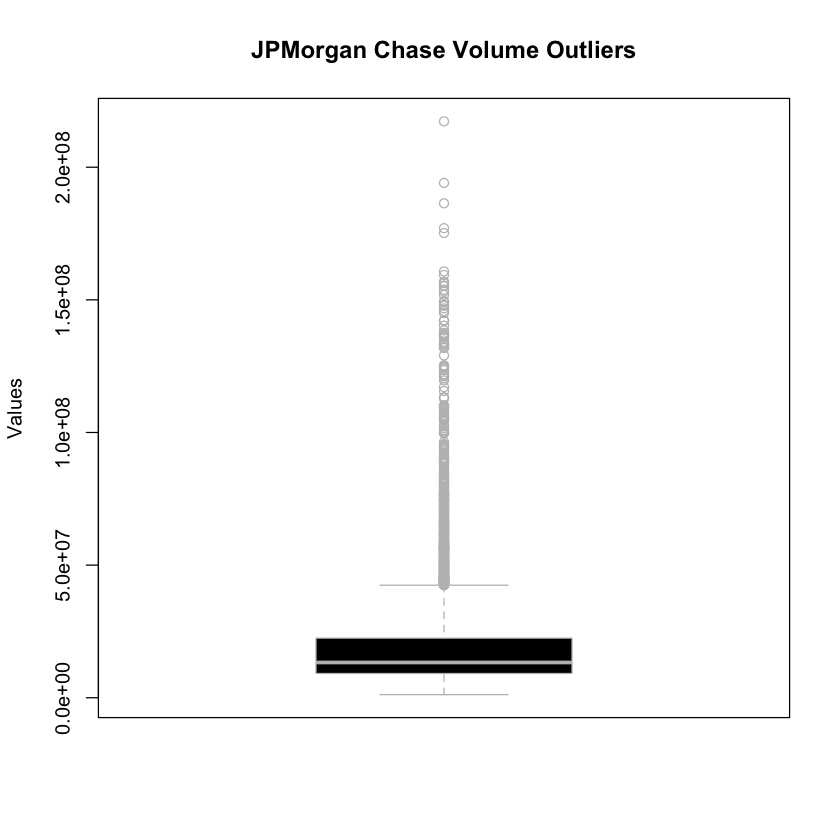

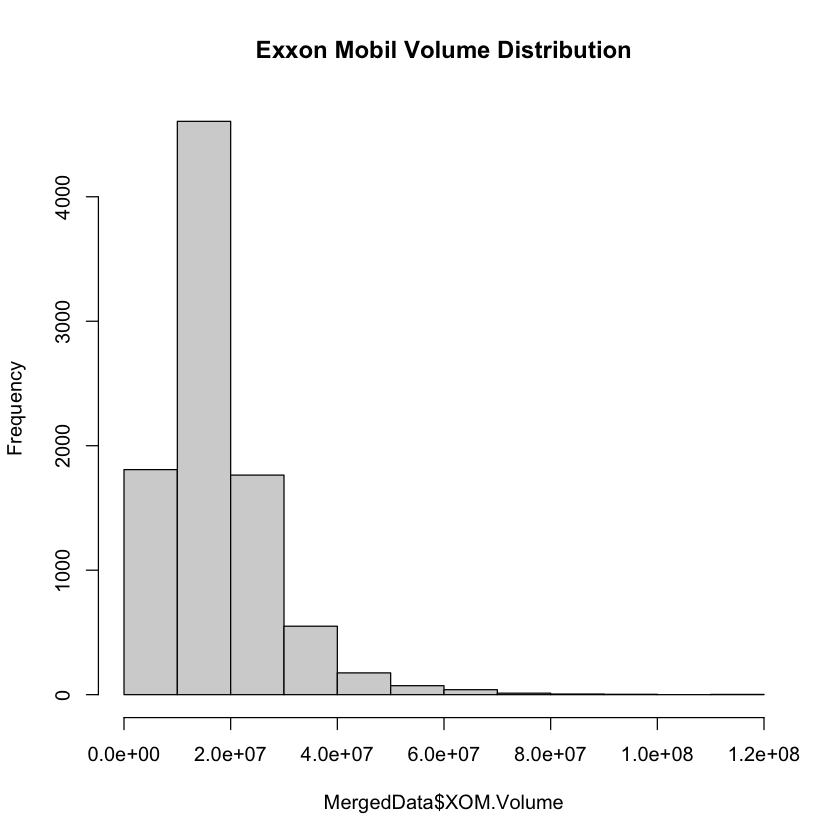

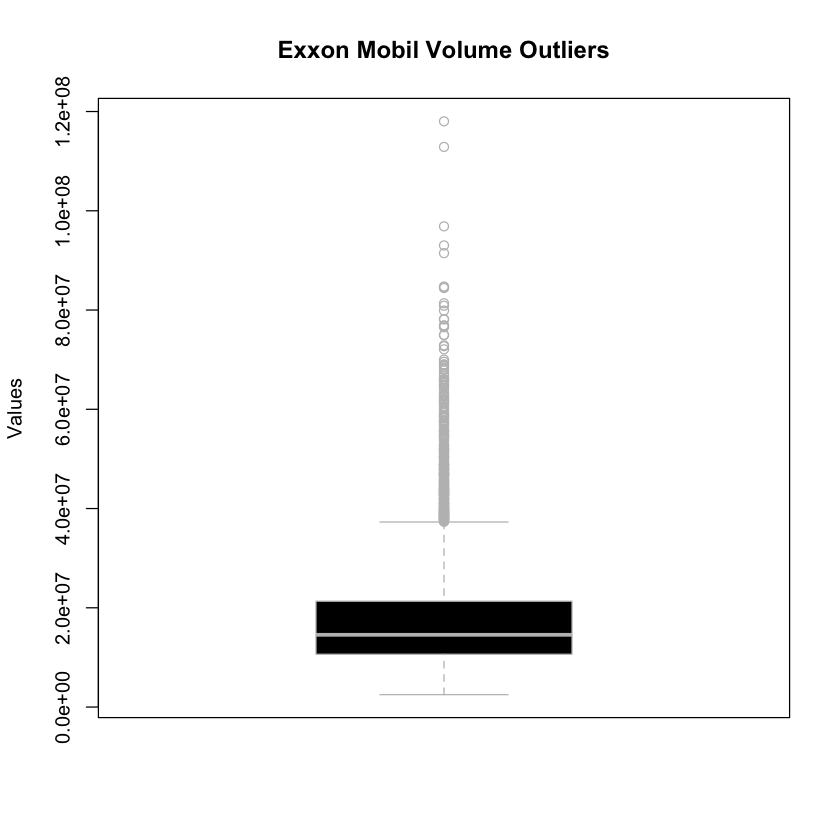

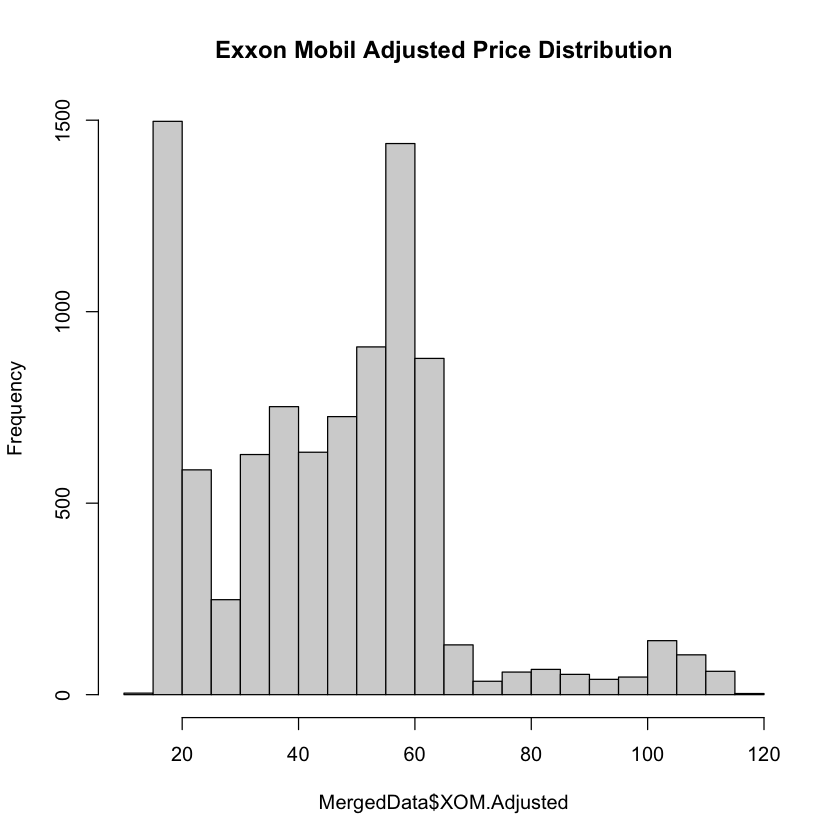

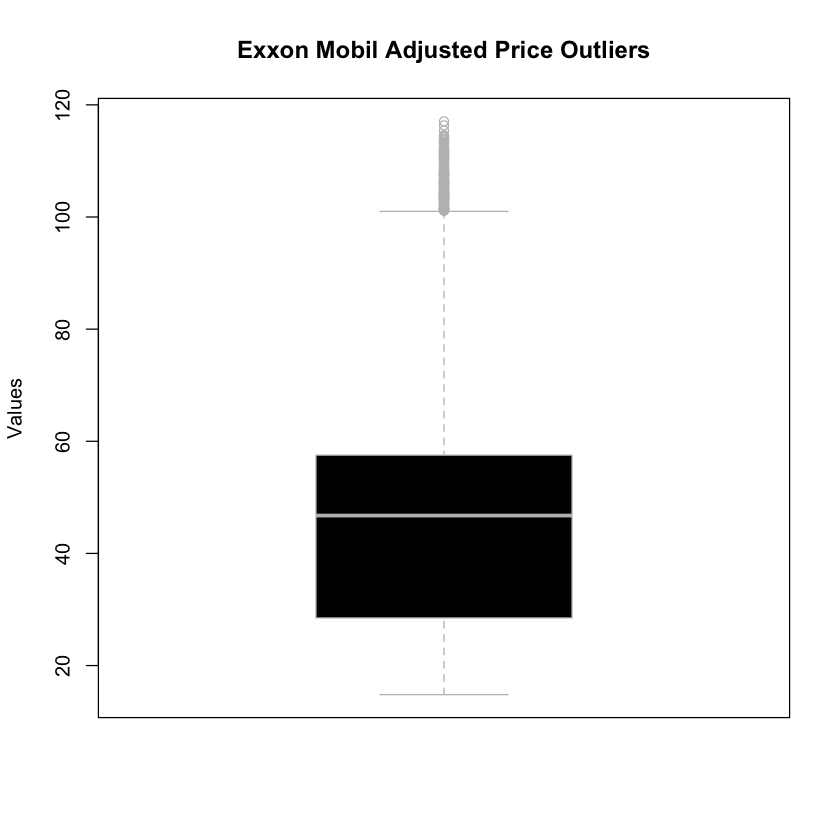

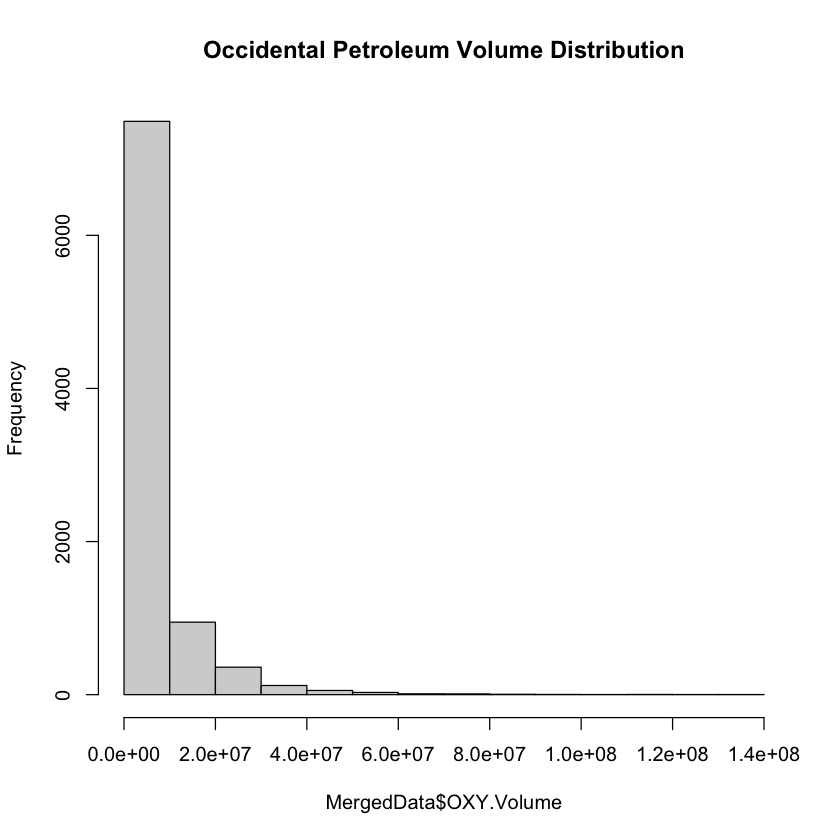

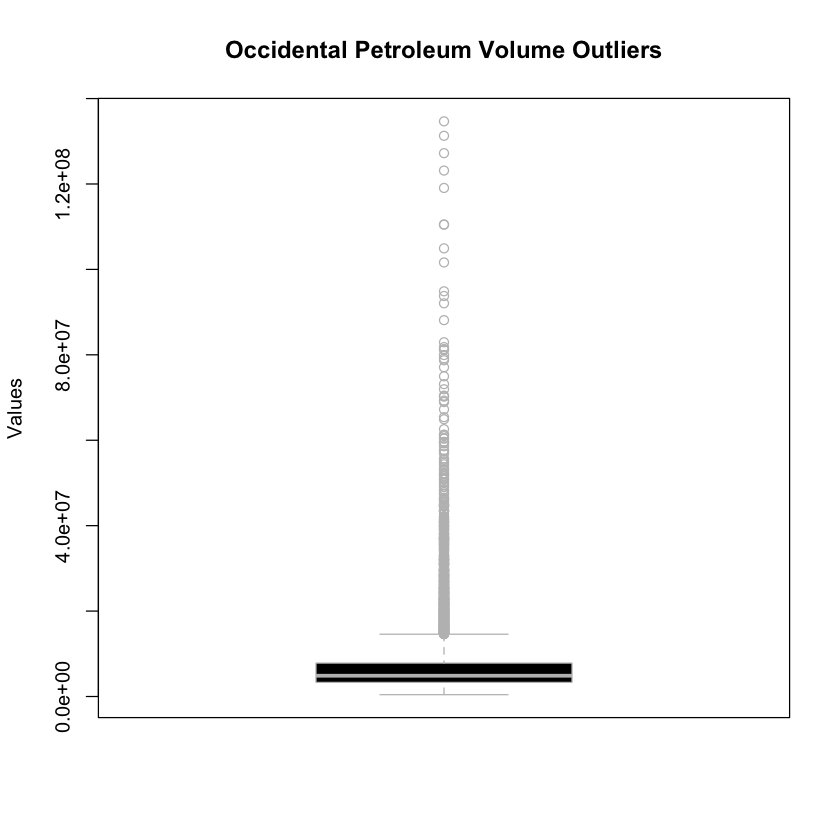

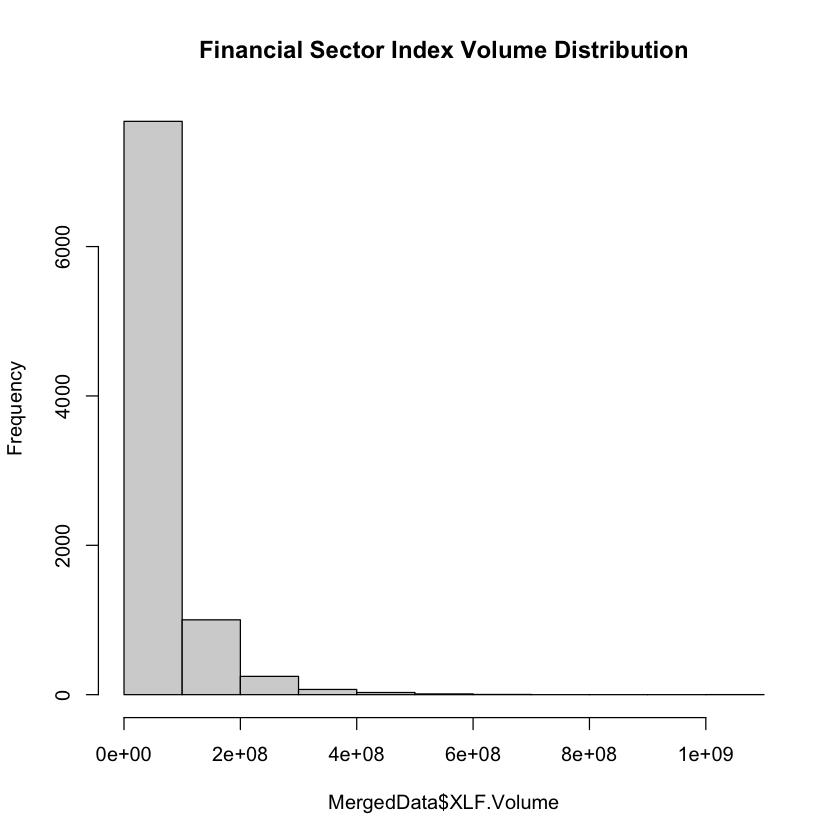

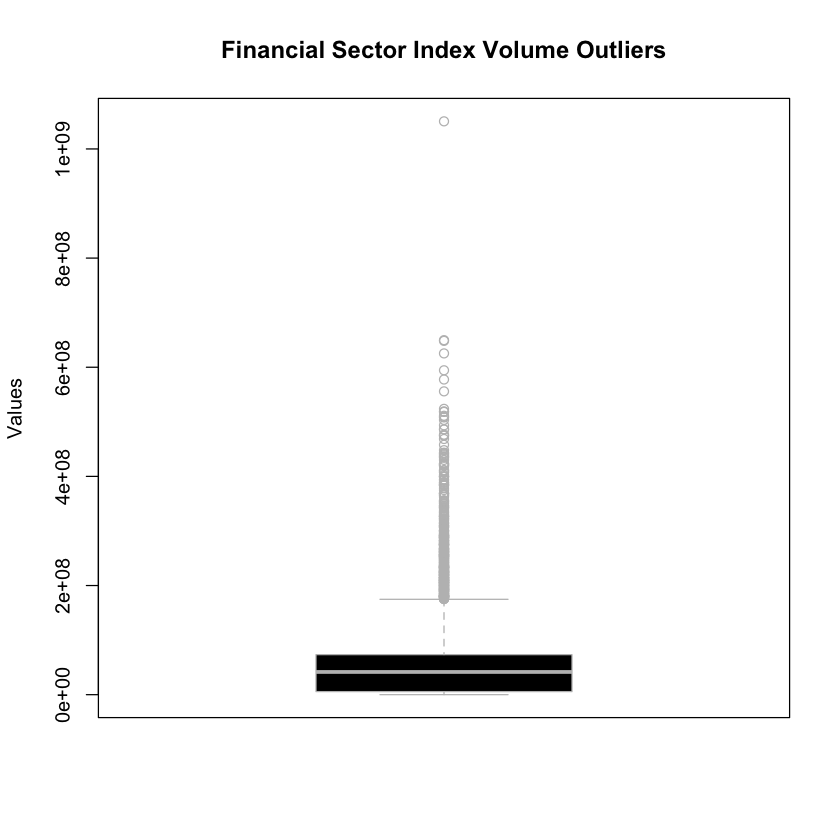

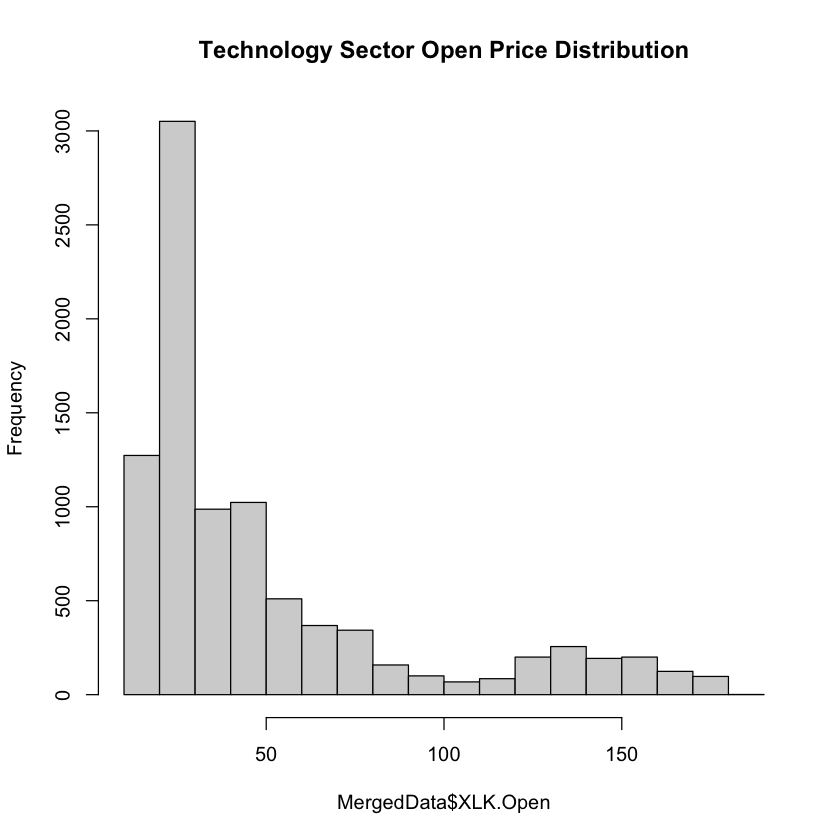

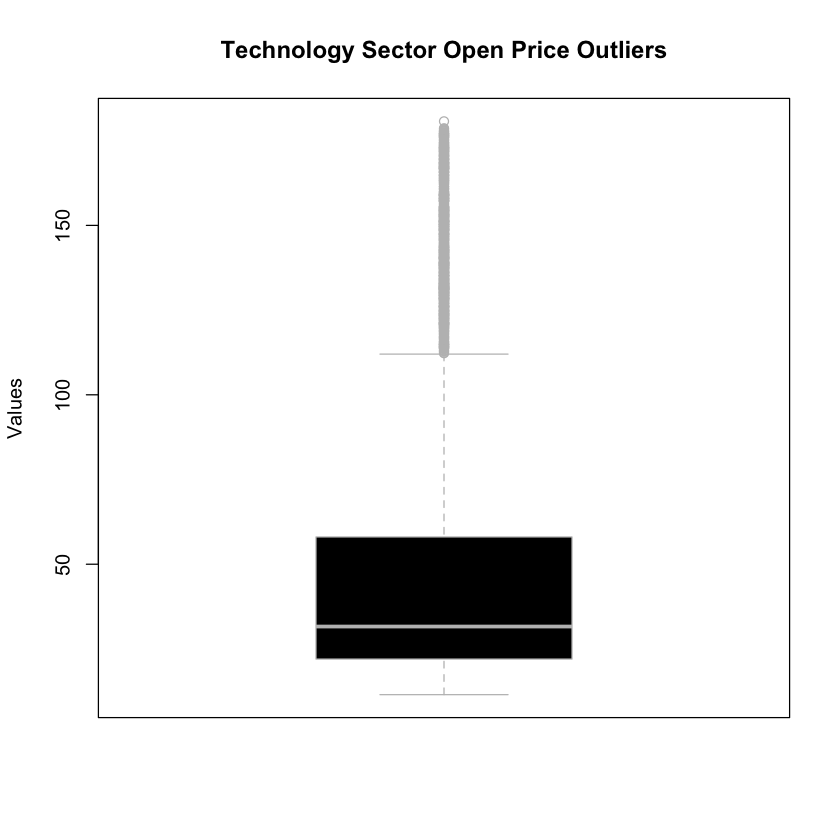

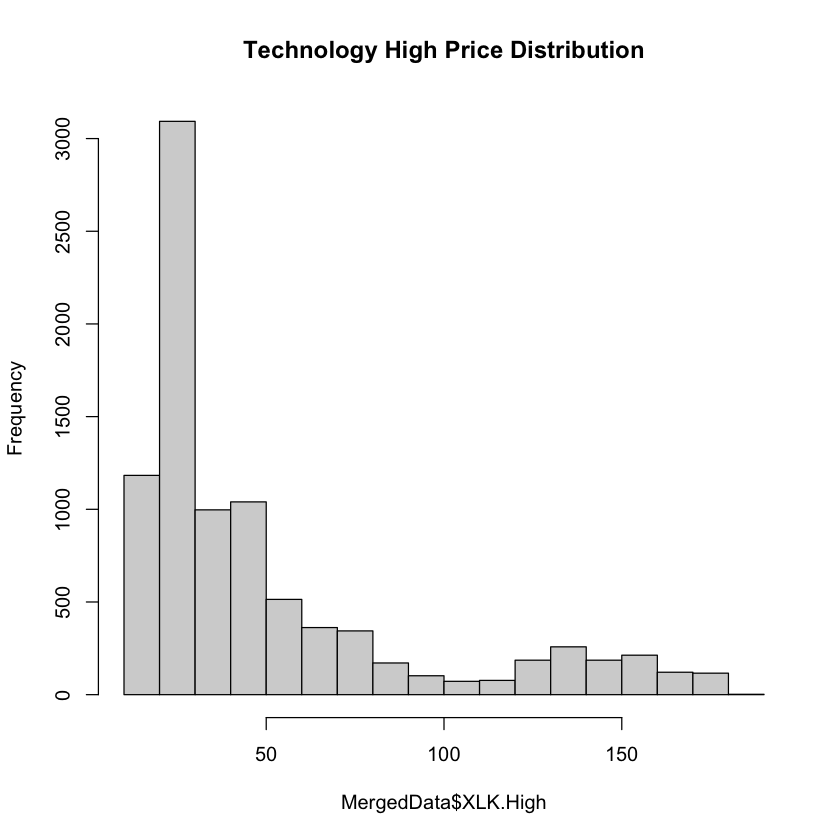

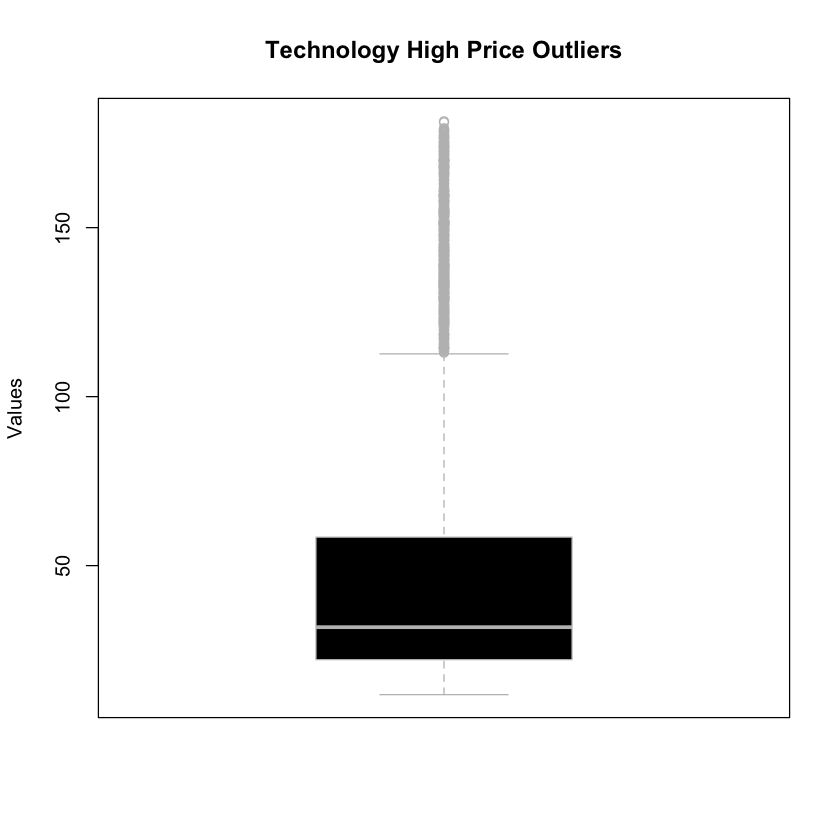

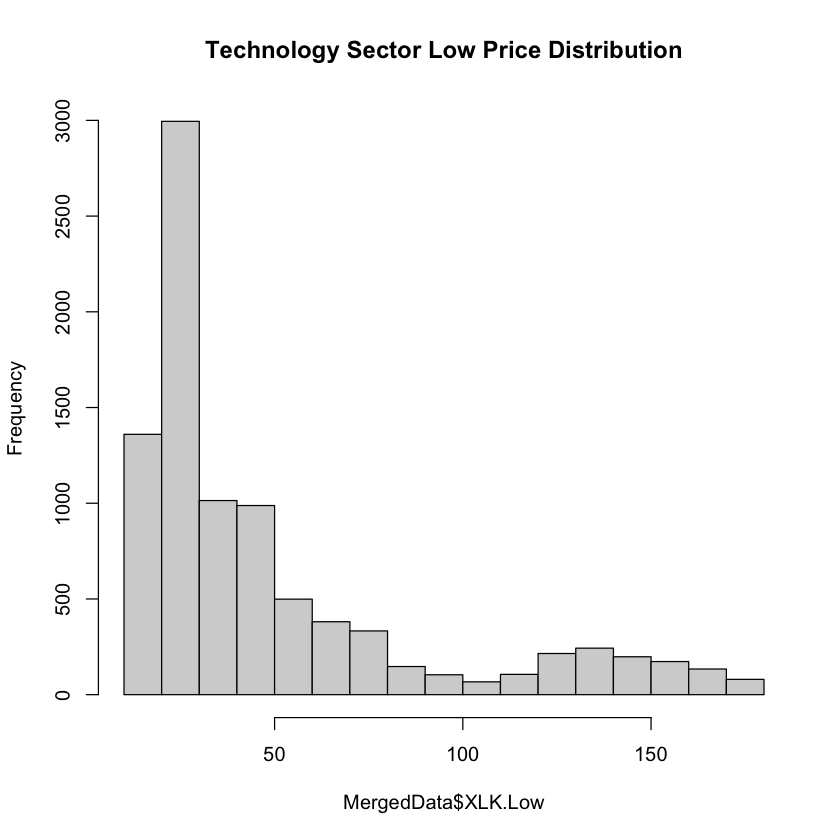

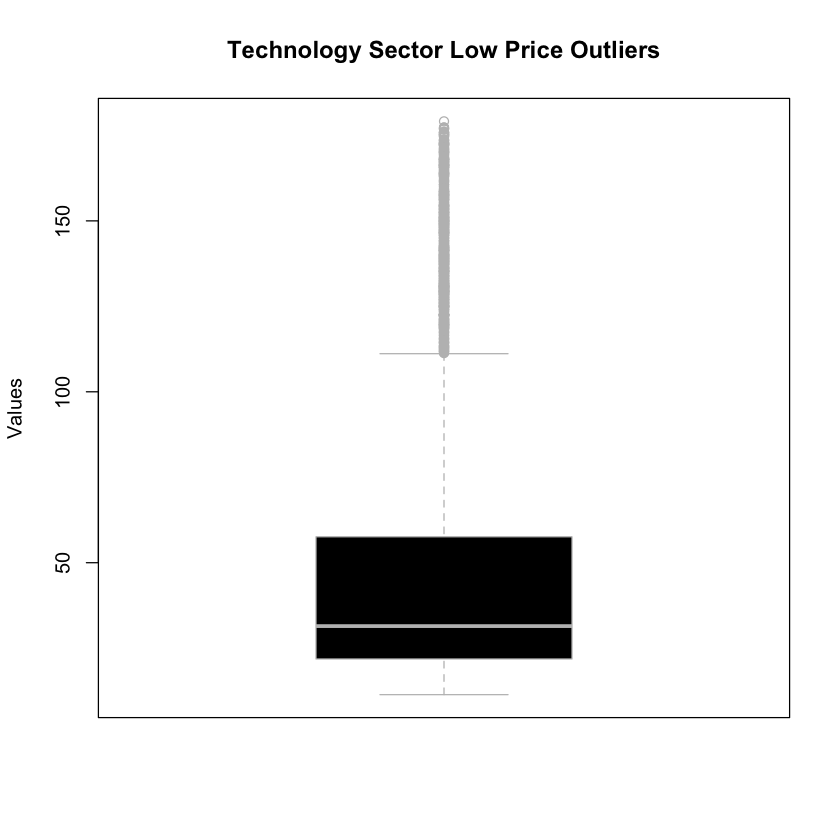

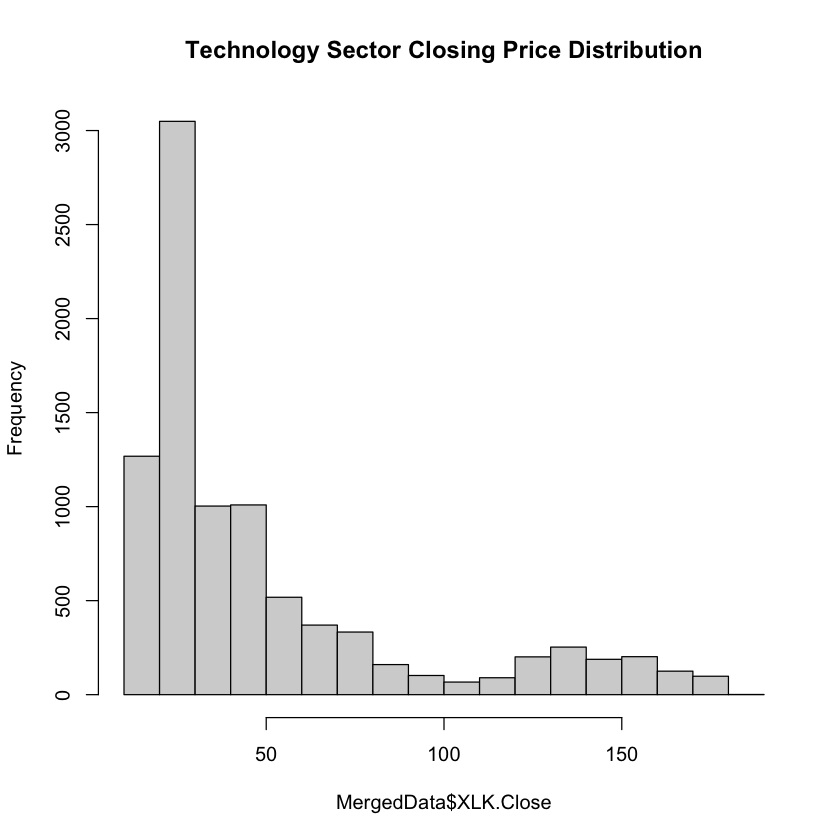

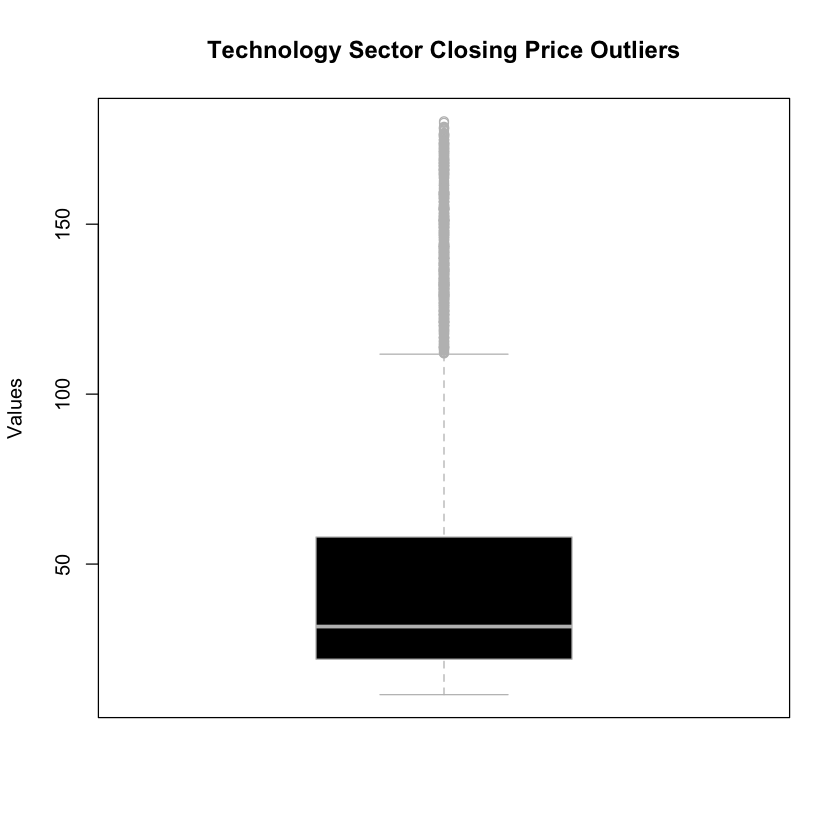

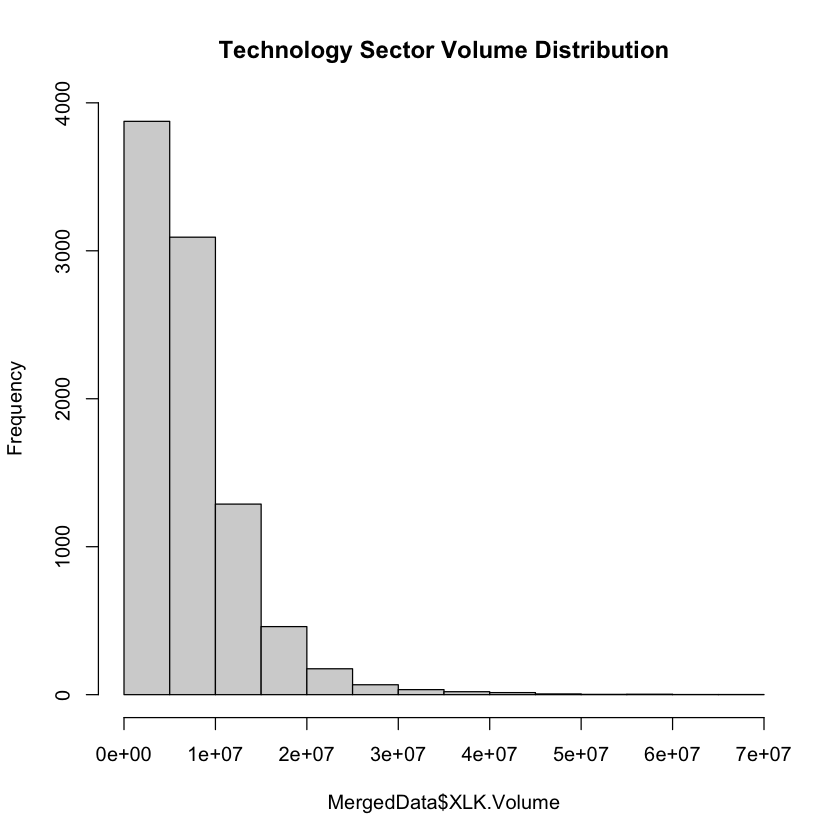

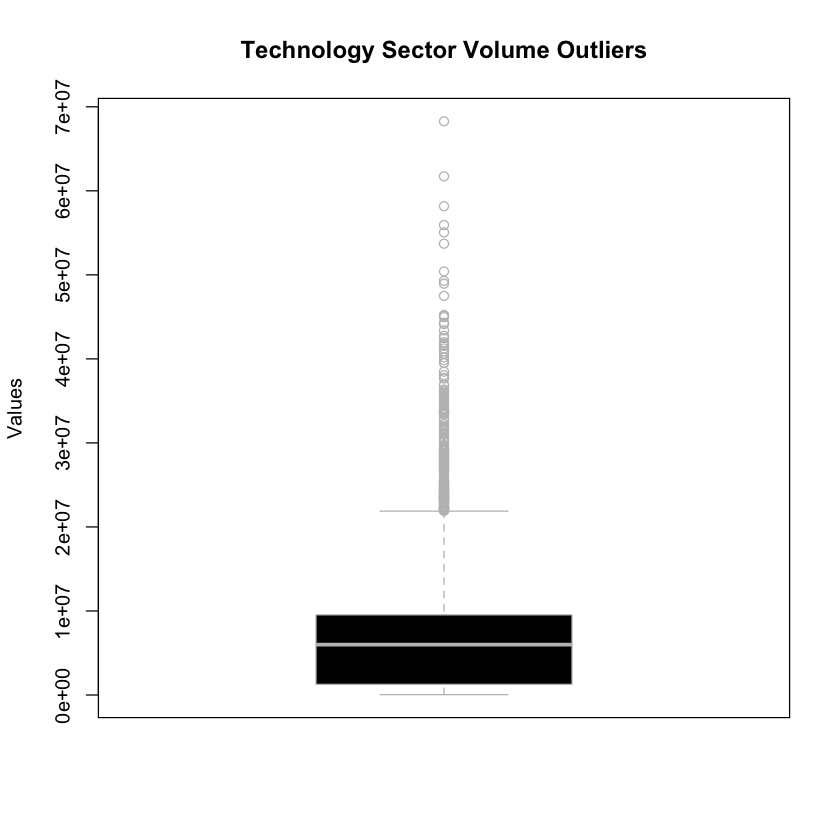

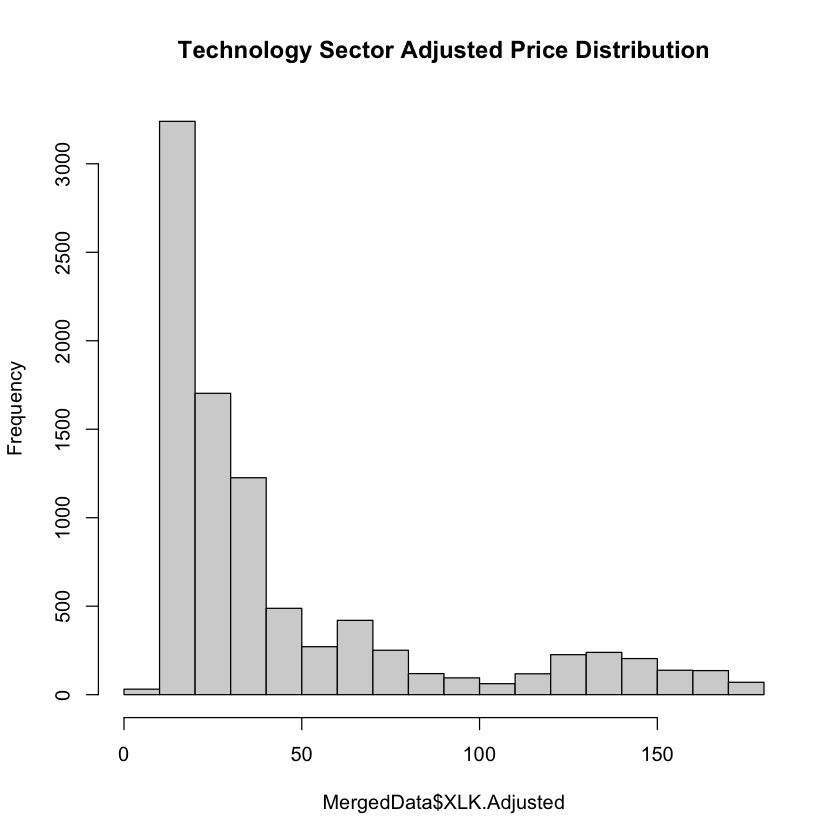

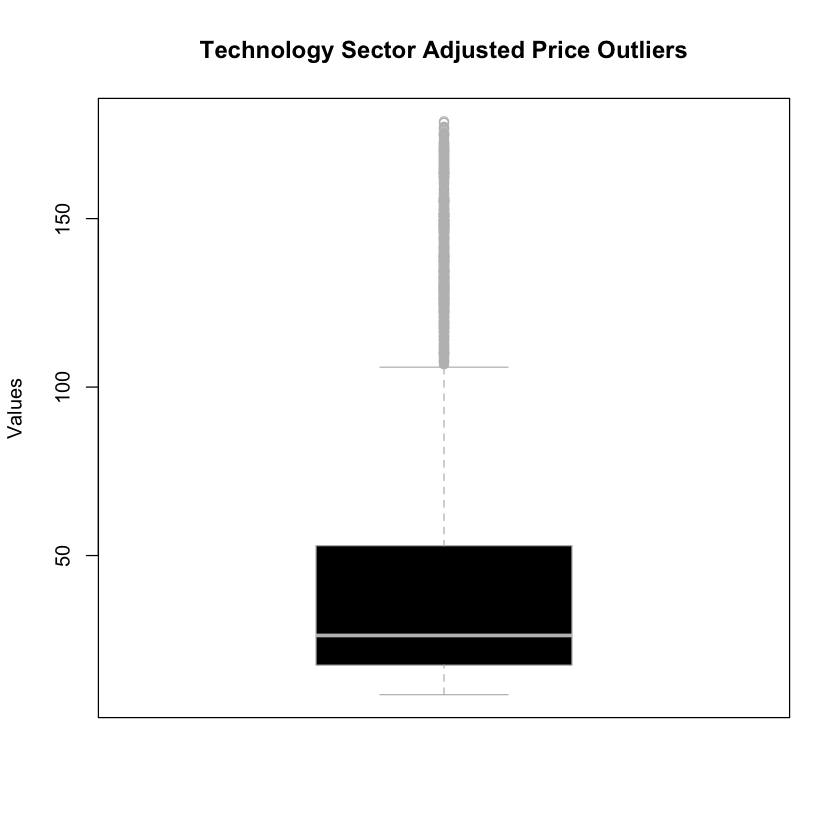

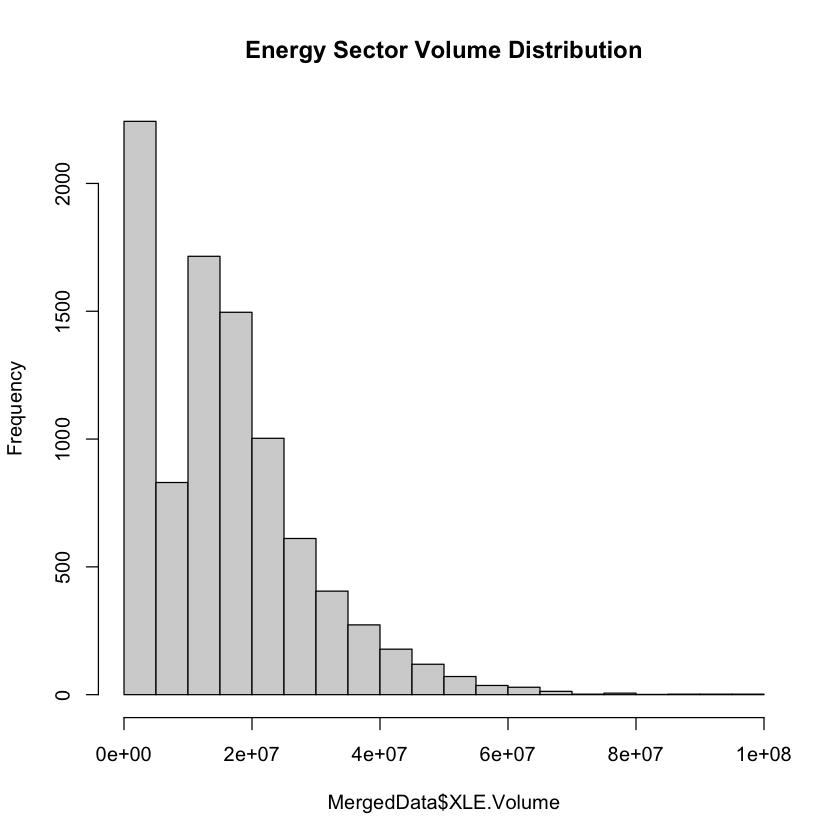

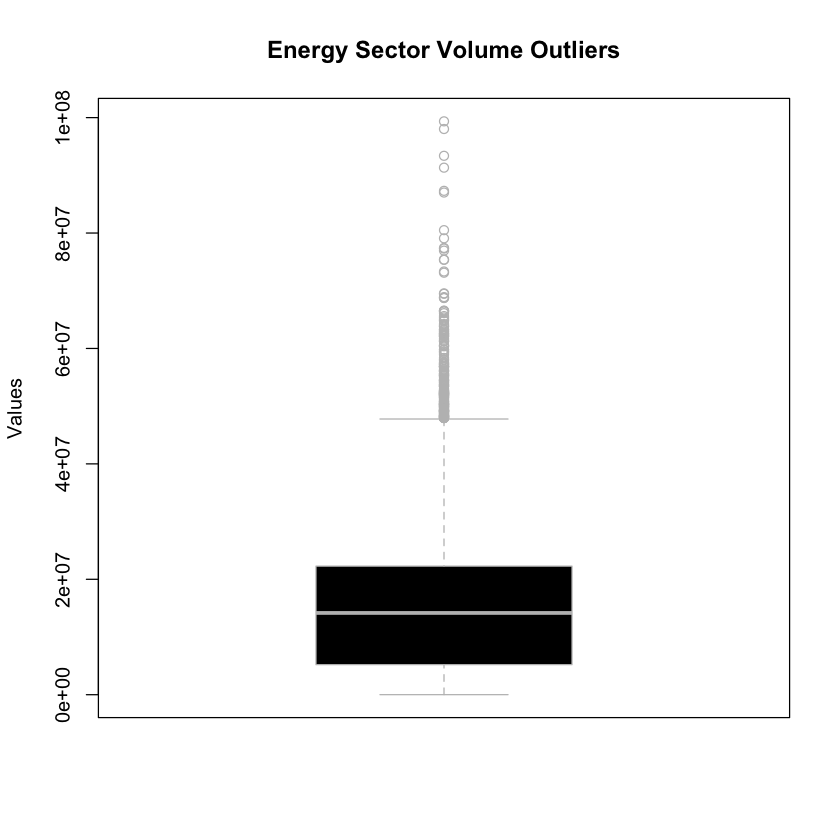

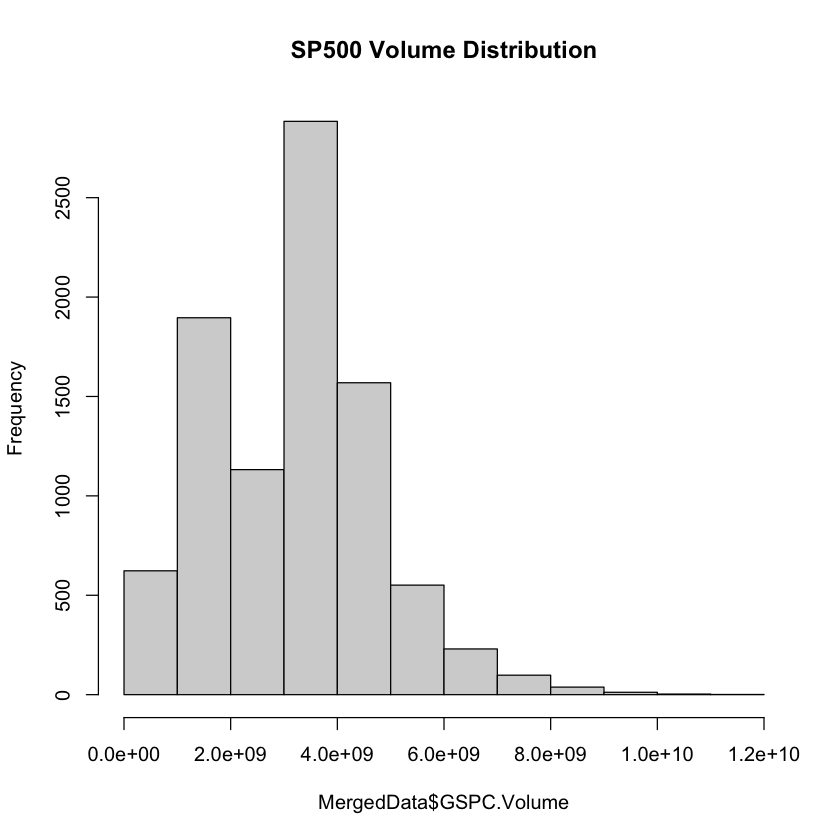

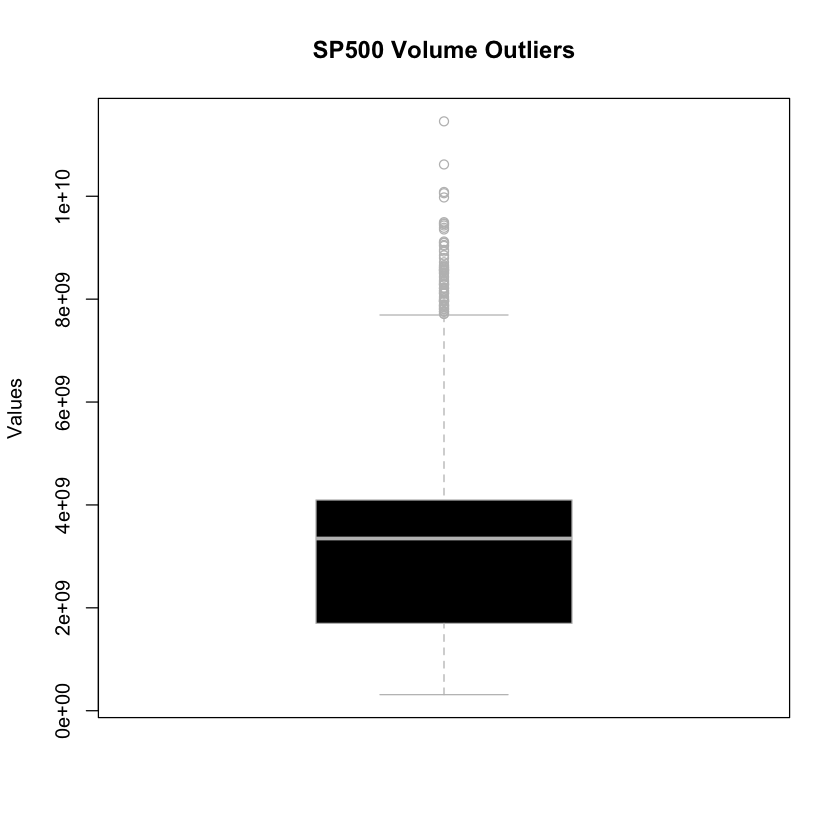

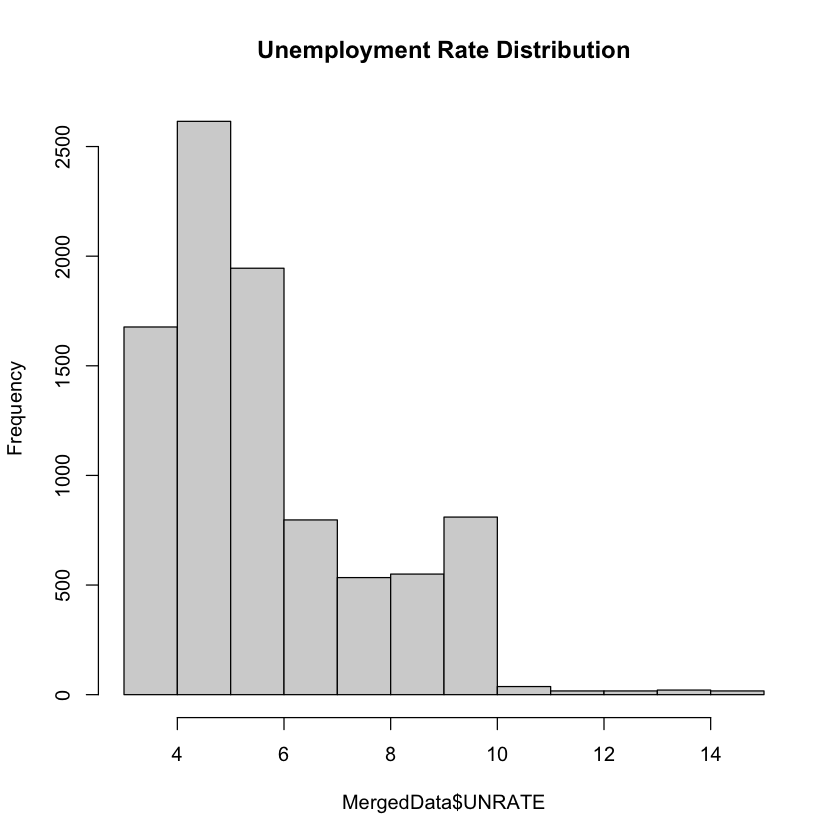

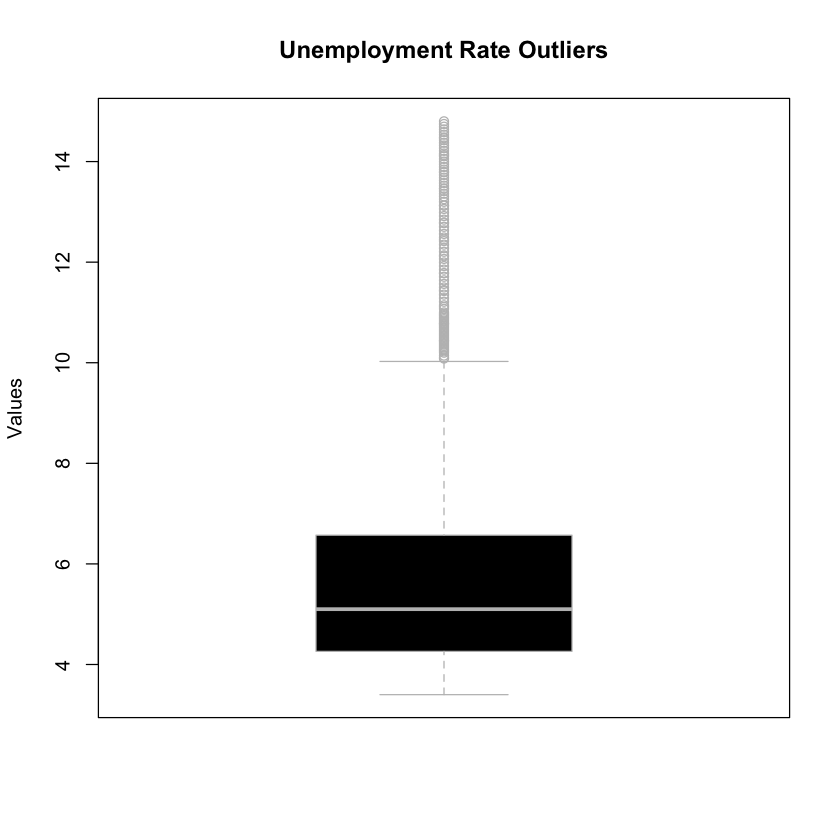

In [479]:
# Histograms for distribution investigation and boxplot to identify outliers visually

hist(MergedData$IBM.Volume,
    main = "IBM Volume Distribution")
boxplot(MergedData$IBM.Volume,
        main = "IBM Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.Open,
    main = "Apple Open Price Distribution")
boxplot(MergedData$AAPL.Open,
        main = "Apple Open Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.High,
    main = "Apple High Price Distribution")
boxplot(MergedData$AAPL.High,
        main = "Apple High Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.Low,
    main = "Apple Low price Distribution")
boxplot(MergedData$AAPL.Low,
        main = "Apple Low price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.Close,
    main = "Apple Closing Price Distribution")
boxplot(MergedData$AAPL.Close,
        main = "Apple Closing Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.Volume,
    main = "Apple Volume Distribution")
boxplot(MergedData$AAPL.Volume,
        main = "Apple Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AAPL.Adjusted,
    main = "Apple Adjusted Price Distribution")
boxplot(MergedData$AAPL.Adjusted,
        main = "Apple Adjusted Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.Open,
    main = "American Express Open Price Distribution")
boxplot(MergedData$AXP.Open,
        main = "American Express Open Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.High,
    main = "American Express High Price Distribution")
boxplot(MergedData$AXP.High,
        main = "American Express High Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.Low,
    main = "American Express Low Price Distribution")
boxplot(MergedData$AXP.Low,
        main = "American Express Low Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.Close,
    main = "American Express Closing Price Distribution")
boxplot(MergedData$AXP.Close,
        main = "American Express Closing Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.Volume,
    main = "American Express Volume Distribution")
boxplot(MergedData$AXP.Volume,
        main = "American Express Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$AXP.Adjusted,
    main = "American Express Adjusted Price Distribution")
boxplot(MergedData$AXP.Adjusted,
        main = "American Express Adjusted Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$JPM.Volume,
    main = "JPMorgan Chase Volume Distribution")
boxplot(MergedData$JPM.Volume,
        main = "JPMorgan Chase Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XOM.Volume,
    main = "Exxon Mobil Volume Distribution")
boxplot(MergedData$XOM.Volume,
        main = "Exxon Mobil Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XOM.Adjusted,
    main = "Exxon Mobil Adjusted Price Distribution")
boxplot(MergedData$XOM.Adjusted,
        main = "Exxon Mobil Adjusted Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$OXY.Volume,
    main = "Occidental Petroleum Volume Distribution")
boxplot(MergedData$OXY.Volume,
        main = "Occidental Petroleum Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLF.Volume,
    main = "Financial Sector Index Volume Distribution")
boxplot(MergedData$XLF.Volume,
        main = "Financial Sector Index Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.Open,
    main = "Technology Sector Open Price Distribution")
boxplot(MergedData$XLK.Open,
        main = "Technology Sector Open Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.High,
    main = "Technology High Price Distribution")
boxplot(MergedData$XLK.High,
        main = "Technology High Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.Low,
    main = "Technology Sector Low Price Distribution")
boxplot(MergedData$XLK.Low,
        main = "Technology Sector Low Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.Close,
    main = "Technology Sector Closing Price Distribution")
boxplot(MergedData$XLK.Close,
        main = "Technology Sector Closing Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.Volume,
    main = "Technology Sector Volume Distribution")
boxplot(MergedData$XLK.Volume,
        main = "Technology Sector Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLK.Adjusted,
    main = "Technology Sector Adjusted Price Distribution")
boxplot(MergedData$XLK.Adjusted,
        main = "Technology Sector Adjusted Price Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$XLE.Volume,
    main = "Energy Sector Volume Distribution")
boxplot(MergedData$XLE.Volume,
        main = "Energy Sector Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$GSPC.Volume,
    main = "SP500 Volume Distribution")
boxplot(MergedData$GSPC.Volume,
        main = "SP500 Volume Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

hist(MergedData$UNRATE,
    main = "Unemployment Rate Distribution")
boxplot(MergedData$UNRATE,
        main = "Unemployment Rate Outliers",
        ylab = "Values",
        col = "black",
        border = "grey")

Nearly half of the dataset variable was considered to have outliers according to the result of Z-Score. 

Variables with Z-Score outliers were verified from Yahoo Finance to be indeed real market actions, which lead to including them inside the data. Removing real financial data, even though if it’s noted as an outlier, would significantly bend the historical reality of the stock’s performance it's noted in. 

# 3. Univariate Time Series Analysis

Univariate Time Series Analysis was conducted by plotting each variable over time to visually see and identify changes in variables during the review period.

From Stocks, Sectors and SP500 closing prices were plotted over time.
The Unemployment Rate and GDP hold only a single column to them.

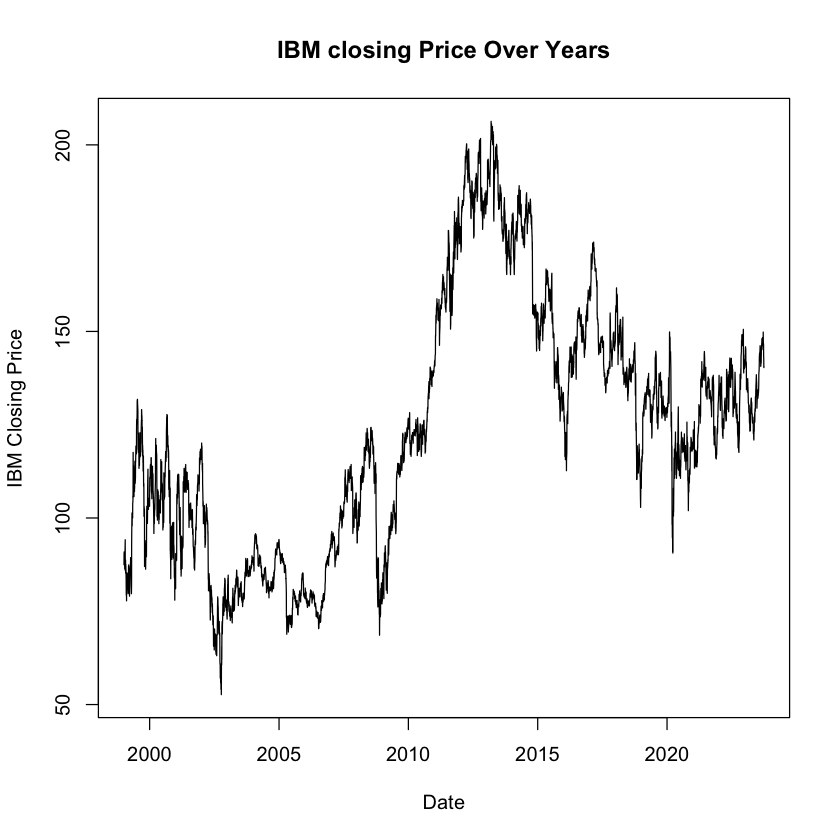

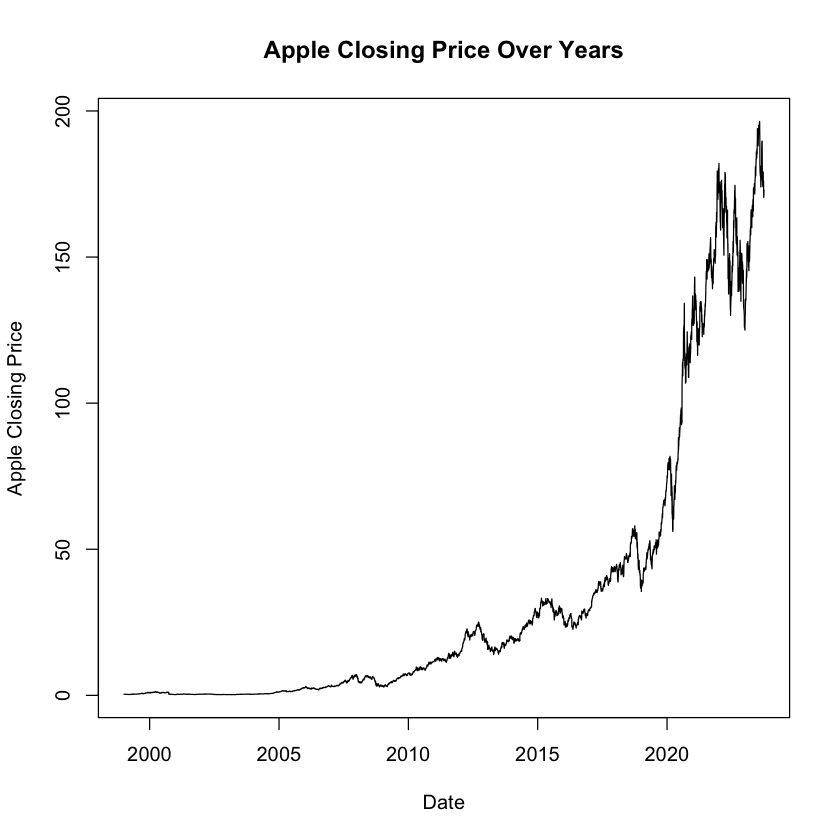

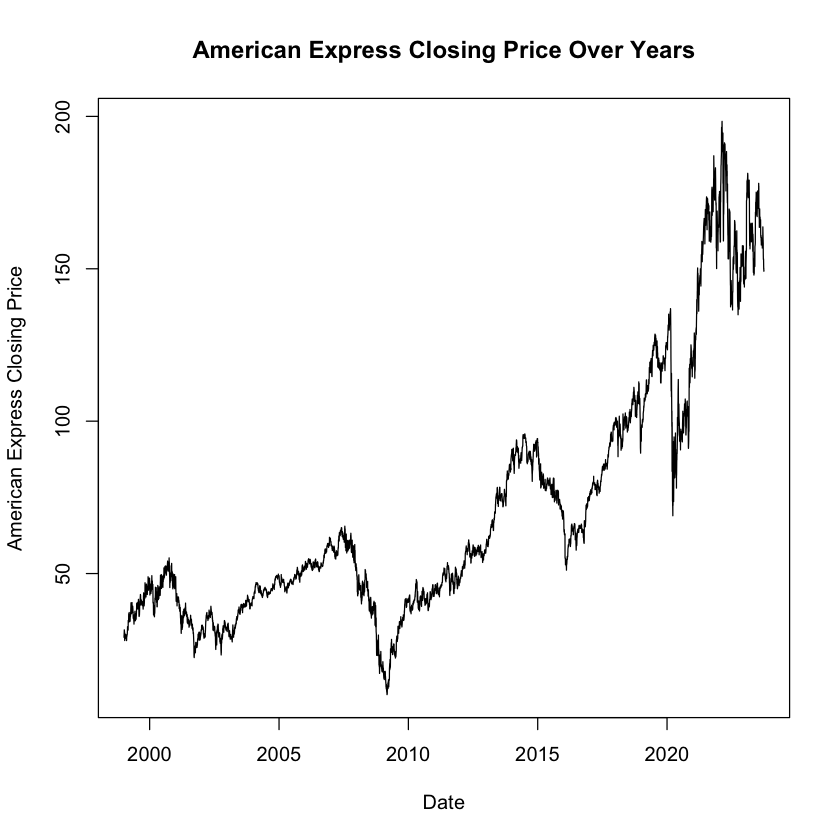

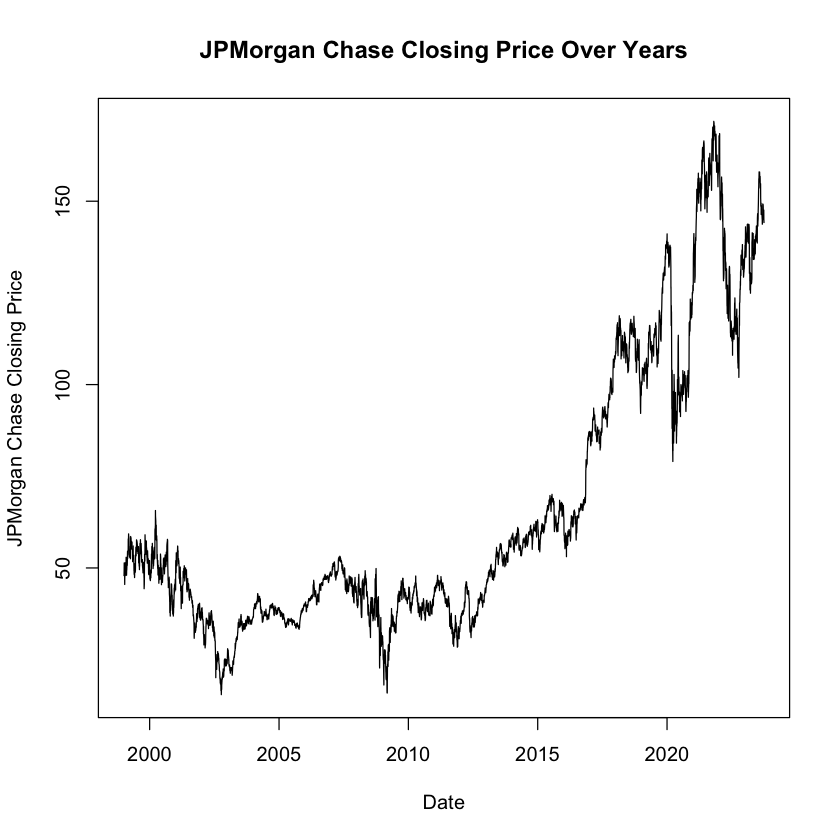

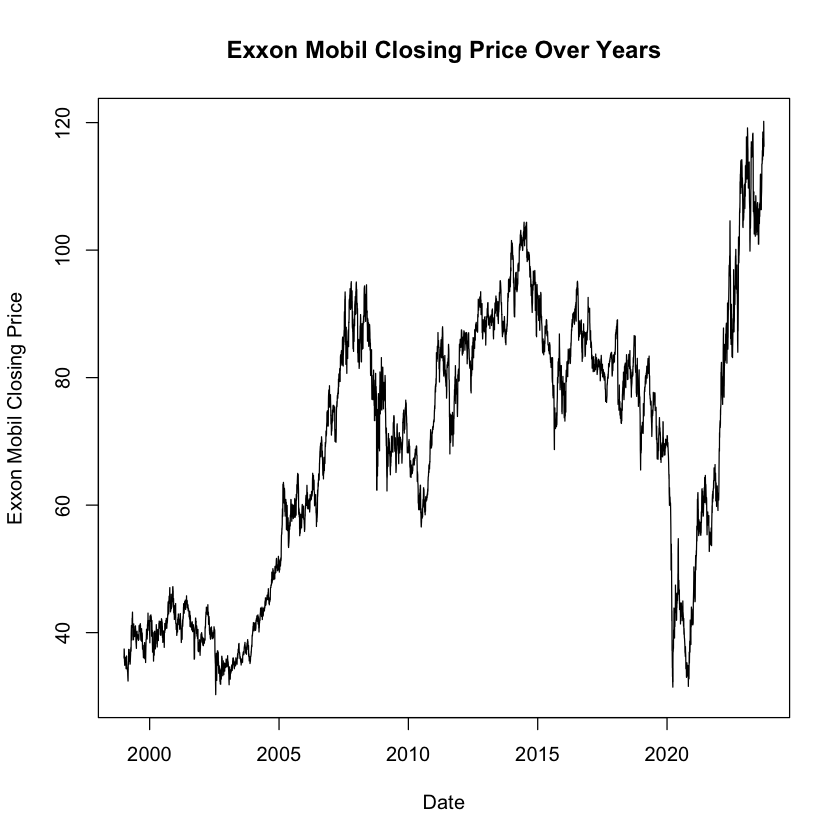

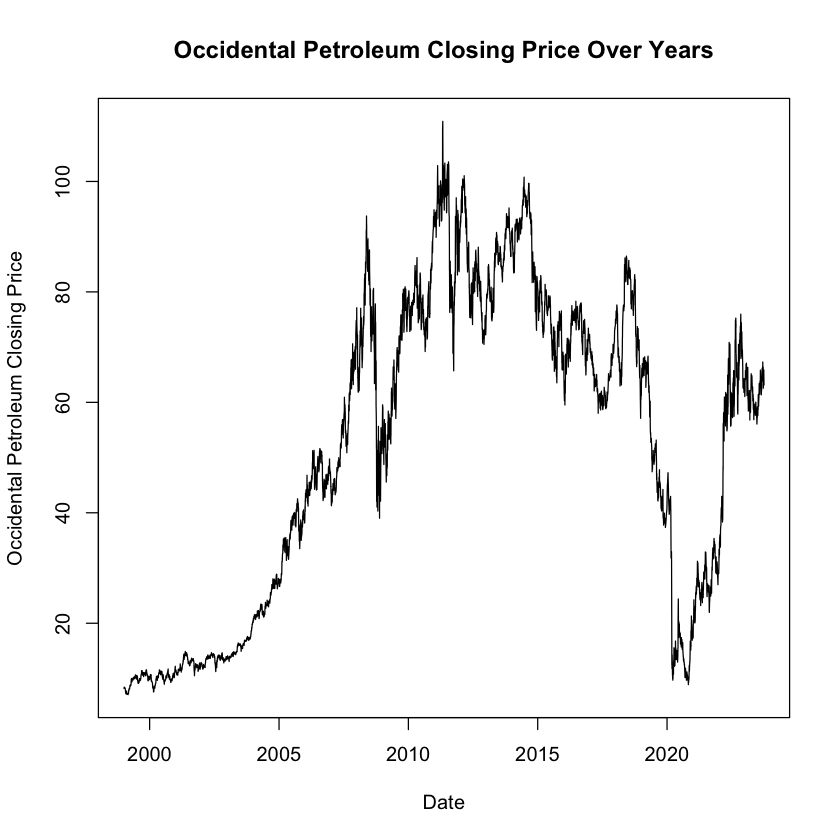

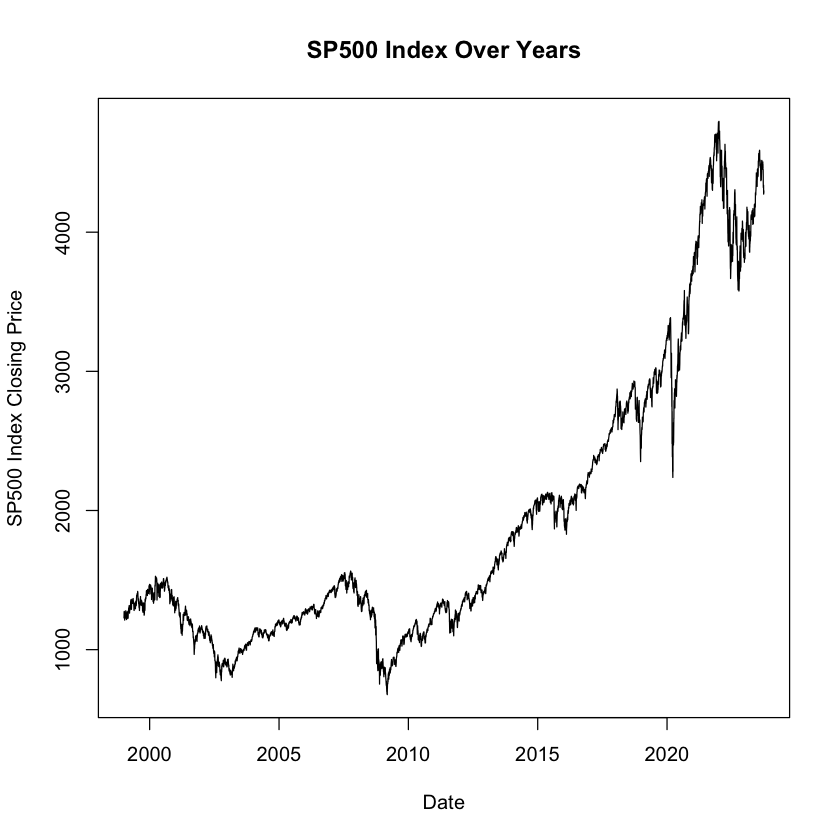

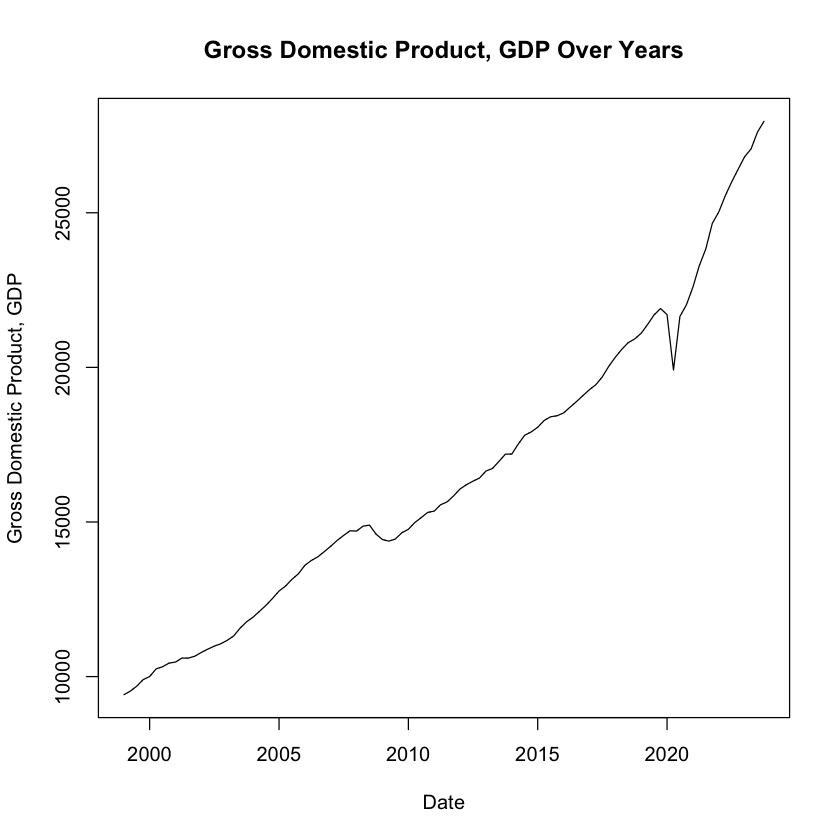

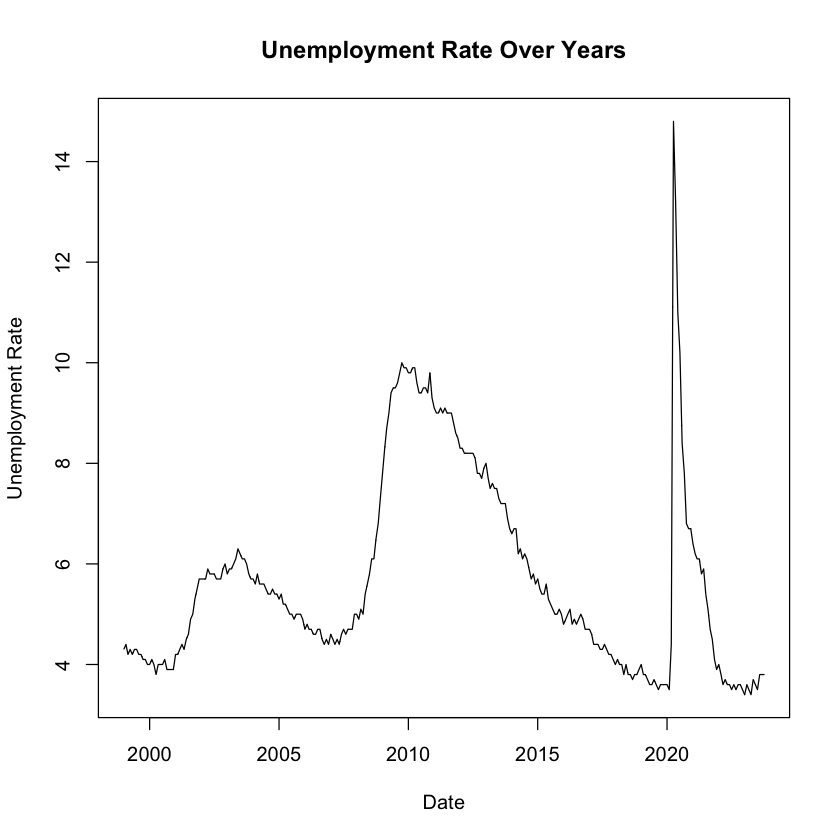

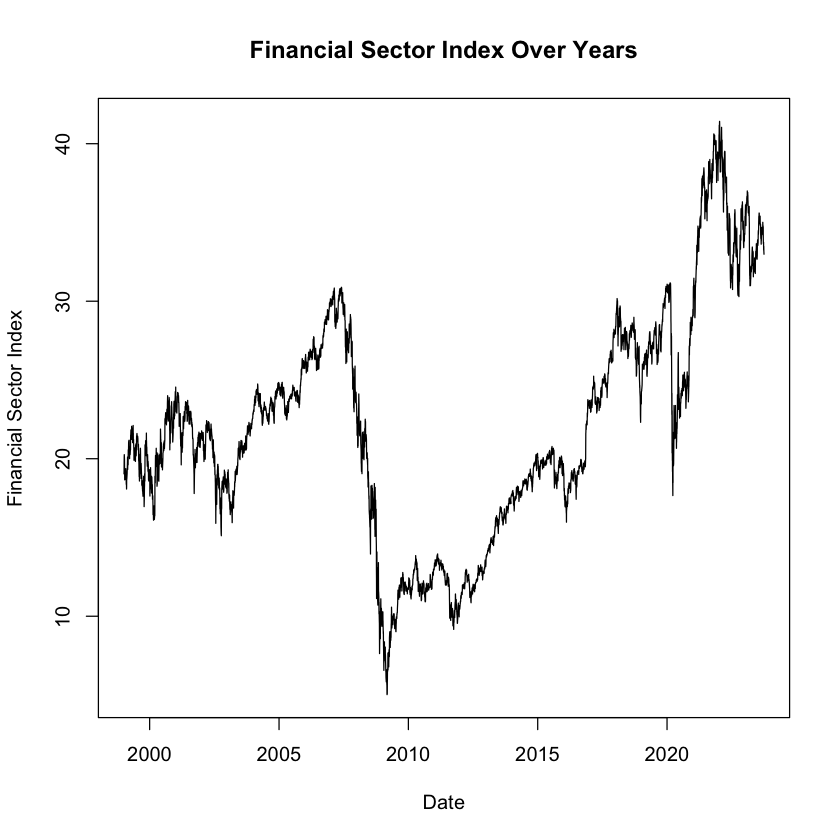

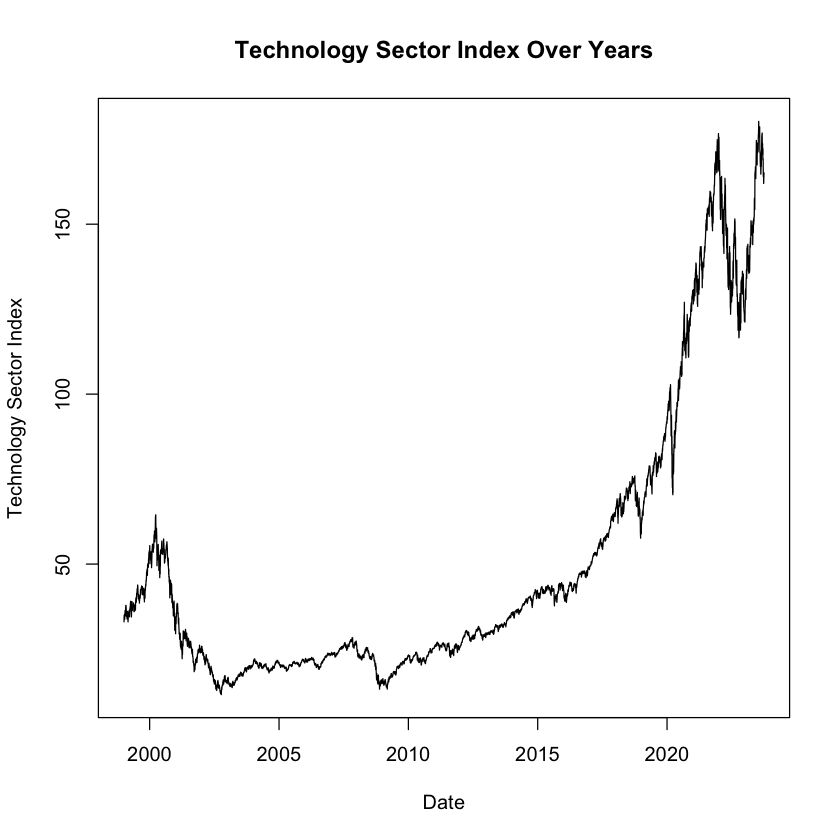

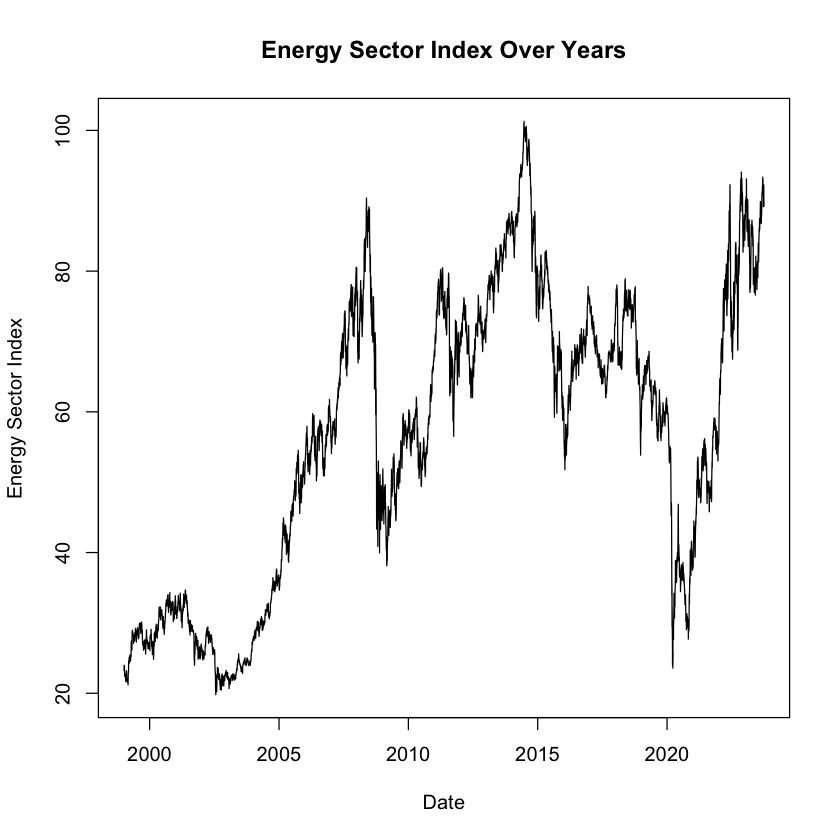

In [480]:
# Date variable was set to data as column from the rows

MergedData1 = MergedData %>% 
  tibble::rownames_to_column(var = "Date")

MergedData1$Date = as.Date(MergedData1$Date, format = "%Y-%m-%d")

# Visualizations of Time Series Data for each Stock and Sector Closing Price, SP500, GDP and Unemployment Rate.

plot(MergedData1$Date, MergedData1$IBM.Close, type = "l", 
     xlab = "Date", ylab = "IBM Closing Price", 
     main = "IBM closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData$AAPL.Close, type = "l", 
     xlab = "Date", ylab = "Apple Closing Price", 
     main = "Apple Closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$AXP.Close, type = "l", 
     xlab = "Date", ylab = "American Express Closing Price", 
     main = "American Express Closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$JPM.Close, type = "l", 
     xlab = "Date", ylab = "JPMorgan Chase Closing Price", 
     main = "JPMorgan Chase Closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$XOM.Close, type = "l", 
     xlab = "Date", ylab = "Exxon Mobil Closing Price", 
     main = "Exxon Mobil Closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$OXY.Close, type = "l", 
     xlab = "Date", ylab = "Occidental Petroleum Closing Price", 
     main = "Occidental Petroleum Closing Price Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$GSPC.Close, type = "l", 
     xlab = "Date", ylab = "SP500 Index Closing Price", 
     main = "SP500 Index Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$GDP, type = "l", 
     xlab = "Date", ylab = "Gross Domestic Product, GDP", 
     main = "Gross Domestic Product, GDP Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$UNRATE, type = "l", 
     xlab = "Date", ylab = "Unemployment Rate", 
     main = "Unemployment Rate Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$XLF.Close, type = "l", 
     xlab = "Date", ylab = "Financial Sector Index", 
     main = "Financial Sector Index Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$XLK.Close, type = "l", 
     xlab = "Date", ylab = "Technology Sector Index", 
     main = "Technology Sector Index Over Years",
     col = "black")

plot(MergedData1$Date, MergedData1$XLE.Close, type = "l", 
     xlab = "Date", ylab = "Energy Sector Index", 
     main = "Energy Sector Index Over Years",
     col = "black")


As Univariate Time Series Analysis shows, all Stock and Sector Index closing prices have increased from the start of the review period till the end. Various stocks have grown significantly, especially Apple, which has experienced magnificent growth in the latter part of the review period.

Along with Apple, multiple Stocks and Sector Indices have grown in the later part of the review period after a price drop in 2020 due to the pandemic. At this time Unemployment Rate has also peaked and GDP had its most significant dip.

2008 financial crisis seemingly affected different variables differently. The Financial Sector Index had the most significant effect as expected, but also the Energy Sector Index showed a major effect. Stocks belonging to these sectors show similar results as their Sector. 

The Unemployment Rate peaked in the early 2000s, 2009 and 2020, with the 2020 peak being the strongest one. GDP shows a direct opposite trend for 2009 and 2020, indicating a strong negative correlation between the variables. 

# 4. Bivariate Time Series Analysis

Bivariate Time Series Analysis includes correlation analysis and cross-correlation analysis.

## 4.1 Correlation Analysis

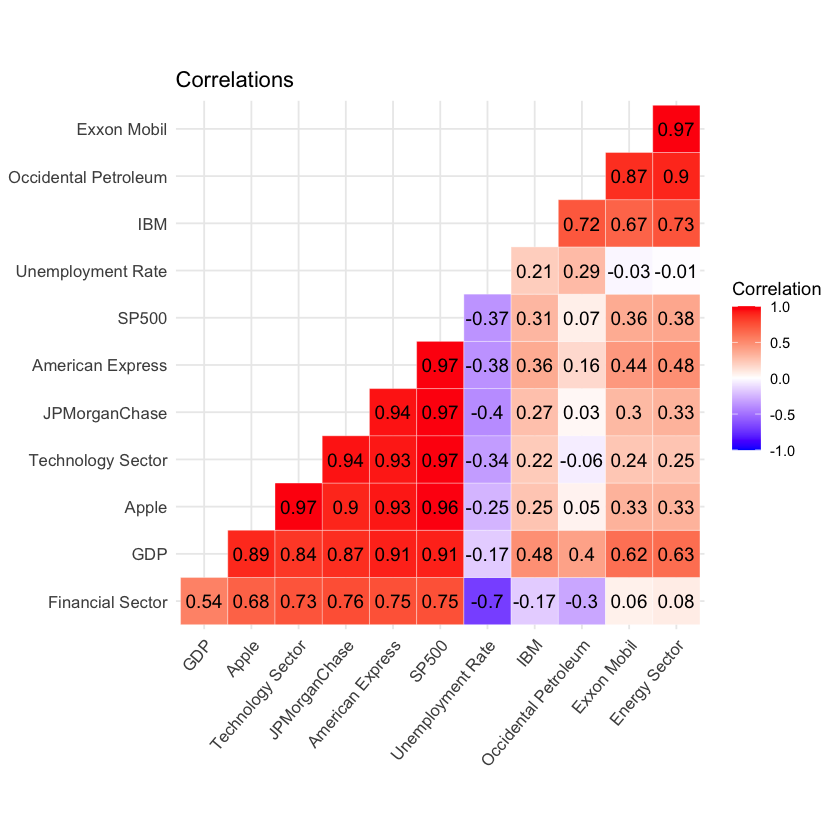

In [481]:
# Normalization function

normalize = function(x) {
  return ((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
}

# Normalizing dataset to 0-1 interval for correlation analysis

NormalizedMergedData = MergedData %>% 
  mutate(across(where(is.numeric), ~ normalize(.)))

ColumnsForCor = NormalizedMergedData [, c("AAPL.Close", "IBM.Close", "AXP.Close", "JPM.Close", "XOM.Close", "OXY.Close", "GSPC.Close", "UNRATE", "GDP", "XLF.Close", "XLK.Close", "XLE.Close")]


colnames(ColumnsForCor) = c("Apple", "IBM", "American Express", "JPMorganChase", "Exxon Mobil", "Occidental Petroleum", "SP500", "Unemployment Rate", "GDP", "Financial Sector", "Technology Sector", "Energy Sector")

# Calculating correlation values and plotting correlation matrix

correlationmatrix = cor(ColumnsForCor, use = "complete.obs")

ggcorrplot(correlationmatrix, 
           method = "square", 
           type = "lower",
           lab = TRUE, 
           lab_size = 4, 
           title = "Correlations", 
           outline.col = "White",
           colors = c("blue", "white", "Red"), 
           show.legend = TRUE, 
           legend.title = "Correlation",
           hc.order = TRUE, 
           tl.cex = 10, 
           tl.col = "black", 
           tl.srt = 50)

As the correlation heatmap shows there are some strong positive correlations with analyzed variables. Some variables even have nearly perfect correlation. As expected, stocks have a significant positive correlation with the sector index they belong to. This is also due to the companies analyzed being big enterprises in their sector. 

There seems to be a high correlation between the Financial and Technology Sectors. The Financial Sector and the Technology Sector have a strong positive correlation with a value of 0.73. A major enterprise from the Technology Sector, Apple is correlated with the Financial Sector with a positive value of 0.68, JPMorgan Chase with value of 0.9 and American Express with a value of 0.93. 

IBM however does not have correlation with the Financial Sector, and has a low positive correlation with JPMorgan Chase and American Express with values of 0.27 and 0.36. Interestingly IBM has only a low positive correlation with the sector it belongs to, with a value of 0.22, yet IBM has a strong positive correlation of 0.73 with the Energy Sector and a similar correlation level with Energy Sector Enterprises Exxon Mobil and Occidental Petroleum.

The Unemployment Rate has only one strong correlation between all variables. The Unemployment Rate is highly negatively correlated with the Financial Sector, when the Financial Sector closing price increases Unemployment Rate in the United States decreases and vice-versa. The Unemployment Rate has also a mild negative correlation with the SP500 Index, American Express, JPMorgan Chase and the Technology Sector.  

GDP has a positive correlation with all variables except the Unemployment Rate. When GDP increases all variables increase except the Unemployment rate. With Apple, American Express, JPMorgan Chase, Technology Sector and SP500, the correlation is the highest.

SP500 has a nearly perfect positive correlation >0.9 with American Express, JPMorgan Chase, Technology Sector, Apple and GDP.

## 4.2 Cross Correlation

In [482]:
# For Cross-Correlation dataset with date column was normalized and transferred as quarterly data 

# Each value representing a quarter is last daily value of that quarter

MergedData1 = MergedData1 %>% 
  mutate(across(where(is.numeric), ~ normalize(.)))
MergedData1$Date = as.Date(MergedData1$Date, format = "%m/%d/%y")
MergedQuarters = arrange(MergedData1, Date)
MergedQuarters$QDate = as.yearqtr(MergedQuarters$Date)
MergedQuarters = MergedQuarters %>%
  group_by(QDate) %>%
  summarise_all(last)
MergedQuarters = MergedQuarters [, -2]
MergedQuarters


QDate   IBM.Open   IBM.High   IBM.Low    IBM.Close  IBM.Volume IBM.Adjusted
1   1999 Q1 0.21993408 0.21388189 0.21361283 0.20876623 0.07027034 0.14362462  
2   1999 Q2 0.43652401 0.47298997 0.43898561 0.46151929 0.10567226 0.32364705  
3   1999 Q3 0.41280411 0.41174622 0.40935178 0.41019101 0.08207001 0.28770028  
4   1999 Q4 0.33931129 0.33165828 0.32824878 0.32853230 0.02693475 0.23026148  
5   2000 Q1 0.42291422 0.42116835 0.39336515 0.39385923 0.10213367 0.27733493  
6   2000 Q2 0.36108691 0.35482099 0.34072618 0.33903127 0.11086540 0.23883518  
7   2000 Q3 0.37262281 0.38400334 0.35580300 0.36884317 0.12169893 0.26068164  
8   2000 Q4 0.19329775 0.19170069 0.18826812 0.18562960 0.09424457 0.13024801  
9   2001 Q1 0.26234471 0.25778896 0.25335331 0.25261825 0.11998494 0.17866057  
10  2001 Q2 0.37485224 0.37395310 0.36793729 0.36529168 0.10613997 0.25997782  
11  2001 Q3 0.22748294 0.22941794 0.22989581 0.23212841 0.12349282 0.16502598  
12  2001 Q4 0.42369190 0.41796483 0.41761806 0.40994211 0.03632420 0.29337669  
13  2002 Q1 0.30633671 0.29890075 0.30343440 0.29910406 0.06576745 0.21429677  
14  2002 Q2 0.10663844 0.10121442 0.09054421 0.08708184 0.15578392 0.06226713  
15  2002 Q3 0.03048591 0.02003769 0.02482999 0.02015801 0.17528634 0.01457255  
16  2002 Q4 0.13967521 0.13668342 0.14405138 0.13955081 0.10003186 0.10152586  
17  2003 Q1 0.15311390 0.14390703 0.15160023 0.14533689 0.13361698 0.10640388  
18  2003 Q2 0.18198222 0.17273869 0.17774035 0.17065887 0.10119385 0.12546131  
19  2003 Q3 0.21495675 0.20445982 0.21142928 0.20693084 0.08812404 0.15263286  
20  2003 Q4 0.23648353 0.22707288 0.23800614 0.23399491 0.05407119 0.17310852  
21  2004 Q1 0.23281281 0.22324121 0.23395094 0.22876873 0.05241372 0.16997062  
22  2004 Q2 0.20935730 0.19974876 0.21018152 0.20581097 0.05402881 0.15400247  
23  2004 Q3 0.18969699 0.18391960 0.19339944 0.19081688 0.06095689 0.14384755  
24  2004 Q4 0.27343994 0.26513818 0.27749703 0.27070242 0.02580784 0.20335282  
25  2005 Q1 0.22279599 0.21802766 0.22590303 0.22590677 0.04956503 0.17120736  
26  2005 Q2 0.12536550 0.11802765 0.12514818 0.11901948 0.07453535 0.09335528  
27  2005 Q3 0.15784233 0.14949749 0.16195645 0.15647358 0.06590448 0.12191195  
28  2005 Q4 0.17016115 0.16209172 0.17070620 0.16857460 0.08752222 0.13178097  
29  2006 Q1 0.17607166 0.16896983 0.17643021 0.17047218 0.07066206 0.13414594  
30  2006 Q2 0.14340819 0.13335428 0.14211741 0.13532008 0.10062089 0.10927222  
⋮   ⋮       ⋮          ⋮          ⋮          ⋮          ⋮          ⋮           
71  2016 Q3 0.6486033  0.6478643  0.6491360  0.6456791  0.03755488 0.6669787   
72  2016 Q4 0.6963852  0.6927921  0.6963473  0.6919679  0.02807299 0.7185051   
73  2017 Q1 0.7424252  0.7427764  0.7466467  0.7408076  0.02756909 0.7721167   
74  2017 Q2 0.6198594  0.6143217  0.6184415  0.6144465  0.03718363 0.6619762   
75  2017 Q3 0.5647152  0.5614531  0.5677626  0.5632842  0.02533524 0.6224455   
76  2017 Q4 0.6202016  0.6159862  0.6205627  0.6144777  0.04000895 0.6808061   
77  2018 Q1 0.6131711  0.6088882  0.5973236  0.6015056  0.04761522 0.6772396   
78  2018 Q2 0.5287750  0.5293970  0.5310999  0.5268670  0.03772492 0.6135746   
79  2018 Q3 0.6027292  0.6037898  0.6076070  0.6055704  0.03770056 0.7016806   
80  2018 Q4 0.3650843  0.3621231  0.3644020  0.3645866  0.05781149 0.4694161   
81  2019 Q1 0.5383148  0.5400754  0.5430574  0.5443705  0.03891565 0.6621952   
82  2019 Q2 0.5263900  0.5276801  0.5289787  0.5235488  0.04787685 0.6513904   
83  2019 Q3 0.5542214  0.5645101  0.5597355  0.5621228  0.04327712 0.7024953   
84  2019 Q4 0.4845393  0.4863066  0.4890511  0.4913208  0.04019457 0.6384818   
85  2020 Q1 0.3568096  0.3587312  0.3503650  0.3475394  0.07769684 0.4933537   
86  2020 Q2 0.4015429  0.4051508  0.4054526  0.4087600  0.04227007 0.5699079   
87  2020 Q3 0.4151683  0.4158920  0.4166823  0.4143595  0.03264677 0.5867856   
88  2020 Q4 0.4328377  0.4354900  0.4365837  0.4405525  0.03722601 0.6281790   
89  

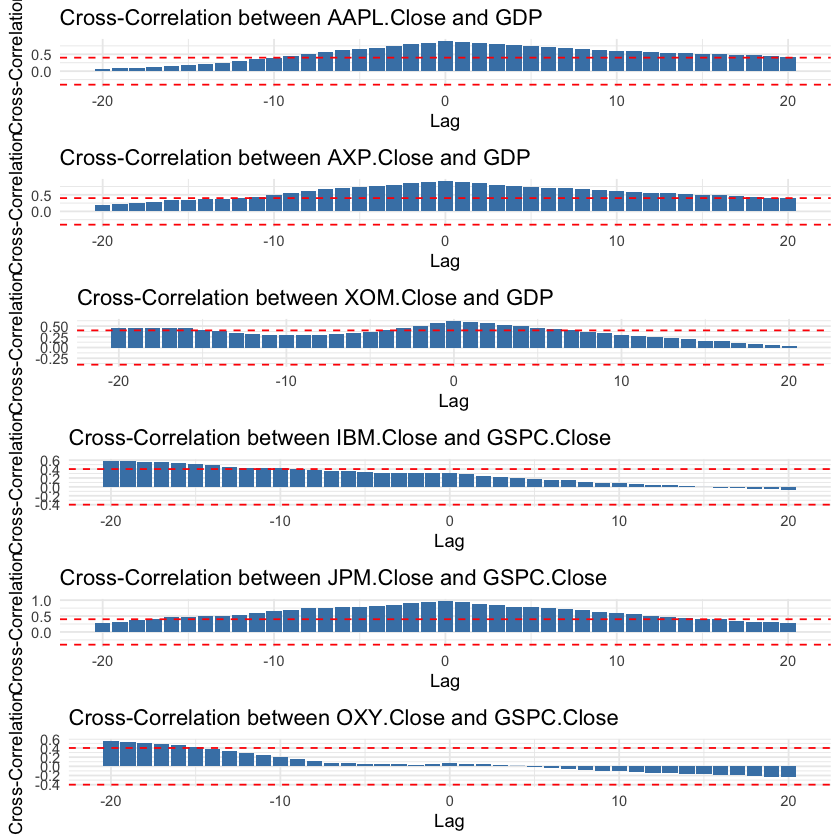

In [483]:
# Pairs for Cross-Correlation

# NOTE! You can change the pairing the code runs through -> "plot_list = lapply(pairsX," <- change X accordingly.

# Tech
pairs = list(c("AAPL.Close", "XLK.Close"), c("AAPL.Close", "UNRATE"), c("AAPL.Close", "IBM.Close"), c("IBM.Close", "XLK.Close"), c("IBM.Close", "UNRATE"))

# Fin
pairs2 = list(c("AXP.Close", "XLF.Close"), c("AXP.Close", "UNRATE"), c("AXP.Close", "JPM.Close"), c("JPM.Close", "XLF.Close"), c("JPM.Close", "UNRATE"))

#Energy
pairs3 = list(c("XOM.Close", "XLE.Close"), c("XOM.Close", "UNRATE"), c("XOM.Close", "OXY.Close"), c("OXY.Close", "XLE.Close"), c("OXY.Close", "UNRATE"))

# Market Indices
pairs4 = list(c("GDP", "UNRATE"), c("GDP", "GSPC.Close"), c("UNRATE", "GSPC.Close"))

# Sectors
pairs5 = list(c("XLF.Close", "UNRATE"), c("XLK.Close", "UNRATE"), c("XLE.Close", "UNRATE"), c("XLF.Close", "GDP"), c("XLK.Close", "GDP"), c("XLE.Close", "GDP"))

# Sectors2
pairs6 = list(c("XLF.Close", "XLK.Close"), c("XLF.Close", "XLE.Close"), c("XLK.Close", "XLE.Close"), c("XLF.Close", "GSPC.Close"), c("XLK.Close", "GSPC.Close"), c("XLE.Close", "GSPC.Close"))

# Stocks to GDP & SP500
pairs7 = list(c("AAPL.Close", "GDP"), c("AXP.Close", "GDP"), c("XOM.Close", "GDP"), c("IBM.Close", "GSPC.Close"), c("JPM.Close", "GSPC.Close"), c("OXY.Close", "GSPC.Close"))

plot_list = lapply(pairs7, function(pair) {
  ts1 = MergedQuarters[[pair[1]]]
  ts2 = MergedQuarters[[pair[2]]]

  valid_indices = complete.cases(ts1, ts2)
  ts1 = ts1[valid_indices]
  ts2 = ts2[valid_indices]
  
  ccf_result = ccf(ts1, ts2, lag.max = 20, plot = FALSE)
  ccf_df = data.frame(Lag = ccf_result$lag, CrossCorrelation = ccf_result$acf)
  
  # Plots for cross-correlation
  
    p = ggplot(ccf_df, aes(x = Lag, y = CrossCorrelation)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    geom_hline(yintercept = c(-0.4, 0.4), linetype = "dashed", color = "red") +
    theme_minimal() +
    labs(title = paste("Cross-Correlation between", pair[1], "and", pair[2]),
         x = "Lag",
         y = "Cross-Correlation")
  
  return(p)
})

# Combining plots into a grid

do.call(grid.arrange, c(plot_list, ncol = 1))

Lags present quarters. E.g. 10 lag = 2.5 years. The intercept is set to represent positive and negative 0.4 correlations.

In the first set of pairs, Apple and the Technology Sector have a positive correlation at lag 0 and the correlation stays above intercept for around -8 and 8 lags. This relationship indicates that the companies have mutually lagged relationship with each other, both variable`s past performance is associated with the other's present day. IBM and the Technology Sector have a positive correlation at lag -20. This indicates that IBM price changes 5 years ago are associated with the same direction changes in the Technology Sector today. Apple and IBM have a positive correlation at lag 20, indicating IBM performance 5 years ago is associated with Apple's performance today. IBM has a surprisingly similar relationship with the Unemployment Rate also at lag 10, indicating higher Unemployment Rate being associated with higher IBM prices today.

In the second set of pairs, there are no markable correlations at high lags. American Express and JPMorgan Chase stock closing prices positively correlate with each other and peak at lag 0. Correlation is present at low lags, both negative and positive, indicating both have lagged correlation with each other, which in essence is expected here.

In the third set of pairs, both Exxon Mobil and Occidental Petroleum have similar positive correlations with each other as well as with the Energy Sector. The positive correlation for these is also present in short time lags both negative and positive, indicating a mutual lagged relationship for these variables. Both Exxon Mobil and Occidental Petroleum have a similar positive correlation with the Unemployment Rate at a positive lag near 10, this indicates that a higher Unemployment Rate around 2.5 years ago is associated with higher stock prices for Exxon Mobil and Occidental Petroleum. The lag is smaller for Occidental Petroleum, meaning a shorter lag time.

In the fourth set of pairs, GDP and SP500 have a high positive correlation with each other at lag 0. The positive correlation is present in both positive and negative lags, lasting slightly longer for negative lag times. This indicates a mutual lagged relationship with the variables, yet the lagged effects are present from a longer timeline when SP500 is the lagging variable, for example, the positive correlation is present at lag -20, indicating changes in GDP from five years ago are associated with same direction changes in SP500 today.

In the fifth set of pairs, the Financial Sector and the Technology Sector have negative correlations with the Unemployment Rate at lag 0. For the Technology Sector the correlation is low, under intercept. The Energy Sector has a positive correlation with the Unemployment Rate at lag 10, indicating changes in the Unemployment Rate 2.5 years ago, are associated with the same direction changes in the Energy Sector. All Sectors have positive correlations with GDP at lag 0. For the Energy Sector the positive correlation is also present in lag -20, this indicates changes in the Energy Sector five years ago are associated with the same direction changes in GDP today, interestingly same kind of lagged correlation is not present for the Financial Sector or the Technology Sector.

In the sixth set of pairs, the Financial Sector and Technology Sector have a positive correlation at lag 0. Between the Sectors, the Technology Sector and Energy Sector have a positive correlation at lag 20, this indicates that changes in the Energy Sector 5 years ago are associated with the same direction changes in the Technology Sector today. Similar correlation relationships are present when considering Sectors and SP500. The Financial Sector and Technology Sector have a positive correlation at lag 0 and it is present in both low negative and positive lags. However, the Energy Sector has a slightly lower positive correlation with SP500 at lag 0, yet the correlation is higher at lag -20, indicating that changes in the Energy Sector 5 years ago are associated with the same direction changes in SP500 today. The Financial Sector and Technology Sector have a similar relationship but it is not with 5 years lagtime.

In the seventh set of pairs, Apple and IBM have similar correlation relationships with GDP, the correlation peaks at lag 0 and holds over intercept correlation for low positive and negative lags, indicating mutual lagged relationships in short-term lags, around 1.5 years. Along with a positive correlation at lag 0, Exxon Mobil has over 0.4 correlation with GDP at lag -16 to -20, this indicates that changes in Exxon Mobil 4-5 years ago are associated with same direction changes in GDP today. IBM and Occidental Petroleum both have a positive correlation with SP500 at lag -20, indicating that changes in the IBM and Occidental Petroleum five years ago, are associated with same direction changes in SP500 today. However, in the case of JPMorgan Chase, there is also a positive correlation but lag peaks at 0 and stays over intercept till both lag -8 and 8, indicating a mutual lagged correlation relationship between the two.

# 5. Time Series Decomposition

The dataset for the Time Series Decomposition dataset was set as unnormalized quarterly data.
Time Series were decomposed using the stl() function, which divides time series into seasonal/trend/residual components.

In [484]:
# For Time Series Decomposition, data was set as quarterly data.

MergedData2 = MergedData %>% 
  tibble::rownames_to_column(var = "Date")
MergedData2$Date = as.Date(MergedData2$Date, format = "%Y-%m-%d")
MergedData2 = arrange(MergedData2, Date)
MergedData2$QDate = as.yearqtr(MergedData2$Date)
MergedData2 = MergedData2 %>%
  group_by(QDate) %>%
  summarise_all(last)
MergedData2 = MergedData2 [, -2]
MergedData2

QDate   IBM.Open  IBM.High  IBM.Low   IBM.Close IBM.Volume IBM.Adjusted
1   1999 Q1  86.04207  86.75908  84.36903  84.72753  6103619   45.59214    
2   1999 Q2 119.32362 126.19503 118.90536 123.56596  8637136   66.56653    
3   1999 Q3 115.67878 116.87380 114.36424 115.67878  6948055   62.37838    
4   1999 Q4 104.38576 104.68451 101.93594 103.13097  3002334   55.68619    
5   2000 Q1 117.23232 118.30784 111.91444 113.16921  8383899   61.17071    
6   2000 Q2 107.73183 108.20985 103.84799 104.74426  9008780   56.68511    
7   2000 Q3 109.50446 112.65137 106.15838 109.32521  9784075   59.23044    
8   2000 Q4  81.94909  83.38313  80.48518  81.17232  7819320   44.03364    
9   2001 Q1  92.55895  93.44168  90.45889  91.46590  9661414   49.67418    
10  2001 Q2 109.84704 111.12173 108.01785 108.77948  8670608   59.14844    
11  2001 Q3  87.20204  89.12365  86.86425  88.31740  9912454   48.08561    
12  2001 Q4 117.35181 117.82027 115.63097 115.64053  3674284   63.03973    
13  2002 Q1  99.31883  99.69885  98.13337  98.60898  5781373   53.82615    
14  2002 Q2  68.63288  69.61122  65.50988  66.02932 12223347   36.11320    
15  2002 Q3  56.93117  57.25621  55.43977  55.74570 13619025   30.55631    
16  2002 Q4  73.70937  75.00956  73.70937  74.09178  8233484   40.68723    
17  2003 Q1  75.77438  76.10899  74.86616  74.98088 10636983   41.25556    
18  2003 Q2  80.21033  80.49713  78.87189  78.87189  8316641   43.47594    
19  2003 Q3  85.27724  85.32505  84.03442  84.44550  7381308   46.64169    
20  2003 Q4  88.58508  88.76673  88.10708  88.60421  4944337   49.02731    
21  2004 Q1  88.02103  88.18356  87.48566  87.80115  4825721   48.66171    
22  2004 Q2  84.41682  84.60803  83.84321  84.27342  4941304   46.80127    
23  2004 Q3  81.39579  82.19885  81.27151  81.96941  5437108   45.61812    
24  2004 Q4  94.26386  94.56023  94.15870  94.24474  2921687   52.55107    
25  2005 Q1  86.48183  87.39006  86.25239  87.36137  4621856   48.80581    
26  2005 Q2  71.51051  72.17017  70.81262  70.93690  6408842   39.73527    
27  2005 Q3  76.50095  76.95985  76.45316  76.69216  5791179   43.06240    
28  2005 Q4  78.39388  78.87667  77.79397  78.55162  7338239   44.21224    
29  2006 Q1  79.30210  79.92352  78.67113  78.84321  6131652   44.48779    
30  2006 Q2  74.28298  74.50287  73.41300  73.44168  8275638   41.58975    
⋮   ⋮       ⋮         ⋮         ⋮         ⋮         ⋮          ⋮           
71  2016 Q3 151.9120  152.8107  151.1090  151.8642  3762357    106.56804   
72  2016 Q4 159.2543  159.6487  158.3437  158.9771  3083791    112.57138   
73  2017 Q1 166.3289  167.2562  166.0516  166.4818  3047730    118.81765   
74  2017 Q2 147.4952  147.7056  146.4053  147.0650  3735789    105.98521   
75  2017 Q3 139.0217  139.6590  138.6393  139.2033  2887866    101.37949   
76  2017 Q4 147.5478  147.9589  146.7304  147.0698  3937981    108.17908   
77  2018 Q1 146.4675  146.8786  143.1692  145.0765  4482319    107.76354   
78  2018 Q2 133.4990  134.7801  133.0210  133.6074  3774526    100.34594   
79  2018 Q3 144.8630  146.1026  144.7451  145.7011  3772782    110.61116   
80  2018 Q4 108.3461  109.3212  107.4761  108.6711  5212009     83.55006   
81  2019 Q1 134.9649  136.4054  134.8534  136.2970  3859740    106.01072   
82  2019 Q2 133.1326  134.5188  132.6960  133.0975  4501042    104.75185   
83  2019 Q3 137.4092  140.1243  137.4092  139.0249  4171866    110.70608   
84  2019 Q4 126.7017  128.2218  126.5774  128.1453  3951265    103.24787   
85  2020 Q1 107.0746  108.8050  105.3251  106.0516  6635092     86.33902   
86  2020 Q2 113.9484  115.8700  113.7667  115.4589  4099797     95.25834   
87  2020 Q3 116.0421  117.5048  115.4876  116.3193  3411111     97.22476   
88  2020 Q4 118.7572  120.4876  118.5373  120.3442  3738822    102.04749   
89  2021 Q1 128.6233  128.7859  126.8738  127.3996  5172575    109.47386   
90  2021 Q2 138.7476  140.4684  138.3461  140.1434  3394375    121.77005   
91  2021 Q3 133.8432  134.3881  132.4092  132.8203  

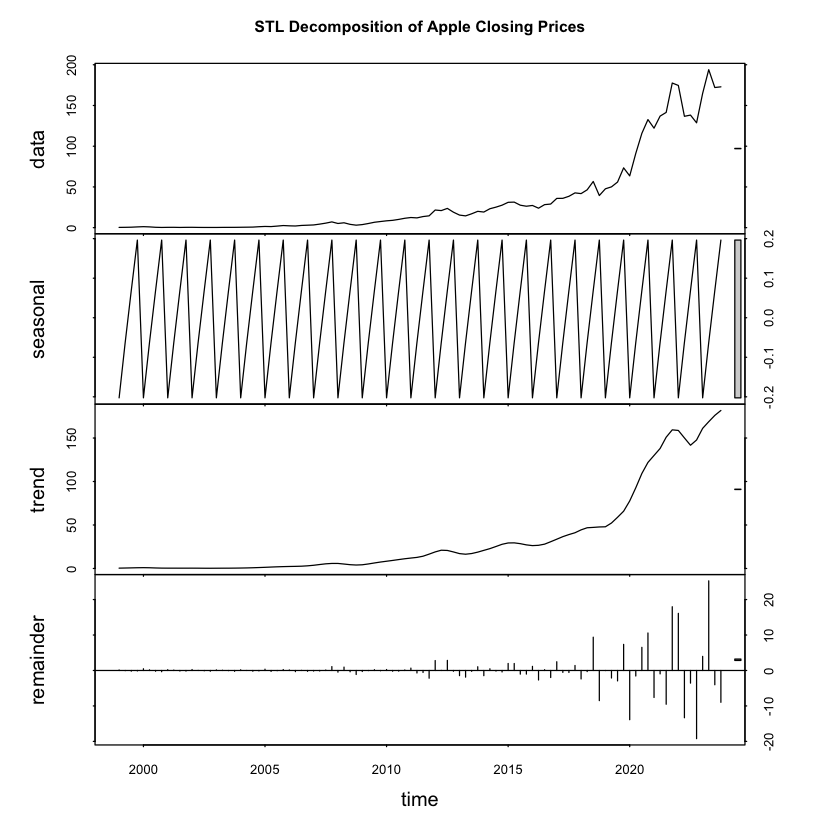

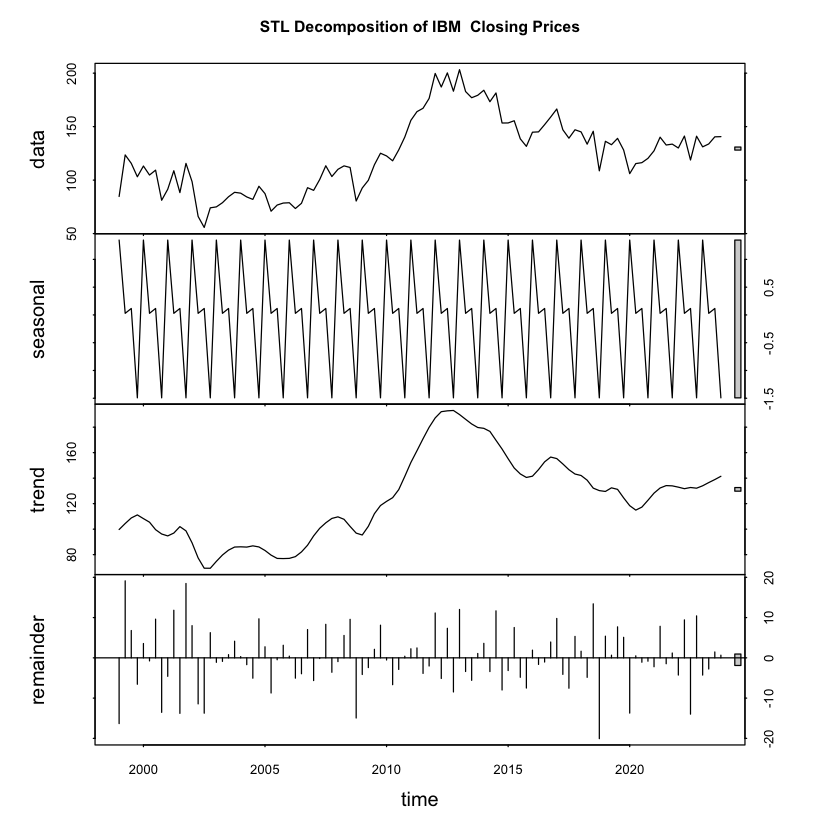

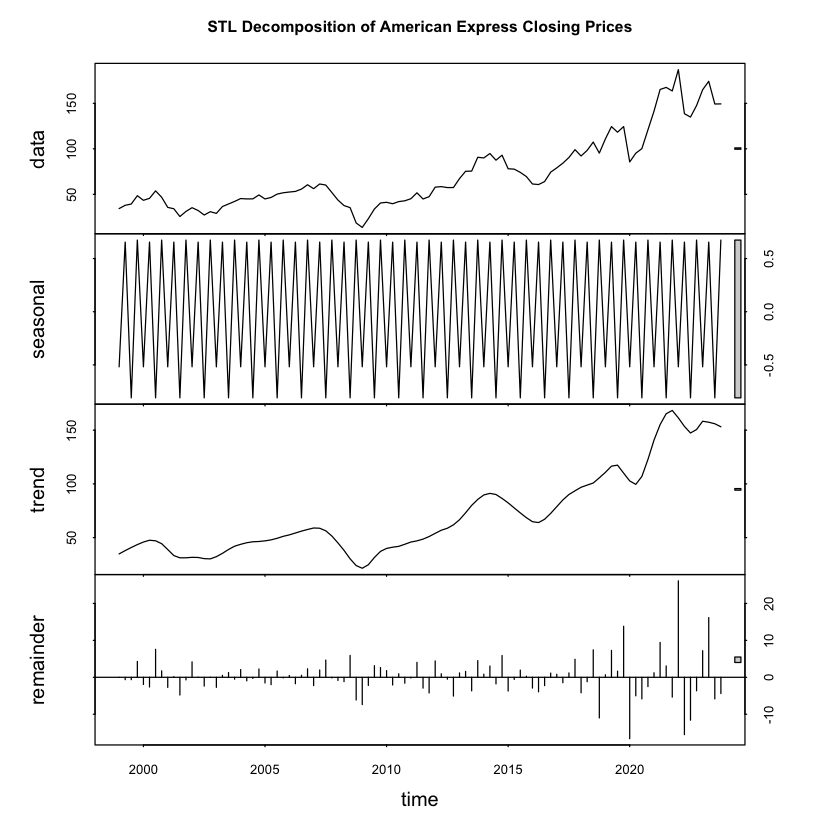

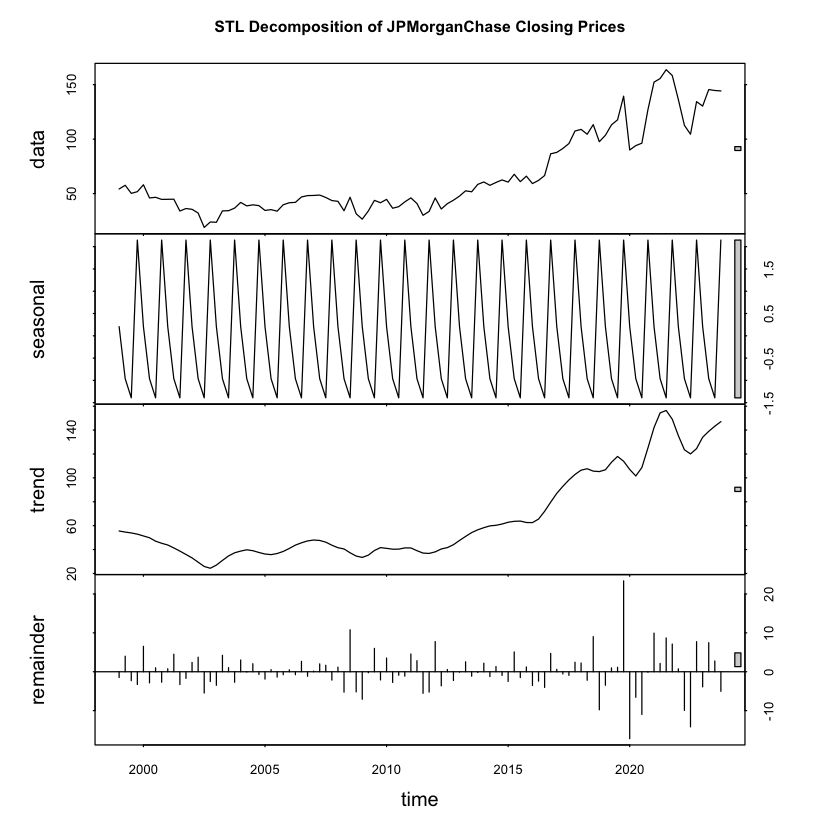

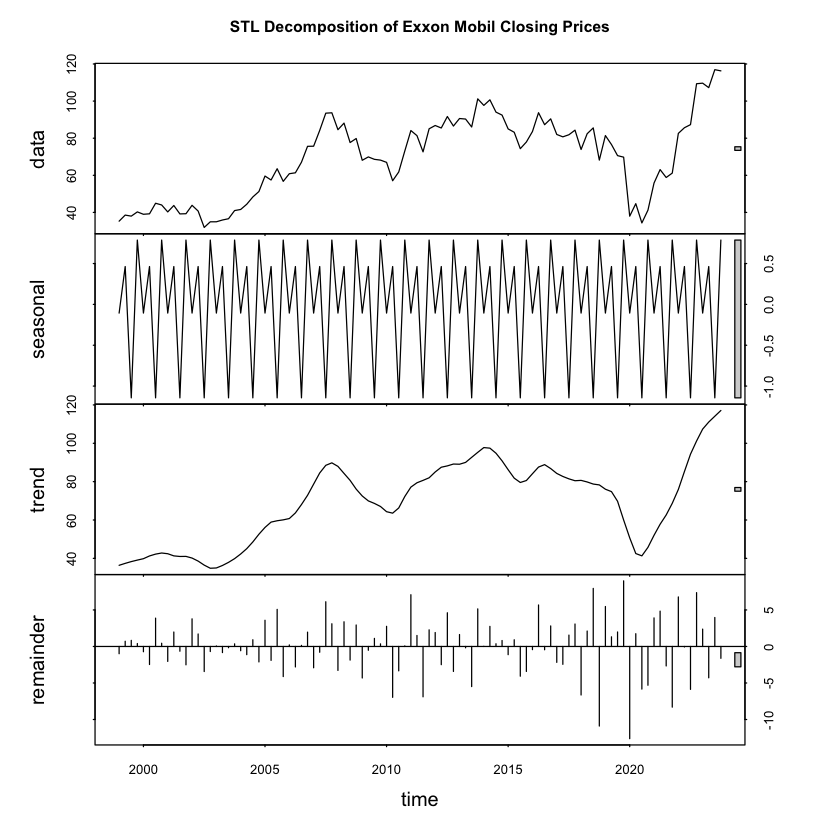

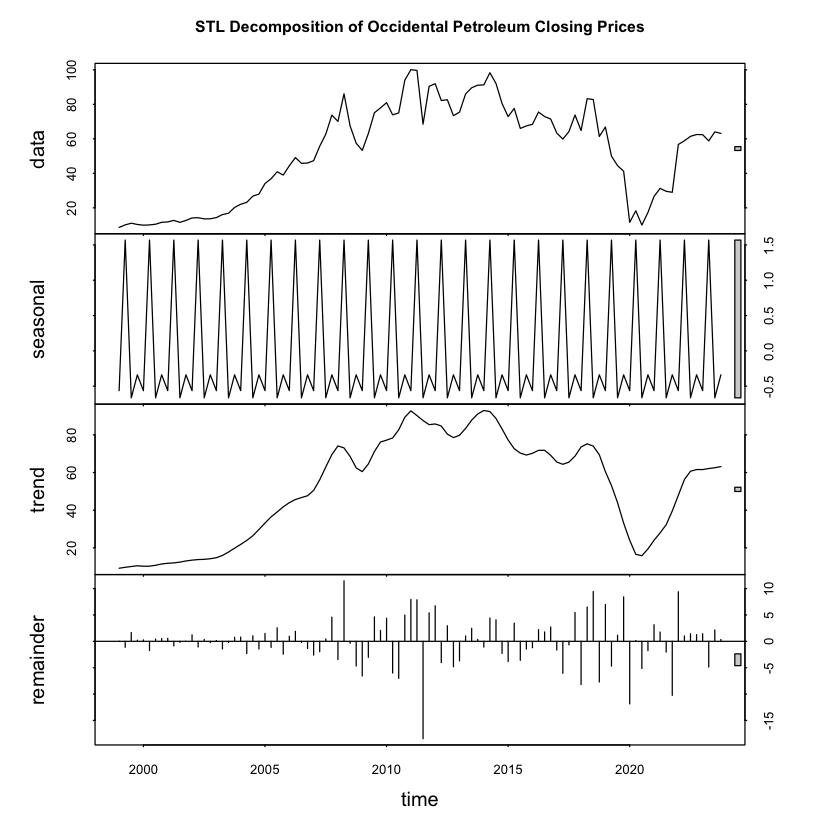

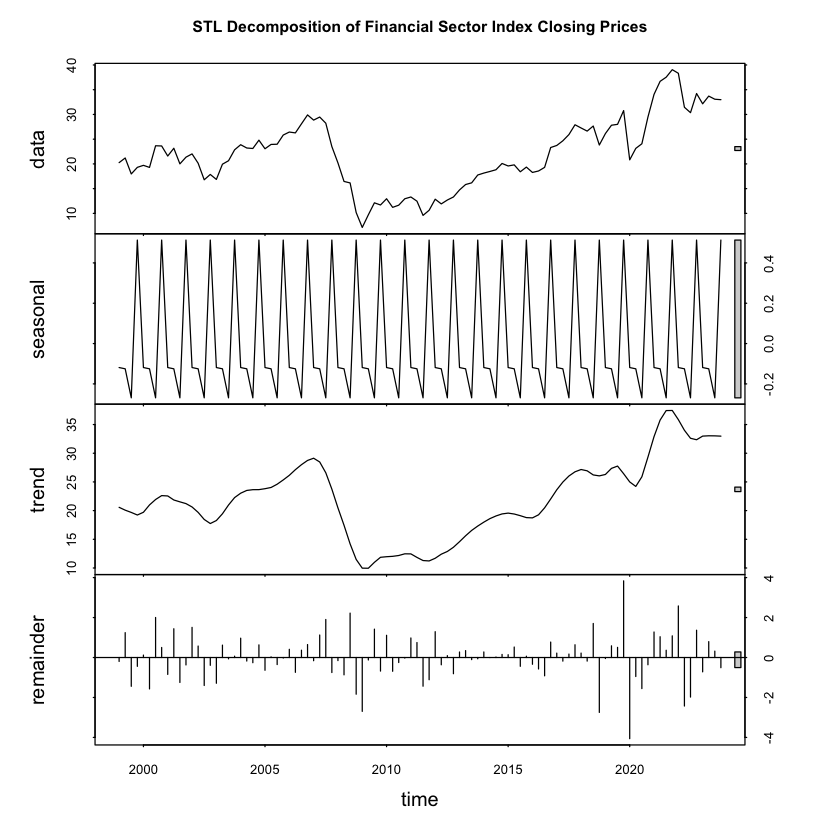

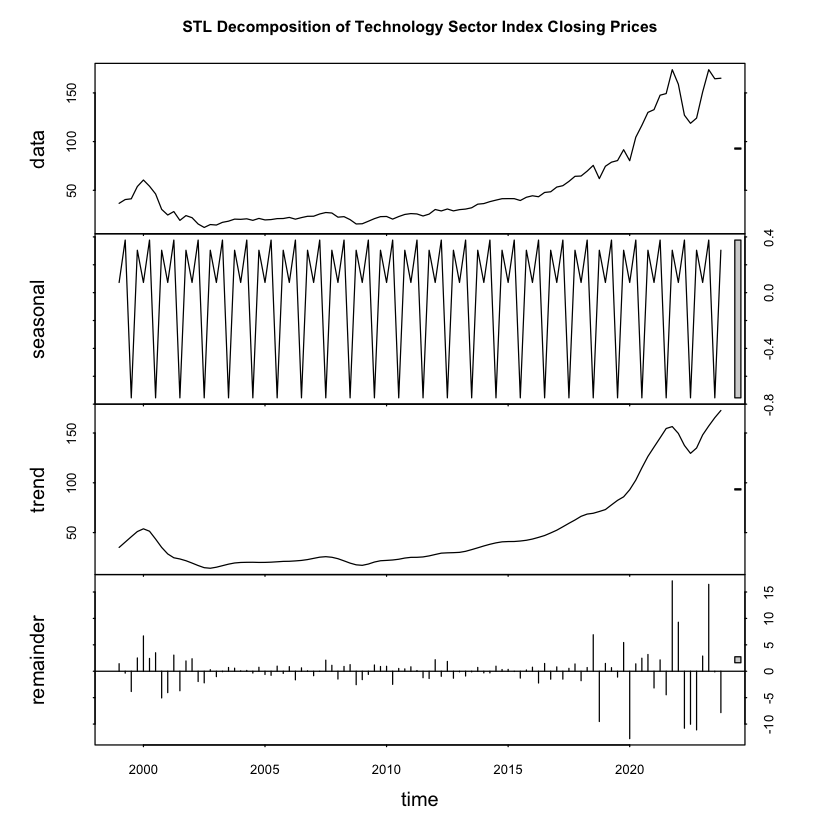

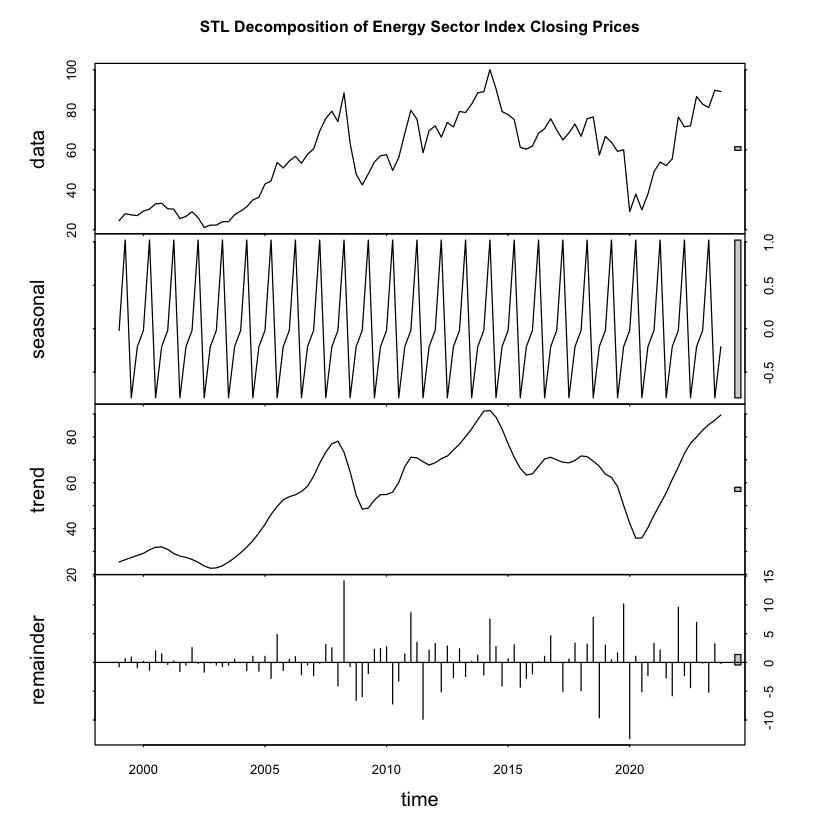

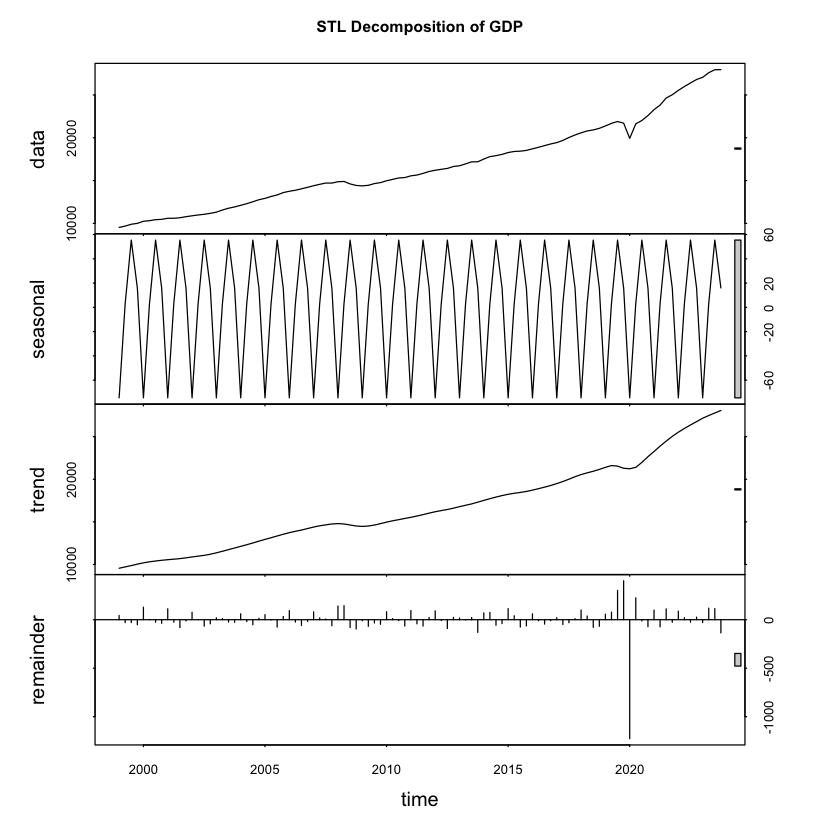

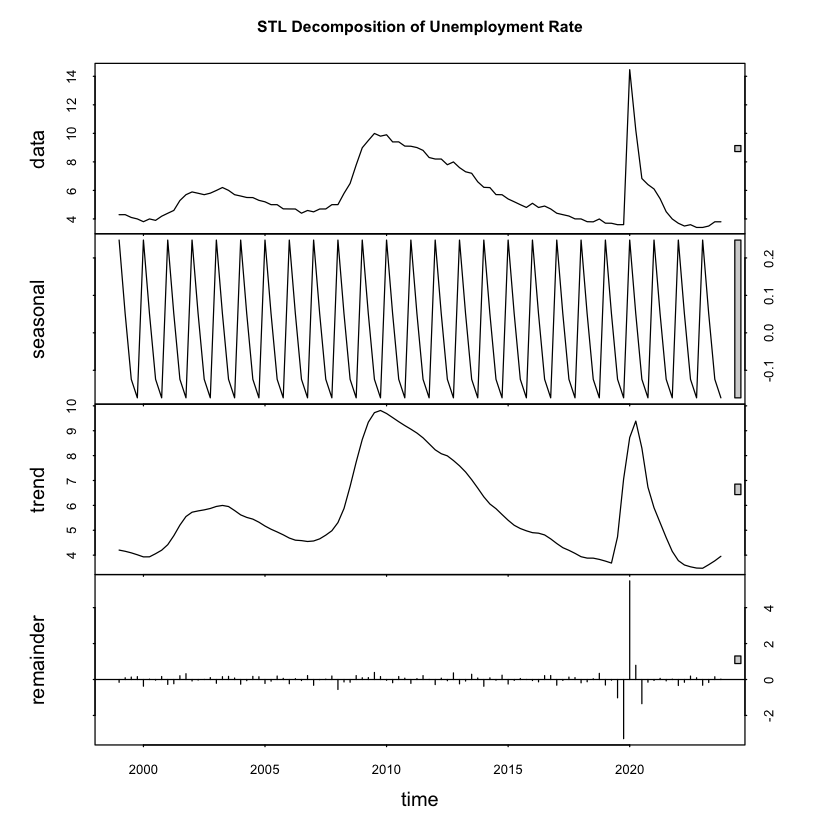

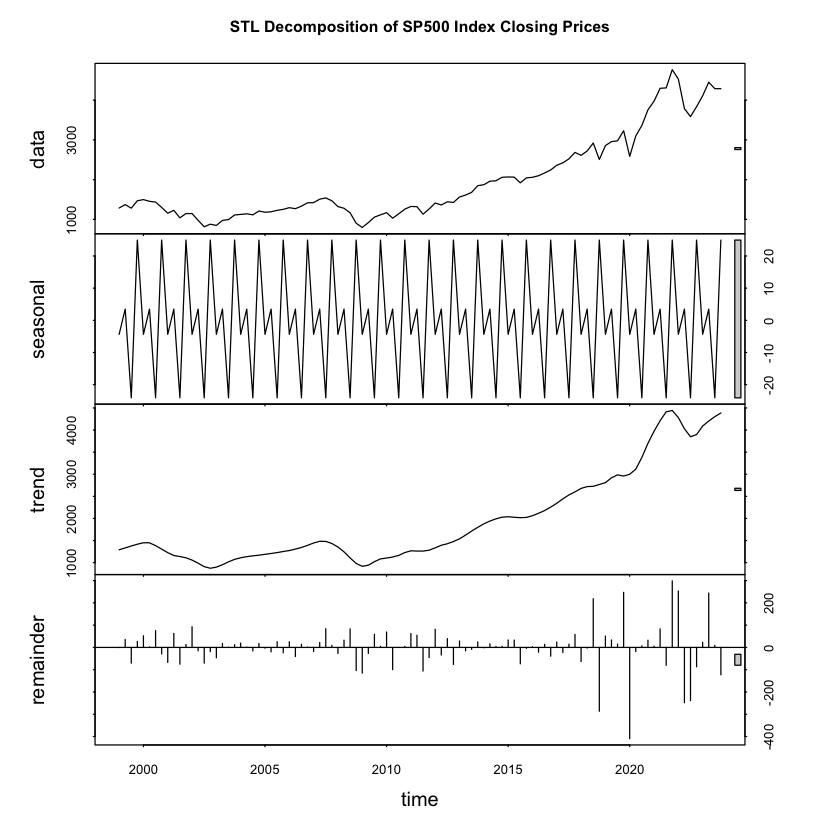

In [485]:
# Closing prices and Marker Indices to Time Series Objects

StartYear = 1999
StartQuarter = 1

AppleTimeSeries = ts(MergedData2$AAPL.Close, start = c(StartYear, StartQuarter), frequency = 4)
IBMTimeSeries = ts(MergedData2$IBM.Close, start = c(StartYear, StartQuarter), frequency = 4)
AmericanExpressTimeSeries = ts(MergedData2$AXP.Close, start = c(StartYear, StartQuarter), frequency = 4)
JPMorganChaseTimeSeries = ts(MergedData2$JPM.Close, start = c(StartYear, StartQuarter), frequency = 4)
ExxonMobilTimeSeries = ts(MergedData2$XOM.Close, start = c(StartYear, StartQuarter), frequency = 4)
OccidentalPetroleumTimeSeries = ts(MergedData2$OXY.Close, start = c(StartYear, StartQuarter), frequency = 4)
FinancialSectorTimeSeries = ts(MergedData2$XLF.Close, start = c(StartYear, StartQuarter), frequency = 4)
TechnologySectorTimeSeries = ts(MergedData2$XLK.Close, start = c(StartYear, StartQuarter), frequency = 4)
EnergySectorTimeSeries = ts(MergedData2$XLE.Close, start = c(StartYear, StartQuarter), frequency = 4)
GDPTimeSeries = ts(MergedData2$GDP, start = c(StartYear, StartQuarter), frequency = 4)
UnemploymentTimeSeries = ts(MergedData2$UNRATE, start = c(StartYear, StartQuarter), frequency = 4)
SP500TimeSeries = ts(MergedData2$GSPC.Close, start = c(StartYear, StartQuarter), frequency = 4)

# Time Series Objects Decomposition

Appledecomposition = stl(AppleTimeSeries, s.window = "periodic")
IBMdecomposition = stl(IBMTimeSeries, s.window = "periodic")
AmericanExpressdecomposition = stl(AmericanExpressTimeSeries, s.window = "periodic")
JPMorganChasedecomposition = stl(JPMorganChaseTimeSeries, s.window = "periodic")
ExxonMobildecomposition = stl(ExxonMobilTimeSeries, s.window = "periodic")
OccidentalPetroleumdecomposition = stl(OccidentalPetroleumTimeSeries, s.window = "periodic")
FinancialSectordecomposition = stl(FinancialSectorTimeSeries, s.window = "periodic")
TechnologySectordecomposition = stl(TechnologySectorTimeSeries, s.window = "periodic")
EnergySectordecomposition = stl(EnergySectorTimeSeries, s.window = "periodic")
GDPdecomposition = stl(GDPTimeSeries, s.window = "periodic")
Unemploymentdecomposition = stl(UnemploymentTimeSeries, s.window = "periodic")
SP500decomposition = stl(SP500TimeSeries, s.window = "periodic")

# Visualizations

plot(Appledecomposition, main = "STL Decomposition of Apple Closing Prices")
plot(IBMdecomposition, main = "STL Decomposition of IBM  Closing Prices")
plot(AmericanExpressdecomposition, main = "STL Decomposition of American Express Closing Prices")
plot(JPMorganChasedecomposition, main = "STL Decomposition of JPMorganChase Closing Prices")
plot(ExxonMobildecomposition, main = "STL Decomposition of Exxon Mobil Closing Prices")
plot(OccidentalPetroleumdecomposition, main = "STL Decomposition of Occidental Petroleum Closing Prices")
plot(FinancialSectordecomposition, main = "STL Decomposition of Financial Sector Index Closing Prices")
plot(TechnologySectordecomposition, main = "STL Decomposition of Technology Sector Index Closing Prices")
plot(EnergySectordecomposition, main = "STL Decomposition of Energy Sector Index Closing Prices")
plot(GDPdecomposition, main = "STL Decomposition of GDP")
plot(Unemploymentdecomposition, main = "STL Decomposition of Unemployment Rate")
plot(SP500decomposition, main = "STL Decomposition of SP500 Index Closing Prices")

In [486]:
# Numerical values for visualizations above

AppleSeasonal <- Appledecomposition$time.series[, "seasonal"]
cat("Apple Seasonal Component:\n")
print(AppleSeasonal)

AppleTrend <- Appledecomposition$time.series[, "trend"]
print("Apple Trend Component:")
print(AppleTrend)

AppleResidual <- Appledecomposition$time.series[, "remainder"]
print("Apple Residual Component:")
print(AppleResidual)

IBMSeasonal <- IBMdecomposition$time.series[, "seasonal"]
print("IBM Seasonal Component:")
print(IBMSeasonal)

IBMTrend <- IBMdecomposition$time.series[, "trend"]
print("IBM Trend Component:")
print(IBMTrend)

IBMResidual <- IBMdecomposition$time.series[, "remainder"]
print("IBM Residual Component:")
print(IBMResidual)

AmericanExpressSeasonal <- AmericanExpressdecomposition$time.series[, "seasonal"]
print("AmericanExpress Seasonal Component:")
print(AmericanExpressSeasonal)

AmericanExpressTrend <- AmericanExpressdecomposition$time.series[, "trend"]
print("AmericanExpress Trend Component:")
print(AmericanExpressTrend)

AmericanExpressResidual <- AmericanExpressdecomposition$time.series[, "remainder"]
print("AmericanExpress Residual Component:")
print(AmericanExpressResidual)

JPMorganChaseSeasonal <- JPMorganChasedecomposition$time.series[, "seasonal"]
print("JPMorganChase Seasonal Component:")
print(JPMorganChaseSeasonal)

JPMorganChaseTrend <- JPMorganChasedecomposition$time.series[, "trend"]
print("JPMorganChase Trend Component:")
print(JPMorganChaseTrend)

JPMorganChaseResidual <- JPMorganChasedecomposition$time.series[, "remainder"]
print("JPMorganChase Residual Component:")
print(JPMorganChaseResidual)

ExxonMobilSeasonal <- ExxonMobildecomposition$time.series[, "seasonal"]
print("ExxonMobil Seasonal Component:")
print(ExxonMobilSeasonal)

ExxonMobilTrend <- ExxonMobildecomposition$time.series[, "trend"]
print("ExxonMobil Trend Component:")
print(ExxonMobilTrend)

ExxonMobilResidual <- ExxonMobildecomposition$time.series[, "remainder"]
print("ExxonMobil Residual Component:")
print(ExxonMobilResidual)

OccidentalPetroleumSeasonal <- OccidentalPetroleumdecomposition$time.series[, "seasonal"]
print("OccidentalPetroleum Seasonal Component:")
print(OccidentalPetroleumSeasonal)

OccidentalPetroleumTrend <- OccidentalPetroleumdecomposition$time.series[, "trend"]
print("OccidentalPetroleum Trend Component:")
print(OccidentalPetroleumTrend)

OccidentalPetroleumResidual <- OccidentalPetroleumdecomposition$time.series[, "remainder"]
print("OccidentalPetroleum Residual Component:")
print(OccidentalPetroleumResidual)

FinancialSectorSeasonal <- FinancialSectordecomposition$time.series[, "seasonal"]
print("FinancialSector Seasonal Component:")
print(FinancialSectorSeasonal)

FinancialSectorTrend <- FinancialSectordecomposition$time.series[, "trend"]
print("FinancialSector Trend Component:")
print(FinancialSectorTrend)

FinancialSectorResidual <- FinancialSectordecomposition$time.series[, "remainder"]
print("FinancialSector Residual Component:")
print(FinancialSectorResidual)

TechnologySectorSeasonal <- TechnologySectordecomposition$time.series[, "seasonal"]
print("TechnologySector Seasonal Component:")
print(TechnologySectorSeasonal)

TechnologySectorTrend <- TechnologySectordecomposition$time.series[, "trend"]
print("TechnologySector Trend Component:")
print(TechnologySectorTrend)

TechnologySectorResidual <- TechnologySectordecomposition$time.series[, "remainder"]
print("TechnologySector Residual Component:")
print(TechnologySectorResidual)

EnergySectorSeasonal <- EnergySectordecomposition$time.series[, "seasonal"]
print("EnergySector Seasonal Component:")
print(EnergySectorSeasonal)

EnergySectorTrend <- EnergySectordecomposition$time.series[, "trend"]
print("EnergySector Trend Component:")
print(EnergySectorTrend)

EnergySectorResidual <- EnergySectordecomposition$time.series[, "remainder"]
print("EnergySector Residual Component:")
print(EnergySectorResidual)

GDPSeasonal <- GDPdecomposition$time.series[, "seasonal"]
print("GDP Seasonal Component:")
print(GDPSeasonal)

GDPTrend <- GDPdecomposition$time.series[, "trend"]
print("GDP Trend Component:")
print(GDPTrend)

GDPResidual <- GDPdecomposition$time.series[, "remainder"]
print("GDP Residual Component:")
print(GDPResidual)

UnemploymentSeasonal <- Unemploymentdecomposition$time.series[, "seasonal"]
print("Unemployment Seasonal Component:")
print(UnemploymentSeasonal)

UnemploymentTrend <- Unemploymentdecomposition$time.series[, "trend"]
print("Unemployment Trend Component:")
print(UnemploymentTrend)

UnemploymentResidual <- Unemploymentdecomposition$time.series[, "remainder"]
print("Unemployment Residual Component:")
print(UnemploymentResidual)

SP500Seasonal <- SP500decomposition$time.series[, "seasonal"]
print("SP500 Seasonal Component:")
print(SP500Seasonal)

SP500Trend <- SP500decomposition$time.series[, "trend"]
print("SP500 Trend Component:")
print(SP500Trend)

SP500Residual <- SP500decomposition$time.series[, "remainder"]
print("SP500 Residual Component:")
print(SP500Residual)

Apple Seasonal Component:
            Qtr1        Qtr2        Qtr3        Qtr4
1999 -0.20261105 -0.06254368  0.06874580  0.19640656
2000 -0.20261105 -0.06254368  0.06874580  0.19640656
2001 -0.20261105 -0.06254368  0.06874580  0.19640656
2002 -0.20261105 -0.06254368  0.06874580  0.19640656
2003 -0.20261105 -0.06254368  0.06874580  0.19640656
2004 -0.20261105 -0.06254368  0.06874580  0.19640656
2005 -0.20261105 -0.06254368  0.06874580  0.19640656
2006 -0.20261105 -0.06254368  0.06874580  0.19640656
2007 -0.20261105 -0.06254368  0.06874580  0.19640656
2008 -0.20261105 -0.06254368  0.06874580  0.19640656
2009 -0.20261105 -0.06254368  0.06874580  0.19640656
2010 -0.20261105 -0.06254368  0.06874580  0.19640656
2011 -0.20261105 -0.06254368  0.06874580  0.19640656
2012 -0.20261105 -0.06254368  0.06874580  0.19640656
2013 -0.20261105 -0.06254368  0.06874580  0.19640656
2014 -0.20261105 -0.06254368  0.06874580  0.19640656
2015 -0.20261105 -0.06254368  0.06874580  0.19640656
2016 -0.20261105 -0.

The seasonal component shows that Apple tends to be traded at a higher value in the second half of the year. Apple's closing price seasonal component is a consistent pattern, which shows that the Q1 & Q2 Apple closing price tends to be lower than average, with values of Q1 = -0.20 and Q2 = - 0.06. In the second half of the year, these values are positive with Q3 = 0.068 and Q4 = 0.196. Overall, these seasonal fluctuations are very small in a holistic picture, yet they show that during the holiday season and major Apple events in September with product launches, the Seasonal component captures positive movement in the closing price. In residuals, in Apple's closing price, there are specific years like 2020 (COVID-19 pandemic) and 2022 that show large deviations across multiple quarters, which can reflect broader economic impacts to the company and/or possibly company-specific strategies or issues, that need to be addressed. In 2023 Apple's closing price still holds some fluctuations in residuals from quarter to quarter, values varying from 25.27 to -8.97 from the expected value, indicating some volatility in the stock.

IBM closing price seasonal variations stay consistent over the review period. In Q1 the prices are considerably higher than in Q4, which is when they are at their lowest. On average the difference between prices in Q1 and Q4 is 2.84 $. For Q2 and Q3 the seasonal impact is much lower for the closing price. In IBM residuals, IBM experienced a significant downturn in Q4 2018 with a record-breaking -20.07. The historically bad quarter was followed by a great performance in Q3 2018, which was 13.40 and at the same time the highest positive since Q4 in 2001, where IBM beat the trend and seasonally expected value by 18.46. Specific years like 1999, 2001, and 2020 show large deviations across multiple quarters, reflecting broader economic impacts such as the dot-com bubble in 1999-2000 and the Pandemic in 2020. 

The seasonal values for American Express show consistent patterns across all the years of the review period. Q2 and Q4 are consistently positive, which suggests that the closing price tends to be higher during these quarters, and it's the complete opposite for Q1 and Q3. Overall, even though changes are present in the seasonal component, the values are relatively small for American Express. In American Express residuals, there is major volatility. The highest negative outlier in the whole time series in residuals is in Q1 of 2020, which is the starting quarter of the pandemic.  Notable is that the highest positive outlier is in 2022 Q1 with 26.11, and rest quarters of 2022 the residuals have been significantly negative, this is the same pattern with Apple, which suggests wider trends rather than company-specific factors. The past year of the American Express residuals has shown still present volatility, with residual values varying from 16.17 to -5.83.

The seasonal component of JPMorgan Chase's stock prices remains stable across all quarters from 1999 to 2023. In Q4 the closing price tends to be higher than the other quarters, with Q3 being the lowest. In JPMorgan Chase residuals Q1 in 2020 shows a significant negative outlier, which is most likely due to the pandemic, as previously discussed in the case of other companies. This comes right after the Q4 positive outlier of 23.37. The down trend from Q1, to the rest of the year in 2022 is present also in JPMorgan Chase. In 2023 residuals show some deviations of JPMorgan Chase’s stock price from expected patterns, these in essence are in the normal range.

In seasonal component of Exxon Mobil values suggests that the seasonal effects on ExxonMobil's closing prices do not significantly have an impact at any given quarter, with all quarters having a value under 1 in this component. In Exxon Mobil residual, both negative and positive maximum values are much lower than the companies discussed before. The highest negative of the whole time series is at the start of the pandemic, Q1 of 2020. The downtrend of Q1 to the rest of the year in 2022 is present also in Exxon Mobil. Last year of review period, the residual variations were small ranging from -4.23 in Q2 to 3.96 in Q3, indicating low volatility.

For Occidental Petroleum the seasonal component shows that Q2 tends to hold the highest values for the closing price of Occidental Petroleum, with all other quarters slightly negative. In Occidental Petroleum residuals, the 2020 Q1 residual value is -11.87. Along with 2020, in 2011 large deviations are present across multiple quarters, reflecting broader economic impacts and possibly company-specific strategies or issues. In 2011 Q2 residual value was 7.81 and in Q3 of the same year, it’s been -18.45. The same kind of dip is notable in Exxon Mobil, which operates in the same field, indicating industry-based fluctuation. In the most recent year of 2023, Occidental Petroleum residuals have large deviations on residuals, varying between 25.27 to -8.97. On the 2nd of August, Occidental Petroleum published positive news regarding cash flows, production lines and stock buybacks, which explain the large positive residuals in that quarter.

The seasonal component shows that seasonal effects have been extremely small for the Financial Sector Index, which indicates that there in essence are not seasonal trends that affect the Financial Sector Index in a major way. In Financial Sector Index residuals, the values are lower than for the individual companies, this represents the fact of volatility being lower in the case of index rather than individual stocks. 2008 and 2020 hold deviations that align with broader economic events of the financial crisis and pandemic. In the past year the fluctuations have been under 1.0, which indicates low volatility Financial Sector Index, and that the changes in closing price are mostly expected values that are considered in trend and seasonal components.

Seasonal fluctuations have been low for the Technology Sector Index as well, with no major seasonal effects on closing price. With the Technology Sector Index, the residuals have been varying significantly more than with the Financial Sector Index. Notable is that in 2008, the residuals do not show the impact of the Financial Crisis, yet it is for the most part included in the downward trend. Which started in the early 2000s and lasted until 2010. The pandemic year of 2020 is presented in residuals however, especially Q1. The previously mentioned negative value increase in residuals from Q1 to Q2 and rest of the year in 2022 is also present in the Technology Sector, with Q1 value of 9.27 to Q2 of -10.78 and Q3 of -10.02. In the past year, the Technology Sector index has had both large positive and negative residuals, indicating fluctuating performance likely due to rapid technological changes and market dynamics.

The seasonal component shows that in Q2 Energy Sector Index is traded higher on average than it is in Q3. In Q1 and Q4 the price is not affected by seasonal trends that much. With Energy Sector Index residuals, larger deviations between consecutive quarters are present specifically in 2008, 2011 and 2020 reflecting significant economic impacts, such as the financial crisis and pandemic. The 2022 Q1 to Q2 deviation is present in the Energy Sector Index also. In the most recent year, the residuals have been varying slightly less, only Q2 2023 being higher at 3.5, Indicating performance has been what is expected with low volatility.

For GDP seasonal component shows that Q1 has a negative seasonal effect and in Q3 the seasonal effects are positive. Significant negative seasonal effects on Q1 can be due to the first quarter often seeing a slowdown after the end-of-year holiday season, lower consumer spending, and reduced production activities. With GDP, the residuals are low for most of the review period. Q1 of 2020 shows significant negative residuals, which is due to the pandemic. Along with 2020, the residuals have some variation during financial crisis years but other than that, they have not been varying between the quarters much, which indicates GDP reaching its expected values. 

The seasonal effects are not mentionable high for the Unemployment Rate, which indicates that the Unemployment rate is not affected by seasonal changes. With the Unemployment Rate, the residuals have been varying significantly in 2008 and 2020. These are due to the financial crisis and pandemic. In 2008 the residuals for the Unemployment Rate were -4.07 in Q1 and 14.16 in Q2, this is a tremendous increase. The highest fluctuation between quarters is from 2019 Q4 of 10.14 to -13.23 in 2020 Q1 as expected. Positive outliers, such as in 2008 Q2 and 2022 Q1, indicate periods of exceptional growth or market recovery.

For SP500, the seasonal component shows low seasonal effects in Q1 and Q2. Q3 holds a slight negative seasonal effect, which is followed by Q4 slight positive, which indicates increased activity towards the end of the fiscal year, including year-end tax planning, holiday season consumer spending, and optimistic market sentiment heading into the new year. With SP500 Index, the residuals confirm earlier observations with market conditions and stock performances. Most major quarter-to-quarter fluctuations happen in 2008, 2011 and 2020. Q1 of 2022 seems to unexpectedly strong quarter for market performance, most likely due to both economic and market growth due to the end of the pandemic. Strong performance in 2022 Q1 is present in multiple individual stocks as previously mentioned. Q2 in 2022 for SP500 confirms, that the drop from Q1 to Q2 is more likely to be a market condition and economic environment problem rather than a company-specific, with SP500 Q2 2022 being -247.75 after a great first quarter for the year.

# 6. Stationary Tests

Stationary was tested with ADF test (Augmented Dickey-Fuller Test) and complemented with KPSS test (Kwiatkowski–Phillips–Schmidt–Shin Test).

In [487]:
# ADF Testing

AppleClosing = MergedData2$AAPL.Close
adftest1 = ur.df(AppleClosing, type = "trend", lags = 4)
summary(adftest1)

IBMClosing = MergedData2$IBM.Close
adftest2 = ur.df(IBMClosing, type = "trend", lags = 4)
summary(adftest2)

AmericanExpressClosing = MergedData2$AXP.Close
adftest3 = ur.df(AmericanExpressClosing, type = "trend", lags = 4)
summary(adftest3)

JPMorganChaseClosing = MergedData2$JPM.Close
adftest4 = ur.df(JPMorganChaseClosing, type = "trend", lags = 4)
summary(adftest4)

ExxonMobilClosing = MergedData2$XOM.Close
adftest5 = ur.df(ExxonMobilClosing, type = "trend", lags = 4)
summary(adftest5)

OccidentalPetroleumClosing = MergedData2$OXY.Close
adftest6 = ur.df(OccidentalPetroleumClosing, type = "trend", lags = 4)
summary(adftest6)

FinancialSectorClosing = MergedData2$XLF.Close
adftest7 = ur.df(FinancialSectorClosing, type = "trend", lags = 4)
summary(adftest7)

TechnologySectorClosing = MergedData2$XLK.Close
adftest8 = ur.df(TechnologySectorClosing, type = "trend", lags = 4)
summary(adftest8)

EnergySectorClosing = MergedData2$XLE.Close
adftest9 = ur.df(EnergySectorClosing, type = "trend", lags = 4)
summary(adftest9)

GDPstationary = MergedData2$GDP
adftest10 = ur.df(GDPstationary, type = "trend", lags = 4)
summary(adftest10)

Unemploymentstationary = MergedData2$UNRATE
adftest11 = ur.df(Unemploymentstationary, type = "trend", lags = 4)
summary(adftest11)

SP500Closing = MergedData2$GSPC.Close
adftest12 = ur.df(SP500Closing, type = "trend", lags = 4)
summary(adftest12)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.560  -2.529   0.019   1.078  32.619 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -2.55841    2.33553  -1.095   0.2763  
z.lag.1      0.02354    0.03537   0.665   0.5075  
tt           0.10055    0.05649   1.780   0.0786 .
z.diff.lag1 -0.15584    0.10972  -1.420   0.1590  
z.diff.lag2 -0.24852    0.11128  -2.233   0.0281 *
z.diff.lag3 -0.28306    0.11498  -2.462   0.0158 *
z.diff.lag4 -0.30014    0.12261  -2.448   0.0164 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.863 on 88 degrees of freedom
Multiple R-squared:  0.1771,	Adjusted R-squared:  0.121 
F-statistic: 3.157 on 6 and 88 DF,  p-value: 0.007496


Value of test


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.349  -6.049   0.934   8.259  28.893 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  7.70422    5.15287   1.495   0.1385  
z.lag.1     -0.08607    0.04995  -1.723   0.0883 .
tt           0.06487    0.06061   1.070   0.2874  
z.diff.lag1 -0.24202    0.10933  -2.214   0.0294 *
z.diff.lag2  0.02222    0.11192   0.199   0.8431  
z.diff.lag3  0.02811    0.11152   0.252   0.8015  
z.diff.lag4  0.03209    0.10201   0.315   0.7538  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.94 on 88 degrees of freedom
Multiple R-squared:  0.1152,	Adjusted R-squared:  0.05484 
F-statistic: 1.909 on 6 and 88 DF,  p-value: 0.08812


Value of tes


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.538  -4.459   1.405   5.064  29.803 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.39283    2.35283   0.167   0.8678  
z.lag.1     -0.12281    0.05823  -2.109   0.0378 *
tt           0.18632    0.07813   2.385   0.0192 *
z.diff.lag1  0.01112    0.10652   0.104   0.9171  
z.diff.lag2  0.07248    0.11005   0.659   0.5119  
z.diff.lag3 -0.04063    0.11028  -0.368   0.7135  
z.diff.lag4 -0.14630    0.11034  -1.326   0.1883  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.37 on 88 degrees of freedom
Multiple R-squared:  0.1009,	Adjusted R-squared:  0.0396 
F-statistic: 1.646 on 6 and 88 DF,  p-value: 0.144


Value of test-s


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.563  -3.097   0.793   4.406  19.828 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.45598    2.16569  -0.672  0.50316   
z.lag.1     -0.11603    0.05302  -2.188  0.03129 * 
tt           0.20012    0.06768   2.957  0.00399 **
z.diff.lag1 -0.06961    0.10356  -0.672  0.50321   
z.diff.lag2  0.05117    0.09901   0.517  0.60657   
z.diff.lag3 -0.23443    0.09880  -2.373  0.01984 * 
z.diff.lag4 -0.25051    0.10126  -2.474  0.01528 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.539 on 88 degrees of freedom
Multiple R-squared:  0.2066,	Adjusted R-squared:  0.1525 
F-statistic:  3.82 on 6 and 88 DF,  p-value: 0.001976


Valu


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.512  -3.377   0.363   4.149  16.041 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  6.02041    2.90271   2.074   0.0410 *
z.lag.1     -0.12410    0.05131  -2.418   0.0176 *
tt           0.06227    0.03575   1.742   0.0850 .
z.diff.lag1 -0.06851    0.10579  -0.648   0.5189  
z.diff.lag2  0.15951    0.10563   1.510   0.1346  
z.diff.lag3  0.24952    0.10726   2.326   0.0223 *
z.diff.lag4  0.01617    0.10828   0.149   0.8817  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.55 on 88 degrees of freedom
Multiple R-squared:  0.1188,	Adjusted R-squared:  0.05871 
F-statistic: 1.977 on 6 and 88 DF,  p-value: 0.07741


Value of test


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.3065  -3.4276  -0.3202   3.9230  25.9957 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  3.912030   2.307321   1.695   0.0935 .
z.lag.1     -0.062893   0.038997  -1.613   0.1104  
tt           0.001209   0.038298   0.032   0.9749  
z.diff.lag1 -0.073947   0.106505  -0.694   0.4893  
z.diff.lag2  0.024931   0.107017   0.233   0.8163  
z.diff.lag3  0.029881   0.107018   0.279   0.7807  
z.diff.lag4 -0.062964   0.106202  -0.593   0.5548  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.986 on 88 degrees of freedom
Multiple R-squared:  0.05247,	Adjusted R-squared:  -0.01214 
F-statistic: 0.8121 on 6 and 88 DF,  p-value: 0


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9091 -0.7472  0.1087  1.5040  5.3430 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.979111   0.861833   1.136   0.2590  
z.lag.1     -0.068771   0.040731  -1.688   0.0949 .
tt           0.012561   0.009668   1.299   0.1972  
z.diff.lag1  0.070531   0.105465   0.669   0.5054  
z.diff.lag2  0.115817   0.105712   1.096   0.2762  
z.diff.lag3  0.038429   0.105267   0.365   0.7159  
z.diff.lag4 -0.108330   0.106242  -1.020   0.3107  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.358 on 88 degrees of freedom
Multiple R-squared:  0.06409,	Adjusted R-squared:  0.0002779 
F-statistic: 1.004 on 6 and 88 DF,  p-value: 0.4277


Va


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.1201  -2.6701   0.1801   2.3600  25.1223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.60344    1.64387  -2.800 0.006274 ** 
z.lag.1     -0.03204    0.02934  -1.092 0.277783    
tt           0.15166    0.04274   3.549 0.000624 ***
z.diff.lag1  0.02753    0.10295   0.267 0.789760    
z.diff.lag2 -0.05479    0.10106  -0.542 0.589103    
z.diff.lag3 -0.24819    0.10315  -2.406 0.018217 *  
z.diff.lag4 -0.26468    0.10983  -2.410 0.018044 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.091 on 88 degrees of freedom
Multiple R-squared:  0.2435,	Adjusted R-squared:  0.1919 
F-statistic:  4.72 on 6 and 88 DF,  p-valu


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.124  -3.367   0.126   4.983  17.678 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  5.063723   2.601278   1.947   0.0548 .
z.lag.1     -0.130782   0.056866  -2.300   0.0238 *
tt           0.058760   0.038714   1.518   0.1327  
z.diff.lag1 -0.004708   0.107000  -0.044   0.9650  
z.diff.lag2  0.033949   0.107306   0.316   0.7525  
z.diff.lag3  0.136278   0.107024   1.273   0.2063  
z.diff.lag4 -0.047380   0.107202  -0.442   0.6596  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.938 on 88 degrees of freedom
Multiple R-squared:  0.08174,	Adjusted R-squared:  0.01913 
F-statistic: 1.306 on 6 and 88 DF,  p-value: 0.2631


Valu


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-2101.33   -64.51    17.42    65.22  1222.72 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  24.866630 325.729826   0.076    0.939
z.lag.1       0.002005   0.039131   0.051    0.959
tt            2.497284   6.081907   0.411    0.682
z.diff.lag1  -0.108248   0.116192  -0.932    0.354
z.diff.lag2   0.041211   0.117622   0.350    0.727
z.diff.lag3   0.062942   0.117392   0.536    0.593
z.diff.lag4  -0.005132   0.115550  -0.044    0.965

Residual standard error: 300.8 on 88 degrees of freedom
Multiple R-squared:  0.07967,	Adjusted R-squared:  0.01692 
F-statistic:  1.27 on 6 and 88 DF,  p-value: 0.2796


Value of test-statistic is: 0.0512 4.7225 2.4247 

Critical values fo


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6748 -0.3749 -0.2305  0.1063 10.6165 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.225460   0.518300   2.364   0.0203 *
z.lag.1     -0.171791   0.073965  -2.323   0.0225 *
tt          -0.004347   0.004741  -0.917   0.3617  
z.diff.lag1 -0.085781   0.114295  -0.751   0.4549  
z.diff.lag2 -0.130674   0.113809  -1.148   0.2540  
z.diff.lag3  0.015609   0.110148   0.142   0.8876  
z.diff.lag4  0.022266   0.106730   0.209   0.8352  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.254 on 88 degrees of freedom
Multiple R-squared:  0.1282,	Adjusted R-squared:  0.06872 
F-statistic: 2.156 on 6 and 88 DF,  p-value: 0.05483


Valu


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-713.04  -61.49   23.15   78.11  526.08 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -29.24199   41.74944  -0.700   0.4855  
z.lag.1      -0.05855    0.03712  -1.578   0.1183  
tt            3.50852    1.33685   2.624   0.0102 *
z.diff.lag1  -0.02482    0.10438  -0.238   0.8126  
z.diff.lag2  -0.01142    0.10428  -0.110   0.9130  
z.diff.lag3  -0.11399    0.10463  -1.089   0.2789  
z.diff.lag4  -0.19485    0.10532  -1.850   0.0677 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 179.7 on 88 degrees of freedom
Multiple R-squared:  0.1208,	Adjusted R-squared:  0.06089 
F-statistic: 2.016 on 6 and 88 DF,  p-value: 0.07187


Valu

In [488]:
# KPSS Testing

KPSSApple = kpss.test(MergedData2$AAPL.Close)
KPSSIBM = kpss.test(MergedData2$IBM.Close)
KPSSAmex = kpss.test(MergedData2$AXP.Close)
KPSSJPM = kpss.test(MergedData2$JPM.Close)
KPSSExxonMobil = kpss.test(MergedData2$XOM.Close)
KPSSOccidental = kpss.test(MergedData2$OXY.Close)
KPSSFinancial = kpss.test(MergedData2$XLF.Close)
KPSSTech = kpss.test(MergedData2$XLK.Close)
KPSSEnergy = kpss.test(MergedData2$XLE.Close)
KPSSGDP = kpss.test(MergedData2$GDP)
KPSSUnemployment = kpss.test(MergedData2$UNRATE)
KPSSSP500 = kpss.test(MergedData2$GSPC.Close)

KPSSApple
KPSSIBM
KPSSAmex
KPSSJPM
KPSSExxonMobil
KPSSOccidental
KPSSFinancial
KPSSTech
KPSSEnergy
KPSSGDP
KPSSUnemployment
KPSSSP500

Warning message in kpss.test(MergedData2$AAPL.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$IBM.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$AXP.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$JPM.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$XOM.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$OXY.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$XLK.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$XLE.Close):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$GDP):
“p-value smaller than printed p-value”
Warning message in kpss.test(MergedData2$UNRATE):
“p-value greater than printed p-value”
Warning message in kpss.test(MergedData2$GSPC.Close):
“p-value smaller than printed p-va


	KPSS Test for Level Stationarity

data:  MergedData2$AAPL.Close
KPSS Level = 1.4714, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$IBM.Close
KPSS Level = 0.99092, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$AXP.Close
KPSS Level = 1.6427, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$JPM.Close
KPSS Level = 1.6148, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$XOM.Close
KPSS Level = 1.0259, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$OXY.Close
KPSS Level = 0.8288, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$XLF.Close
KPSS Level = 0.63084, Truncation lag parameter = 4, p-value = 0.01983



	KPSS Test for Level Stationarity

data:  MergedData2$XLK.Close
KPSS Level = 1.3956, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$XLE.Close
KPSS Level = 1.1003, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$GDP
KPSS Level = 2.0016, Truncation lag parameter = 4, p-value = 0.01



	KPSS Test for Level Stationarity

data:  MergedData2$UNRATE
KPSS Level = 0.2566, Truncation lag parameter = 4, p-value = 0.1



	KPSS Test for Level Stationarity

data:  MergedData2$GSPC.Close
KPSS Level = 1.6564, Truncation lag parameter = 4, p-value = 0.01


In ADF Test Apple, JPMorgan Chase and Technology Sector Index Closing Prices got a P-value <0.05 which led to reject the null hypothesis, suggesting that the time series is stationary.
All other variables got P-values >0.5 suggesting data to be non-stationary.

ADF test was complemented with the KPSS test, where all variables except the Unemployment Rate got a P-value <0.5 suggesting that the time series to be non-stationary.

Stationary tests show conflicting results for Apple, JPMorgan Chase, Technology Sector Index, and Unemployment Rate. All other variables are suggested to be non-stationary by both tests.

Stationary of Time Series affects predictive modeling and choice of model. With a variety of data being non-stationary, the model of choice will be Long Short-Term Memory, LSTM models which can handle both stationary and non-stationary data.

## 7. Autocorrelation Analysis

Autocorrelation analysis was done to test time series data for possible feature engineering needs.
Autocorrelation was tested with ACF (Autocorrelation Function), PACF (Partial Autocorrelation Function) and with Lagplot visualization.

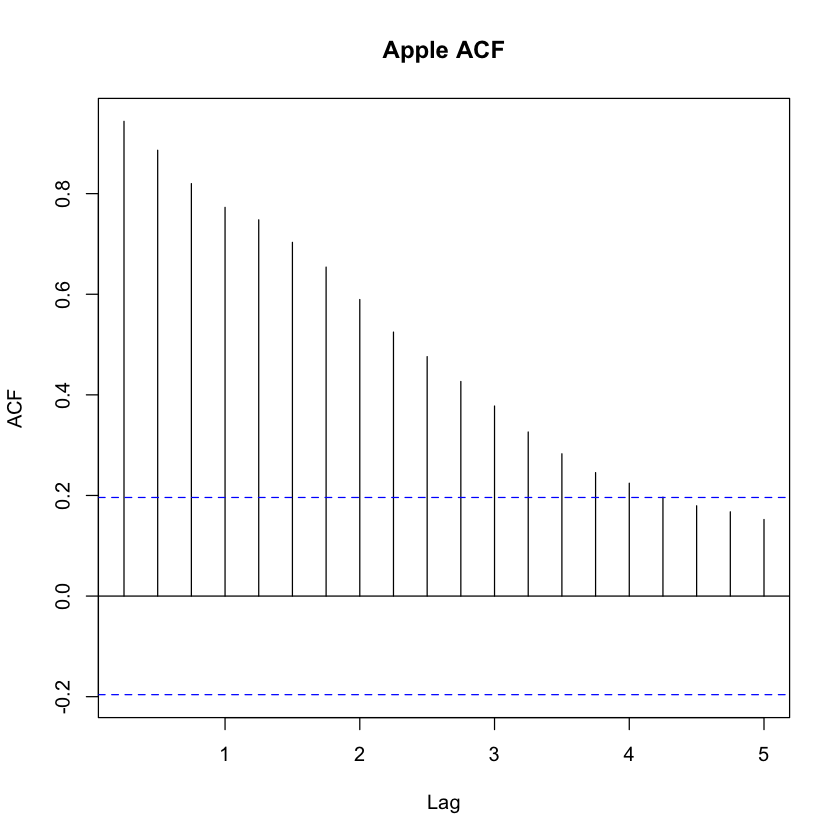

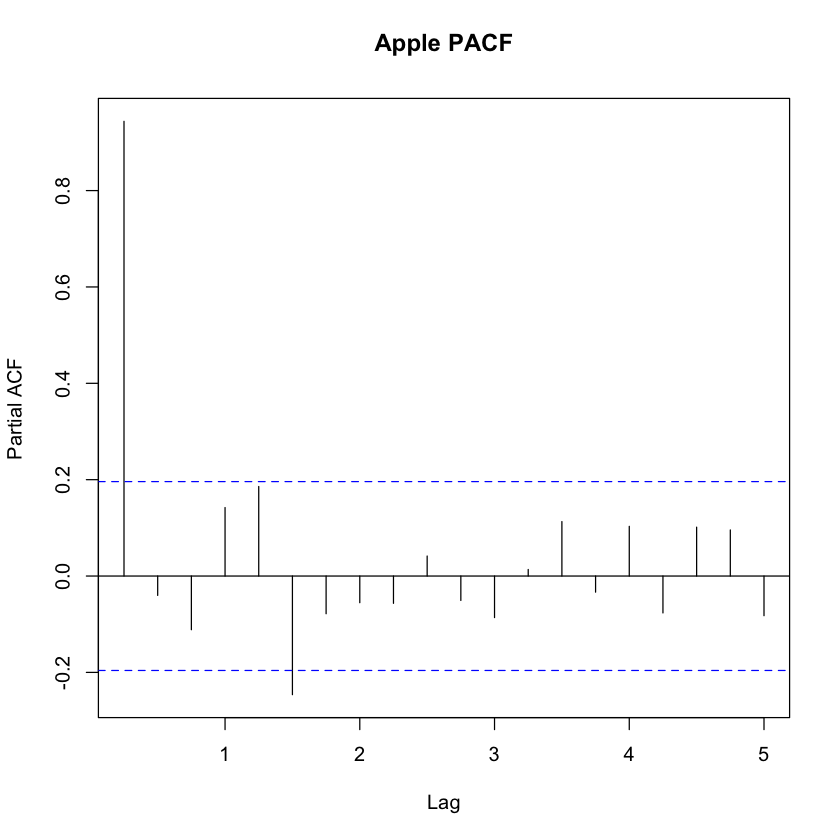

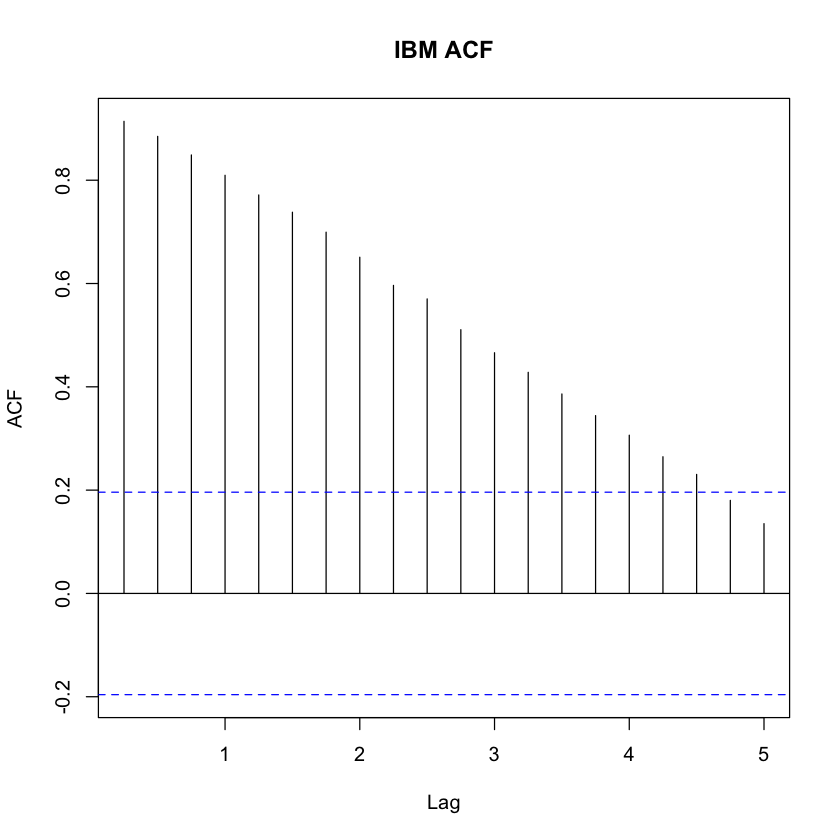

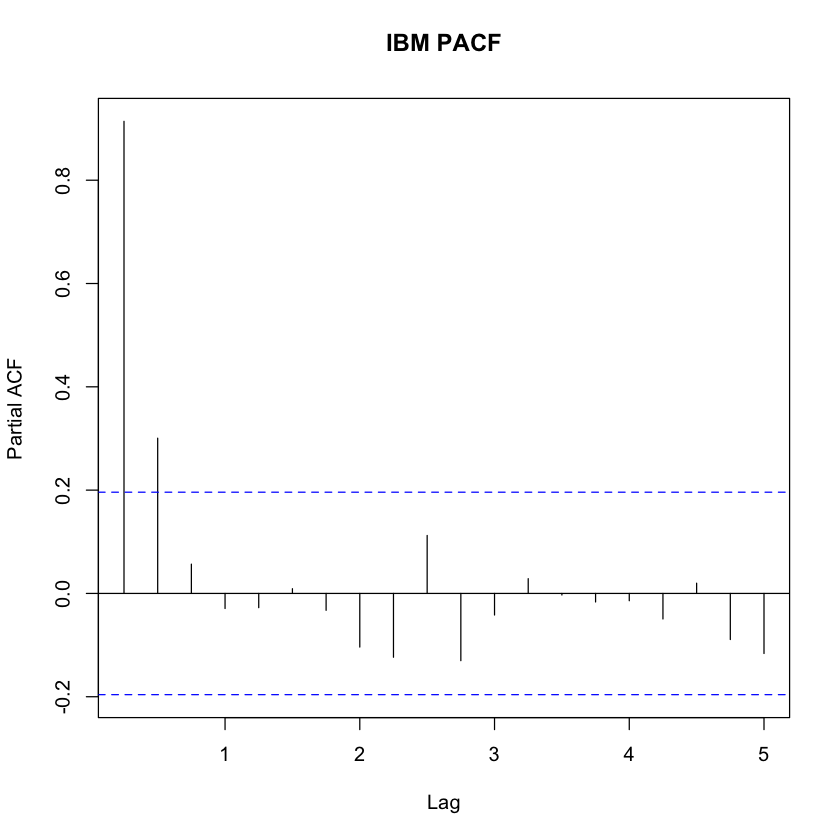

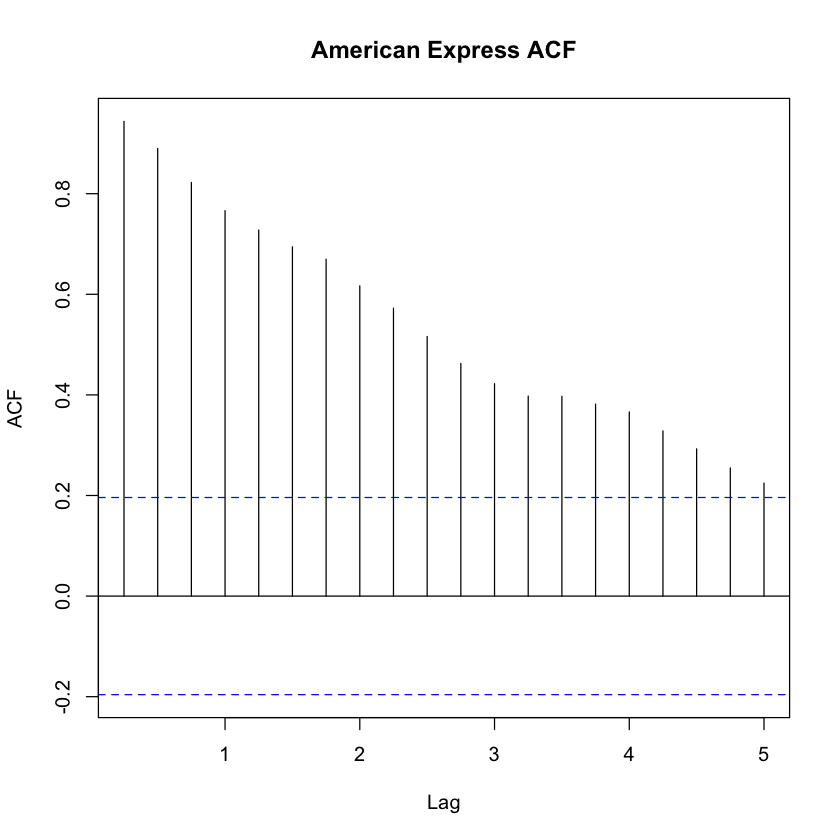

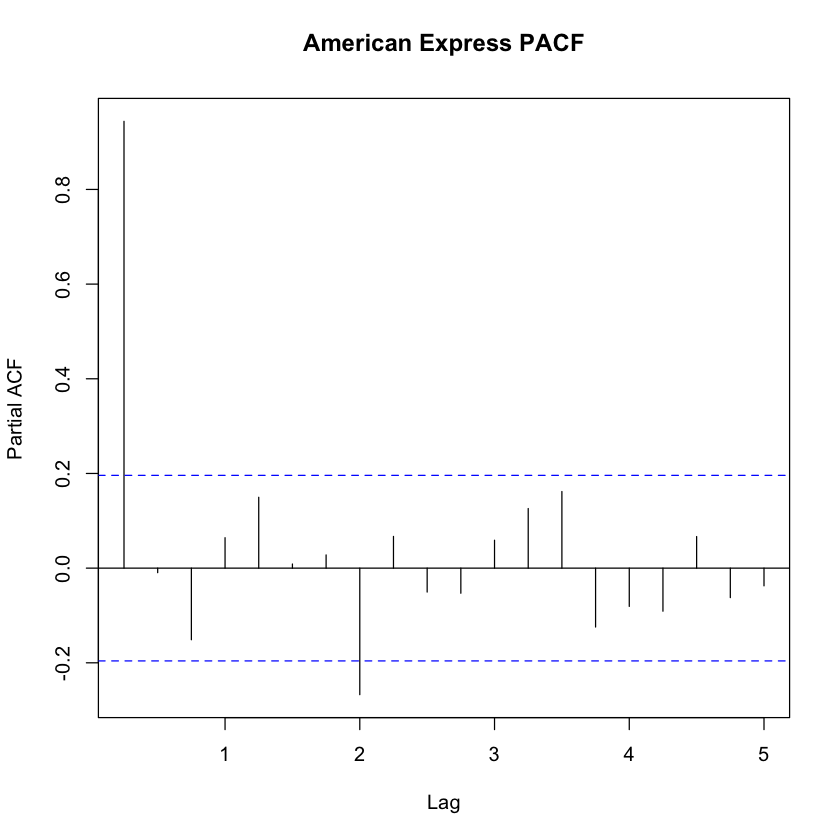

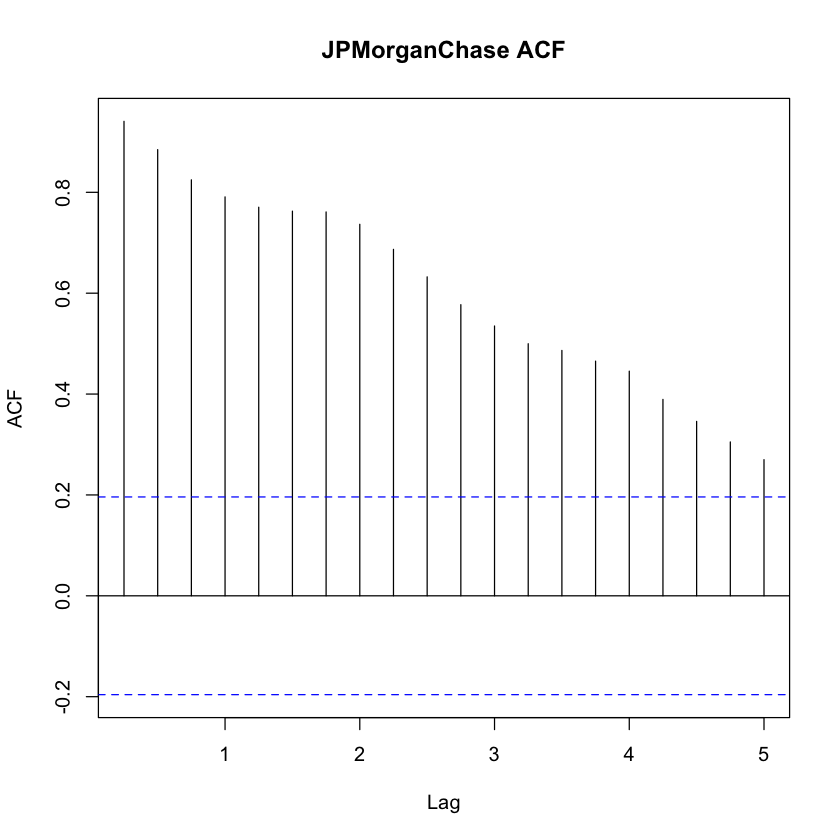

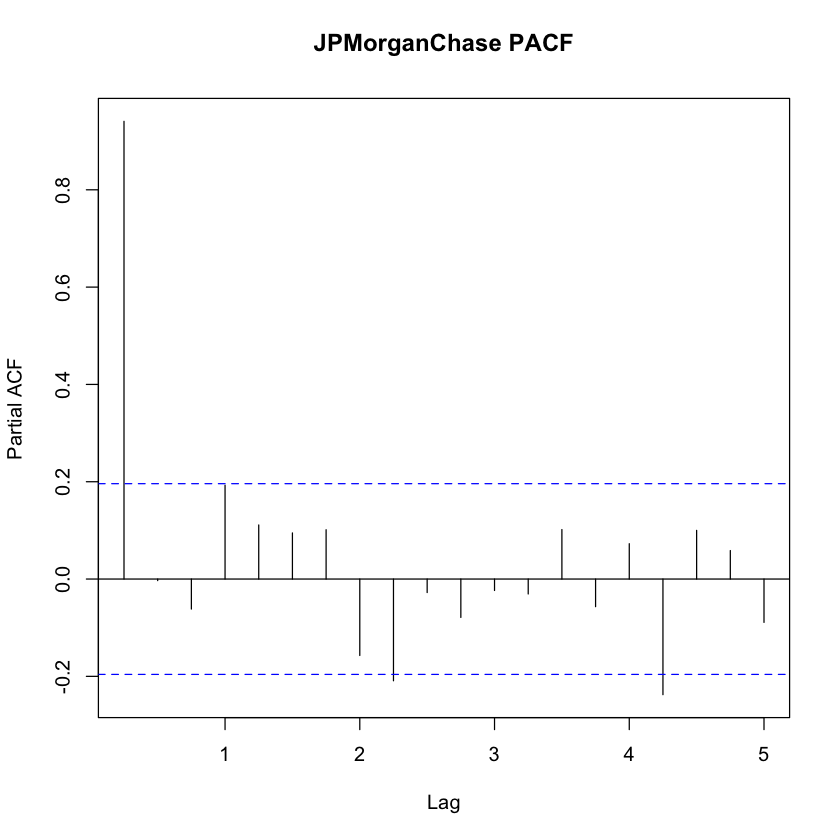

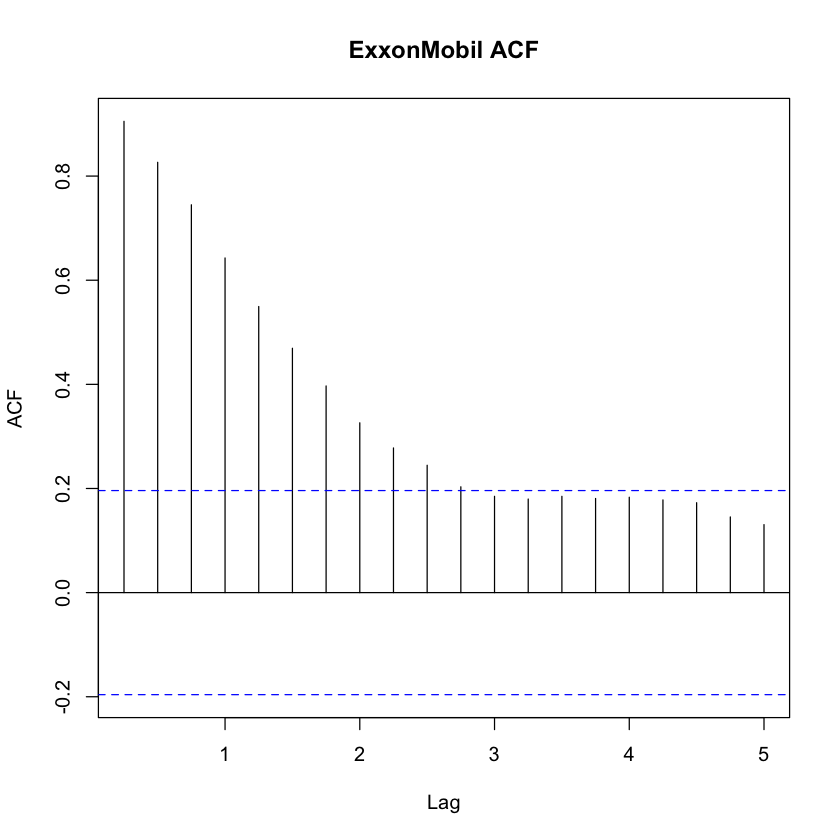

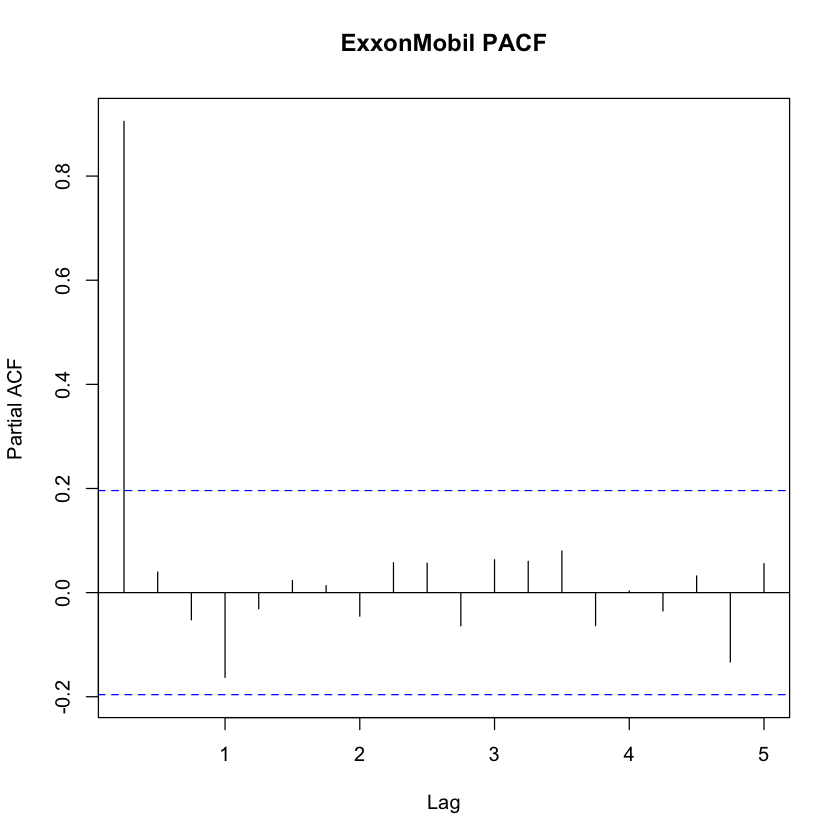

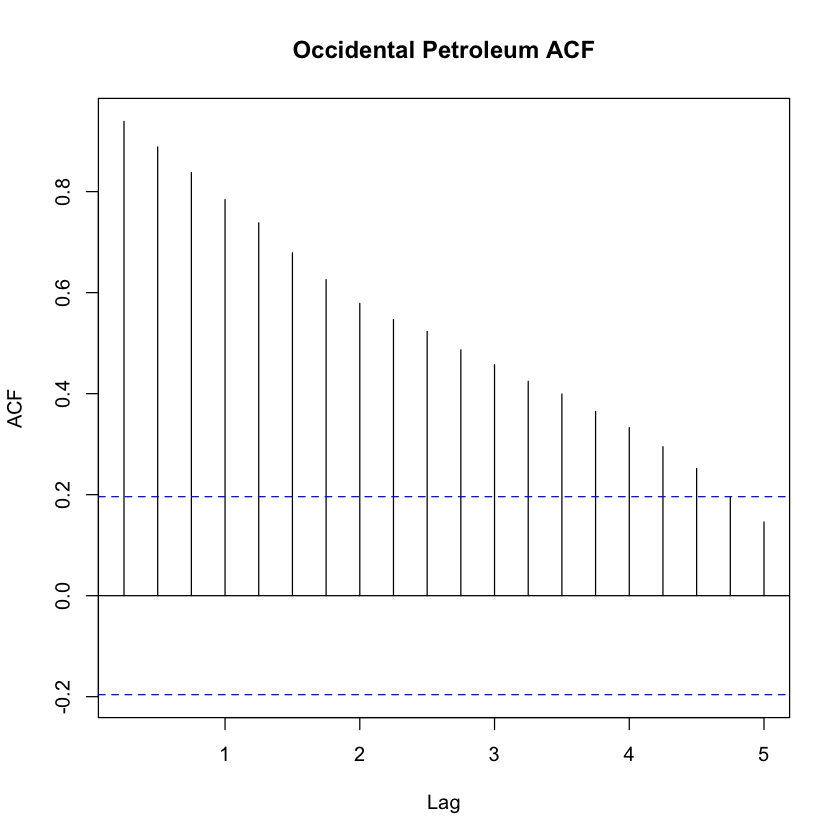

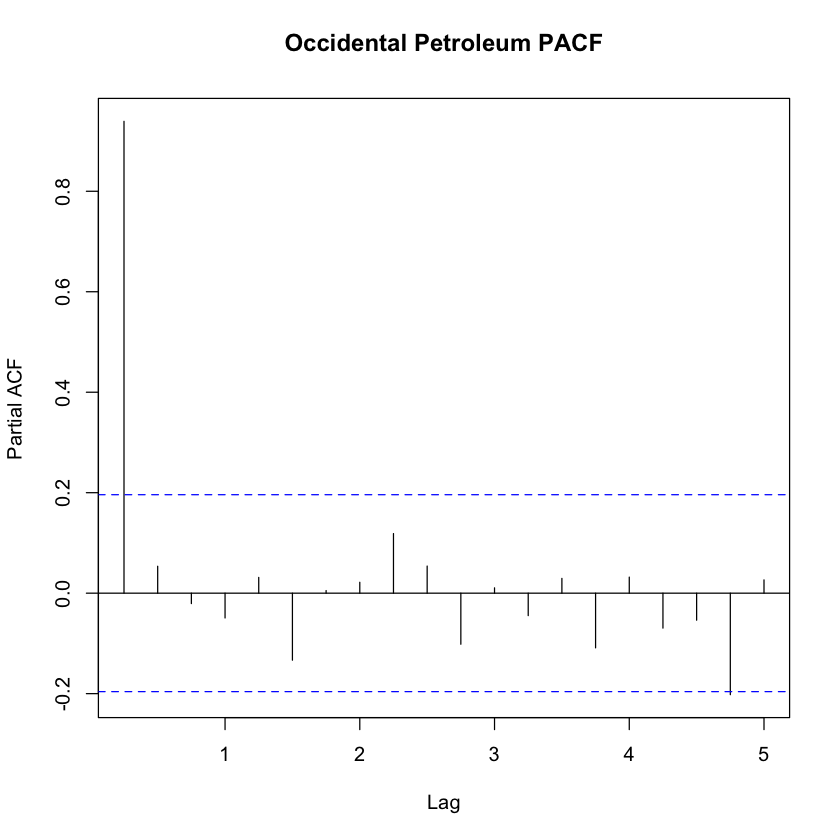

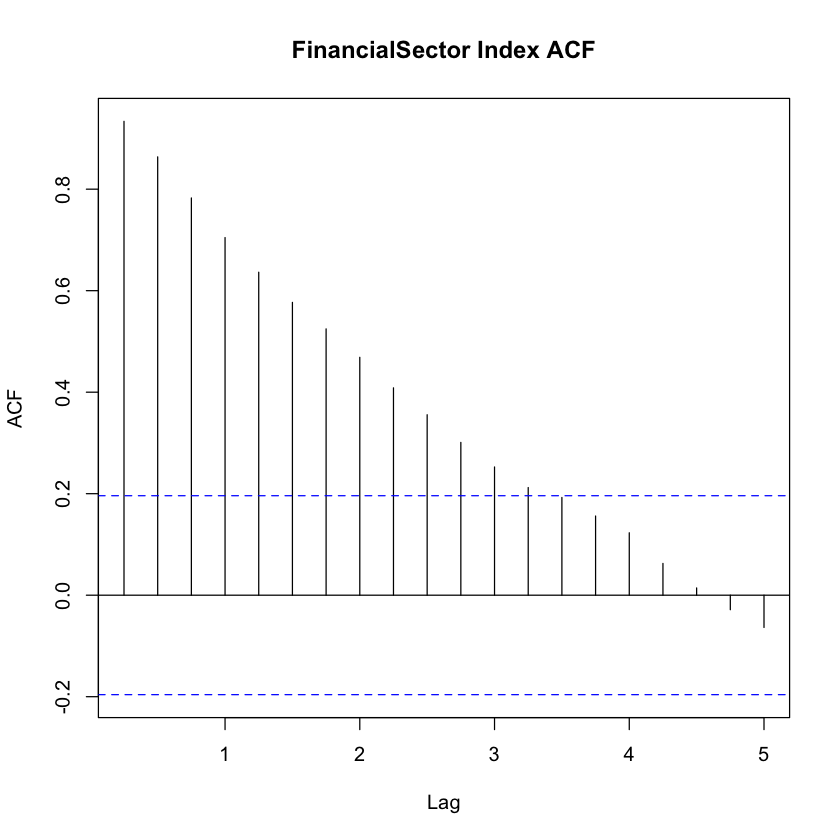

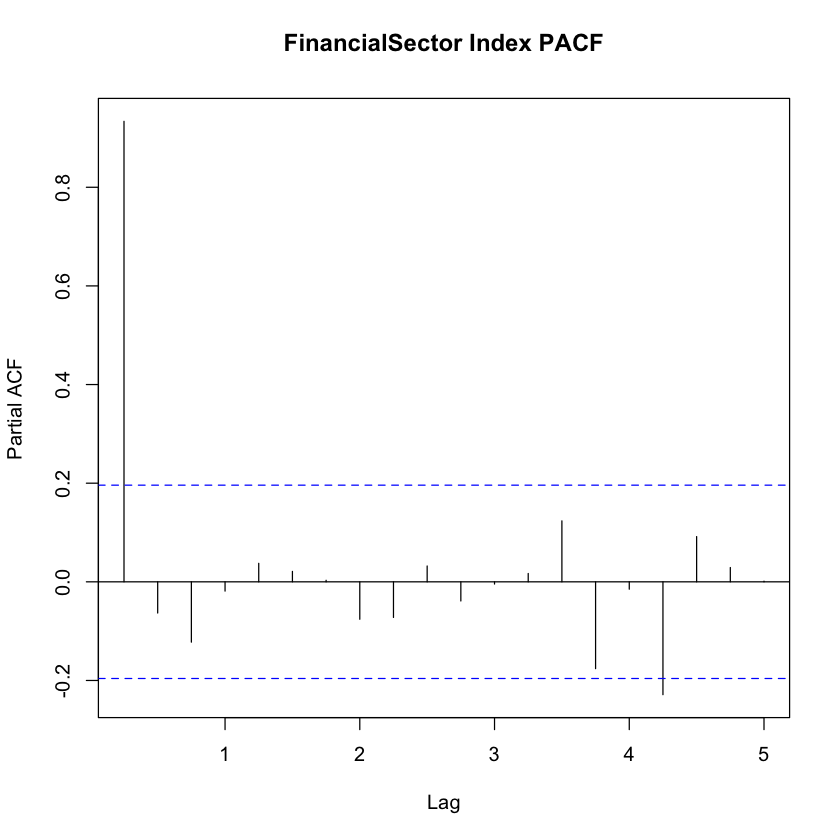

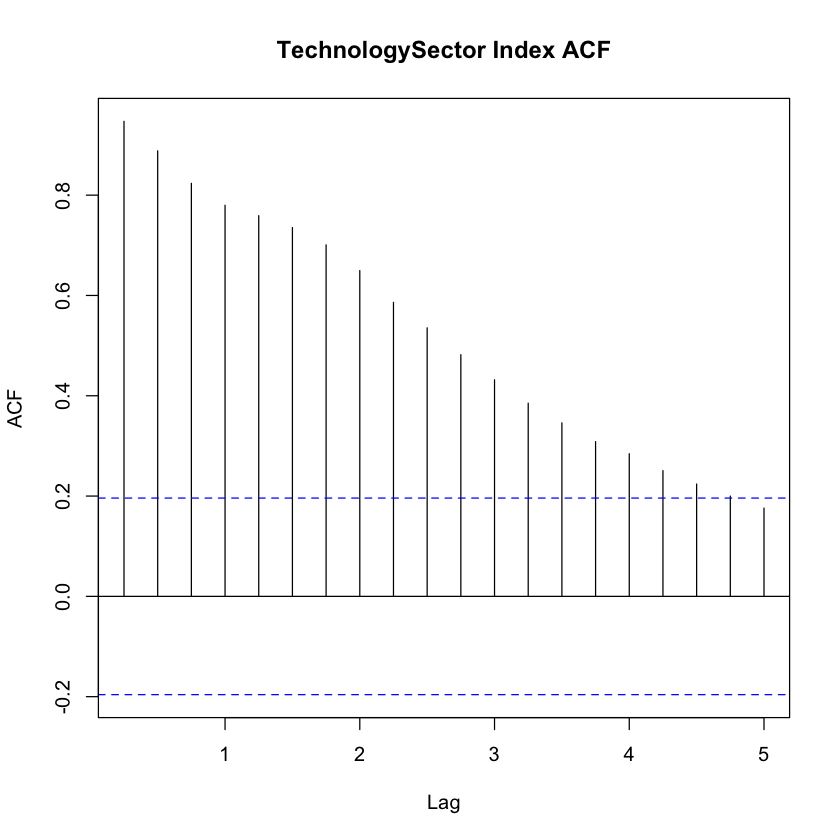

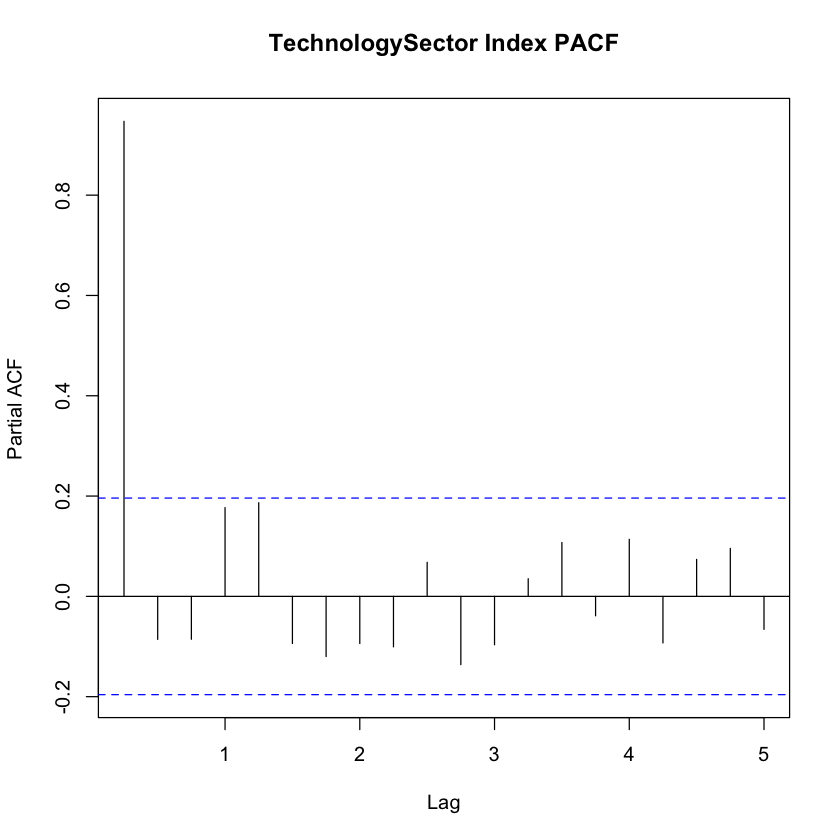

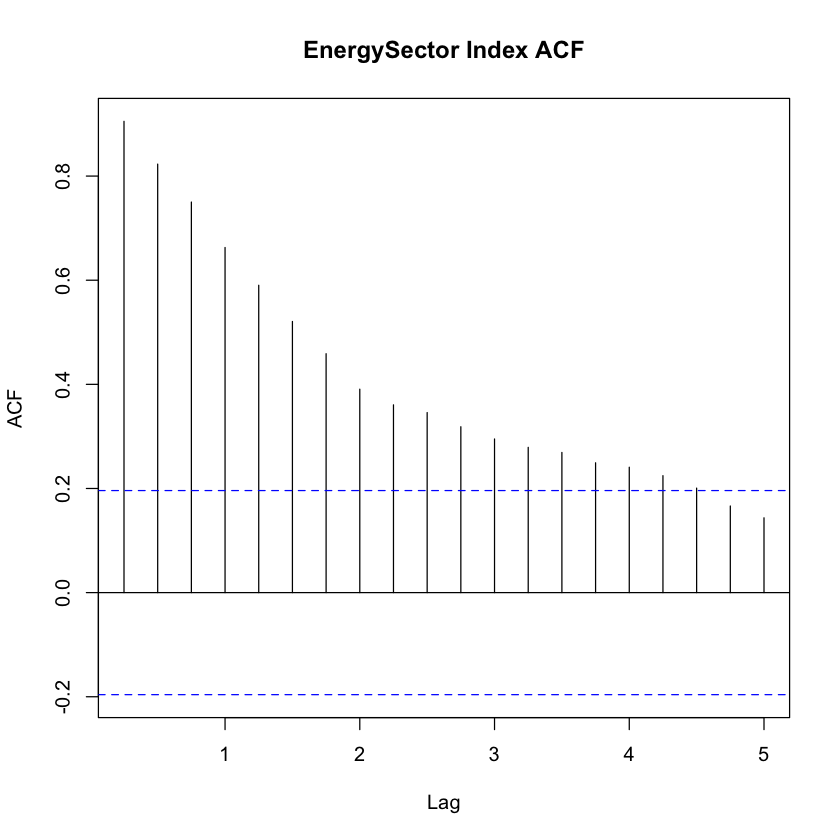

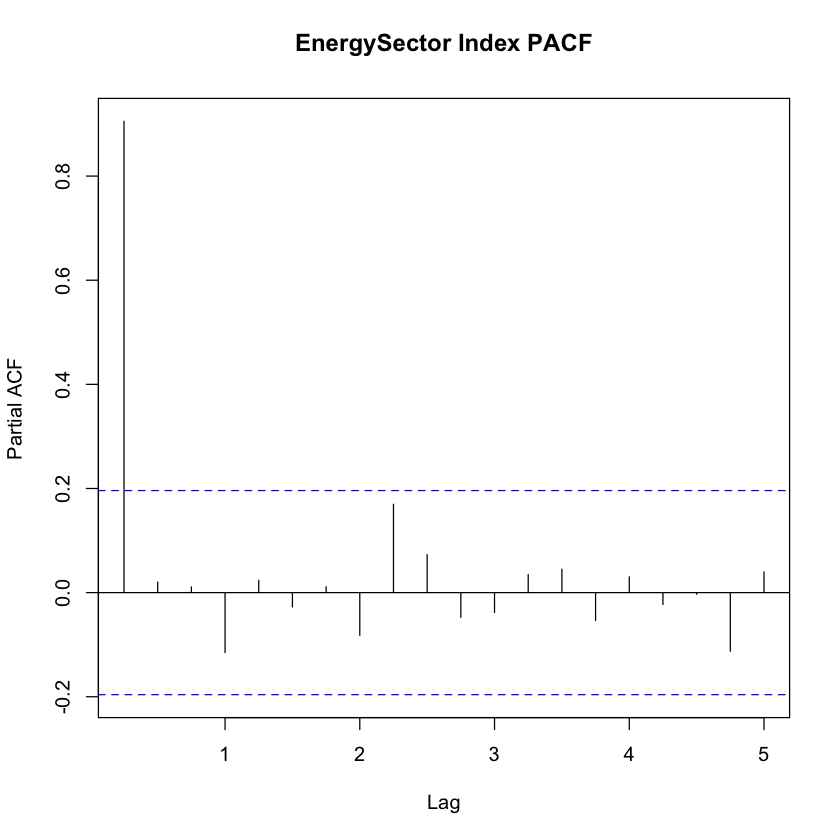

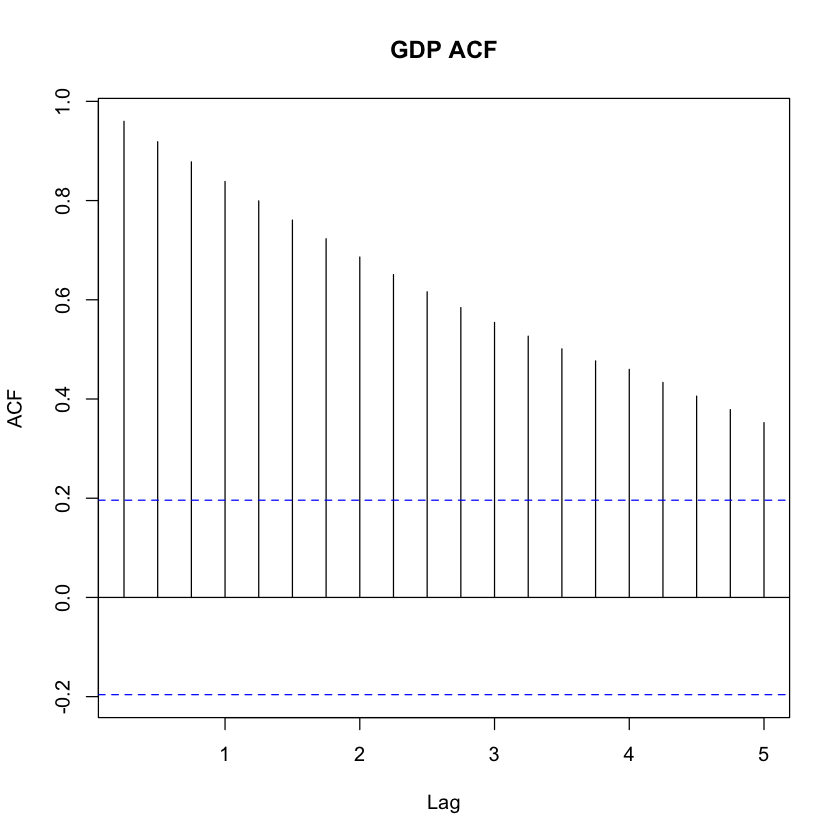

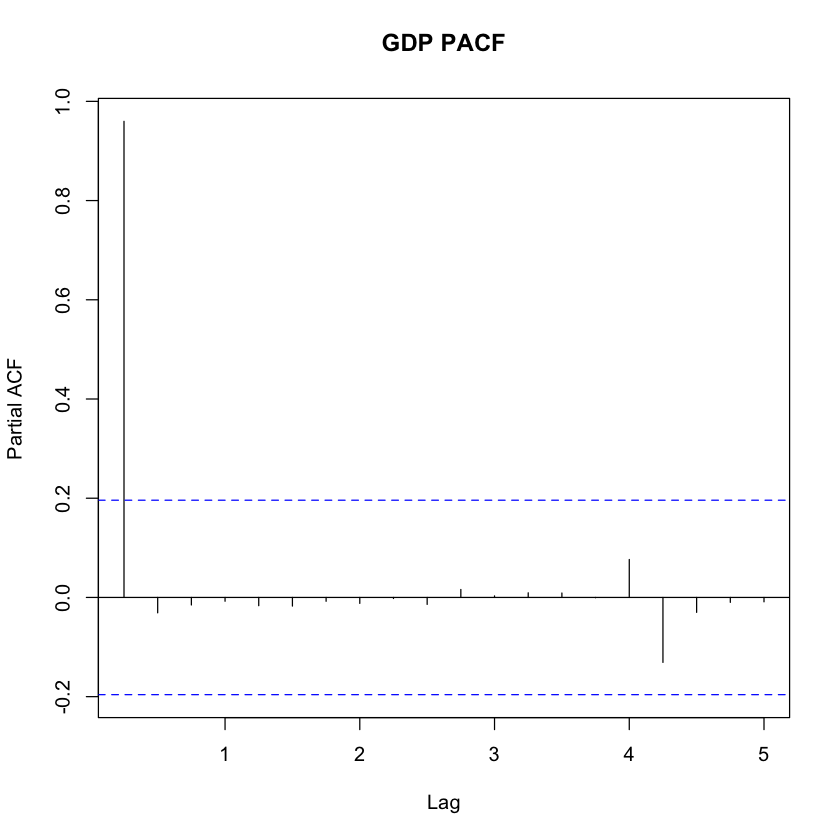

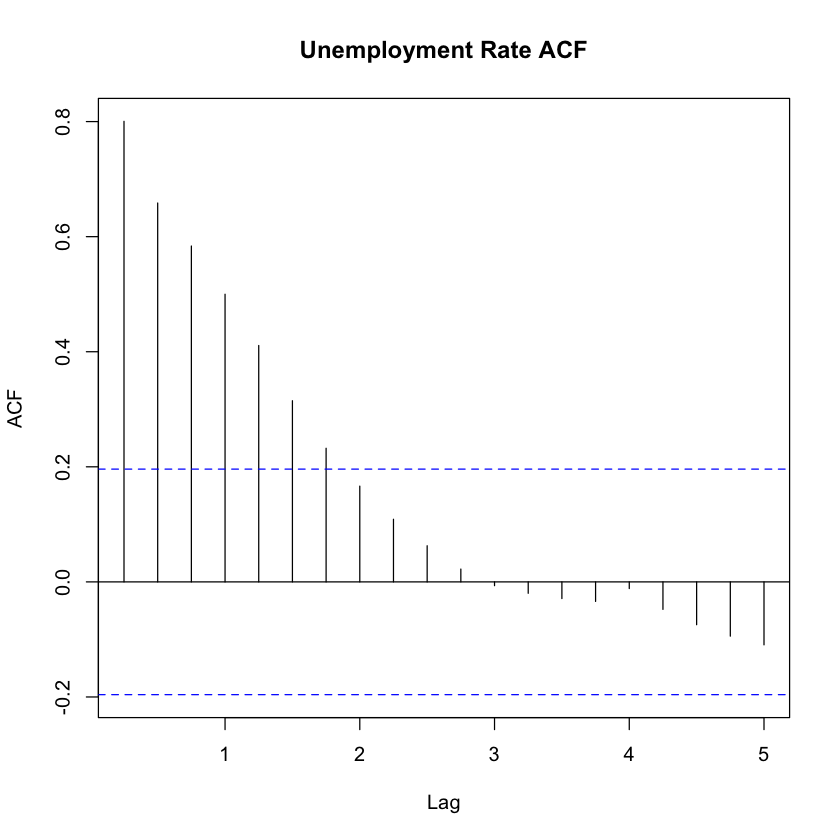

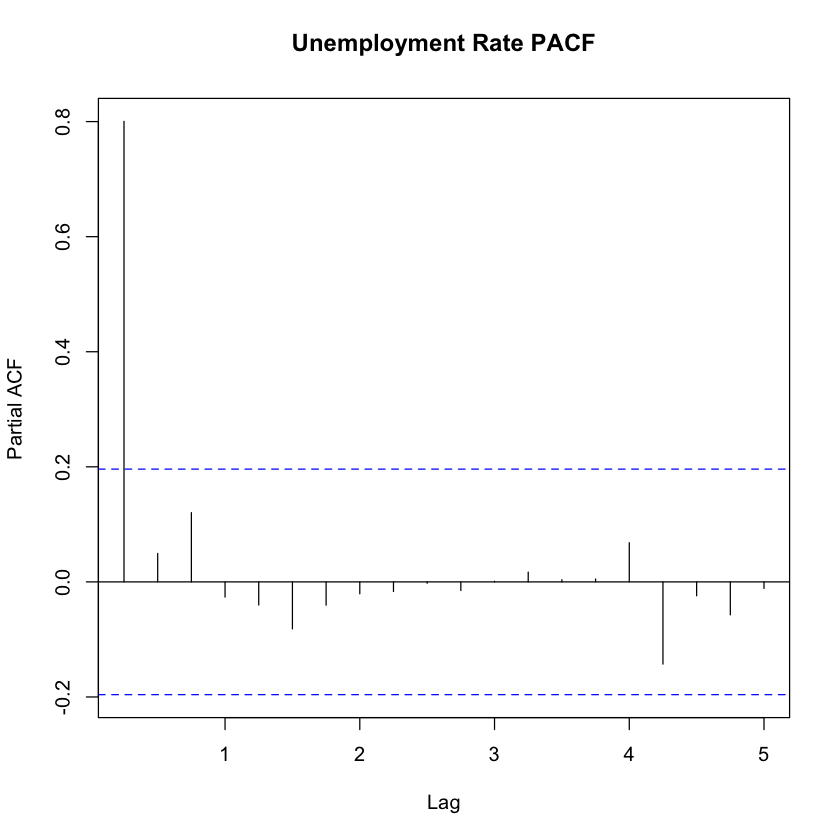

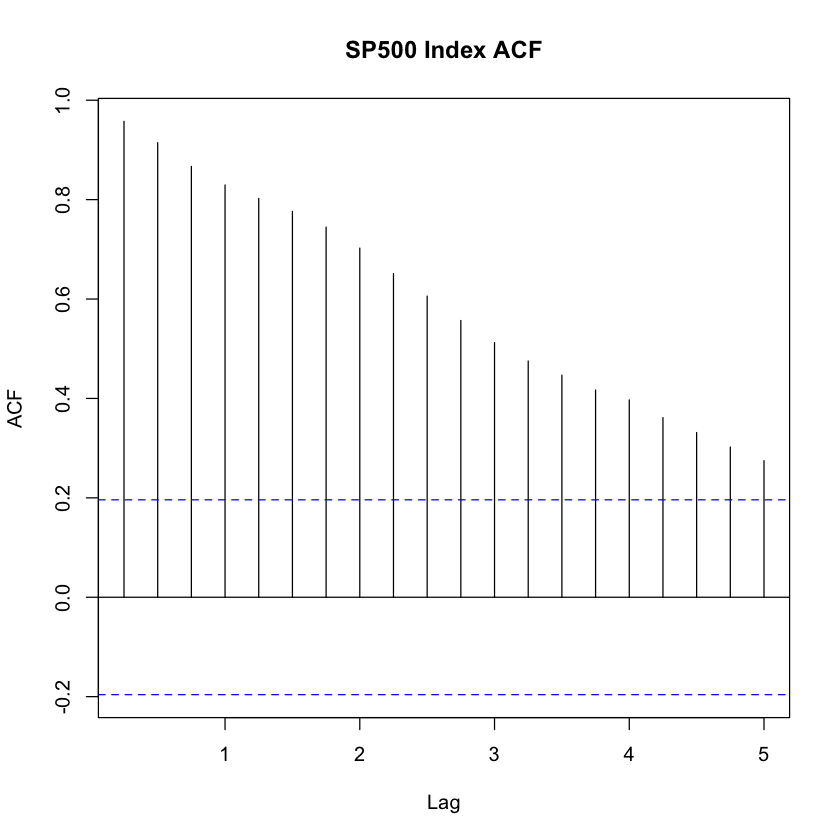

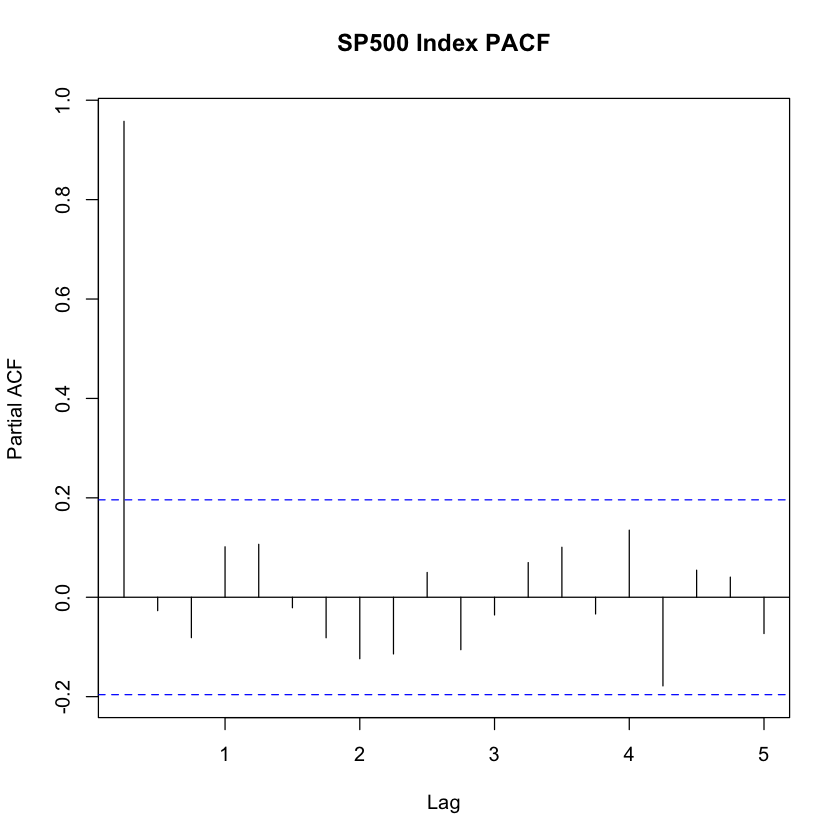

In [489]:
# ACF & PACF 

acf(AppleTimeSeries, main="Apple ACF")
pacf(AppleTimeSeries, main="Apple PACF")

acf(IBMTimeSeries, main="IBM ACF")
pacf(IBMTimeSeries, main="IBM PACF")

acf(AmericanExpressTimeSeries, main="American Express ACF")
pacf(AmericanExpressTimeSeries, main="American Express PACF")

acf(JPMorganChaseTimeSeries, main="JPMorganChase ACF")
pacf(JPMorganChaseTimeSeries, main="JPMorganChase PACF")

acf(ExxonMobilTimeSeries, main="ExxonMobil ACF")
pacf(ExxonMobilTimeSeries, main="ExxonMobil PACF")

acf(OccidentalPetroleumTimeSeries, main="Occidental Petroleum ACF")
pacf(OccidentalPetroleumTimeSeries, main="Occidental Petroleum PACF")

acf(FinancialSectorTimeSeries, main="FinancialSector Index ACF")
pacf(FinancialSectorTimeSeries, main="FinancialSector Index PACF")

acf(TechnologySectorTimeSeries, main="TechnologySector Index ACF")
pacf(TechnologySectorTimeSeries, main="TechnologySector Index PACF")

acf(EnergySectorTimeSeries, main="EnergySector Index ACF")
pacf(EnergySectorTimeSeries, main="EnergySector Index PACF")

acf(GDPTimeSeries, main="GDP ACF")
pacf(GDPTimeSeries, main="GDP PACF")

acf(UnemploymentTimeSeries, main="Unemployment Rate ACF")
pacf(UnemploymentTimeSeries, main="Unemployment Rate PACF")

acf(SP500TimeSeries, main="SP500 Index ACF")
pacf(SP500TimeSeries, main="SP500 Index PACF")

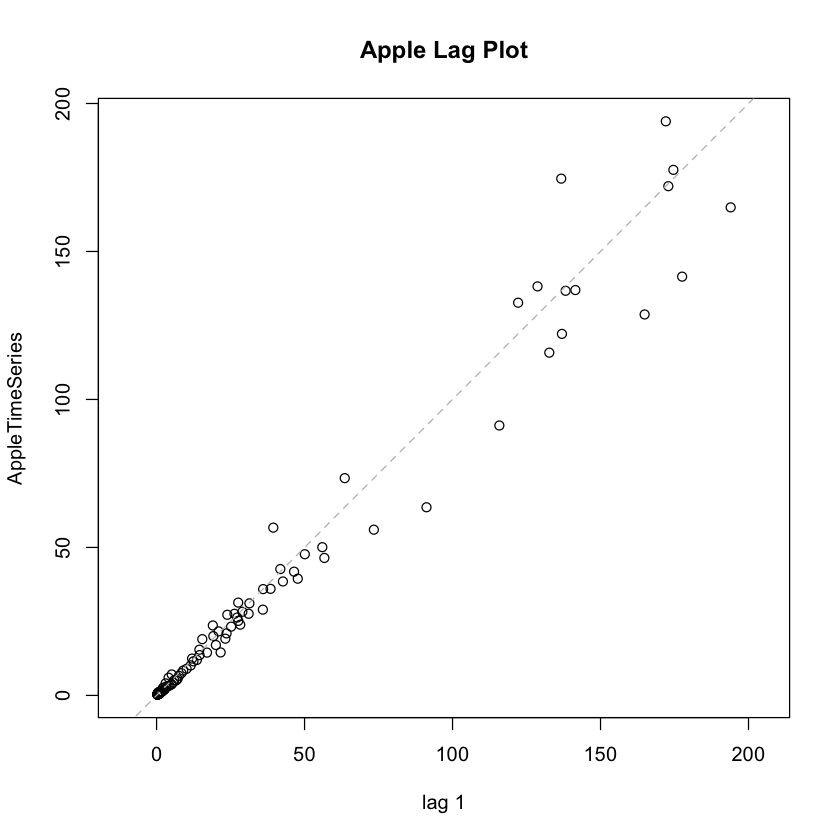

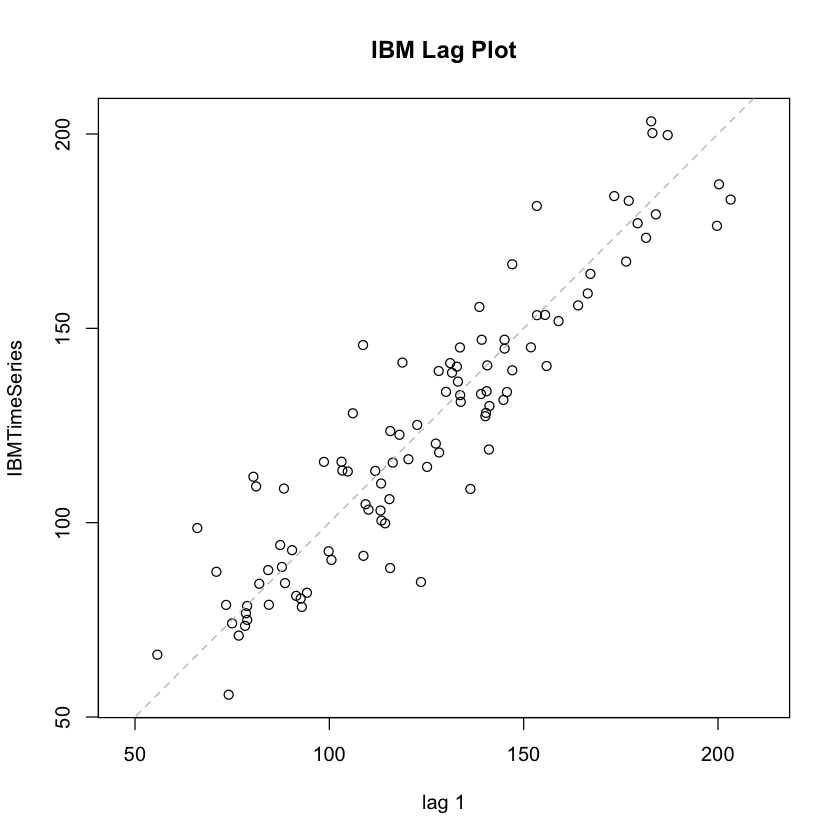

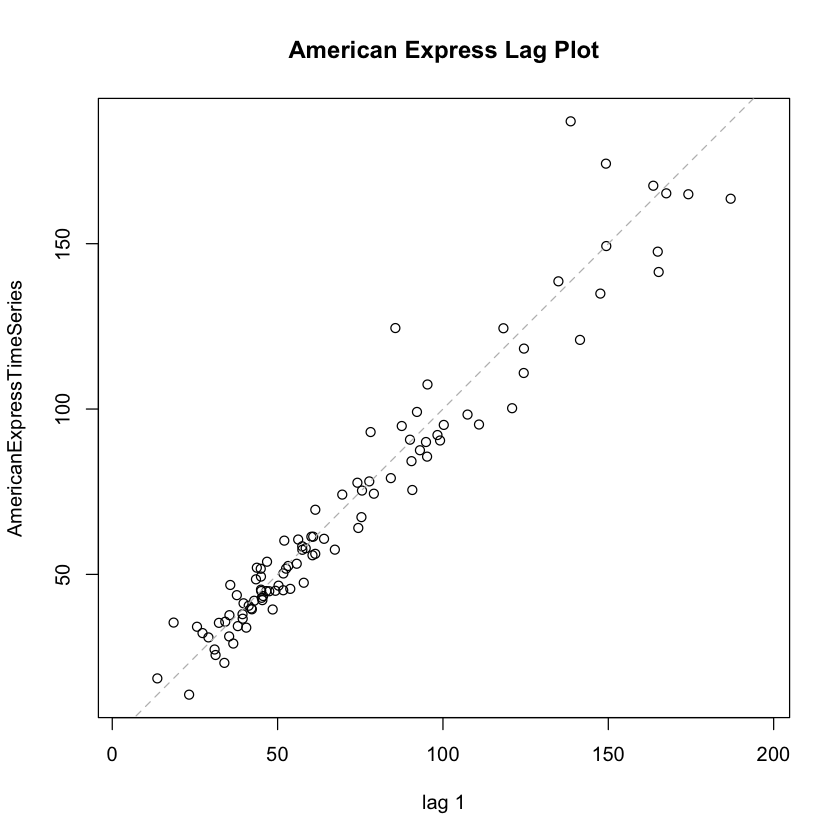

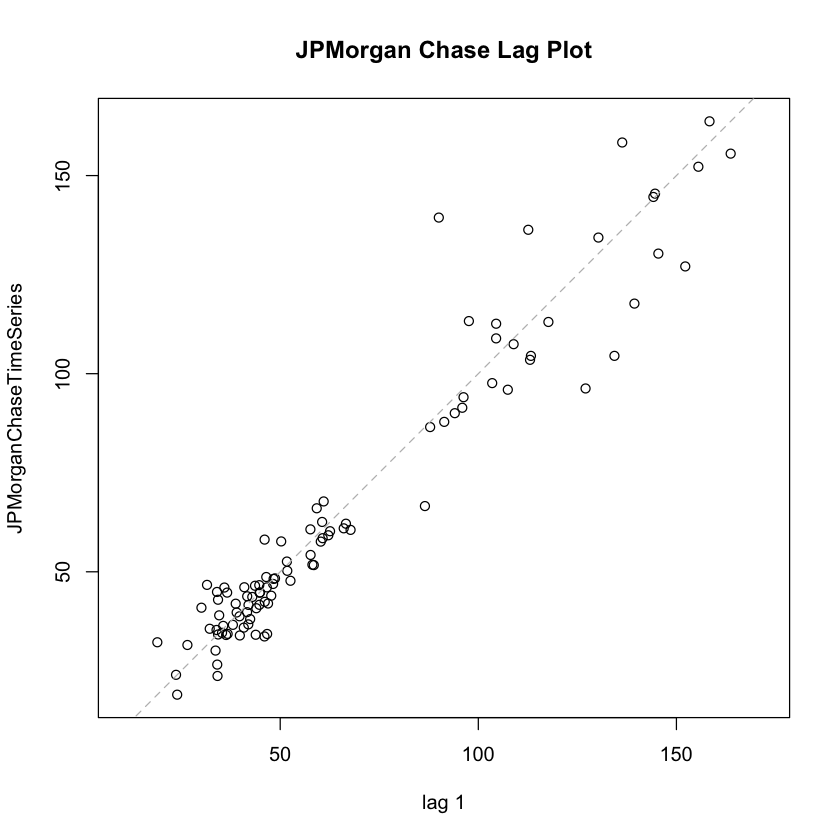

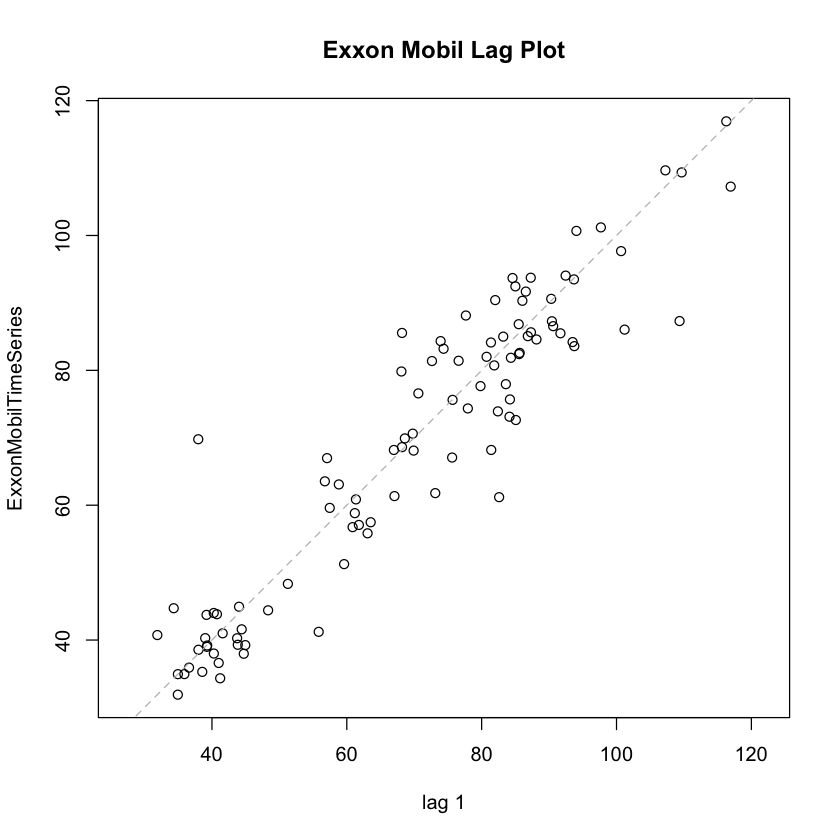

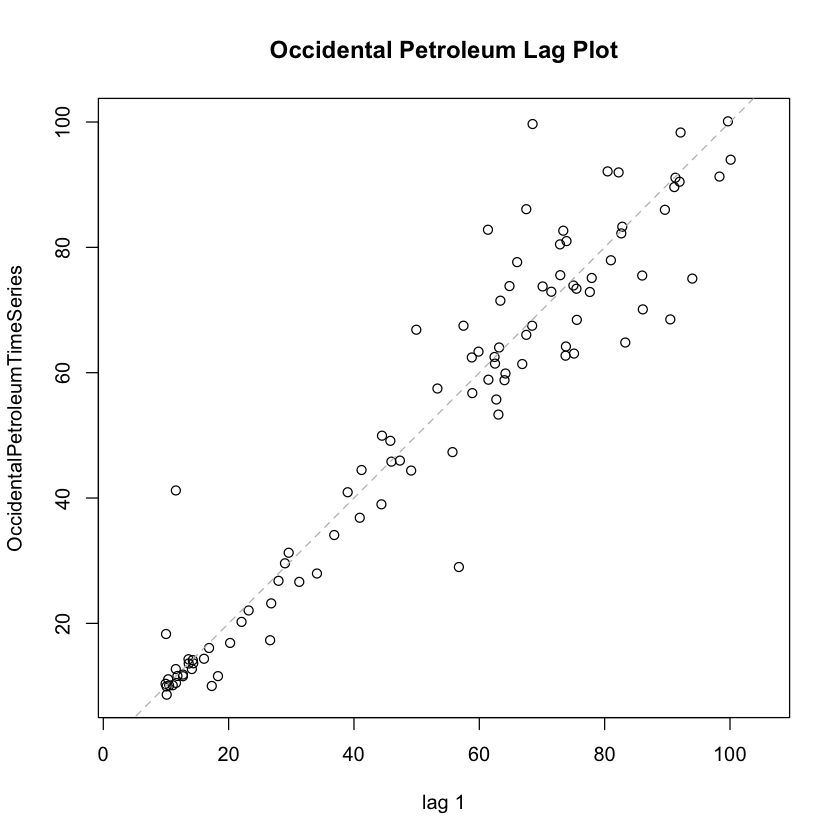

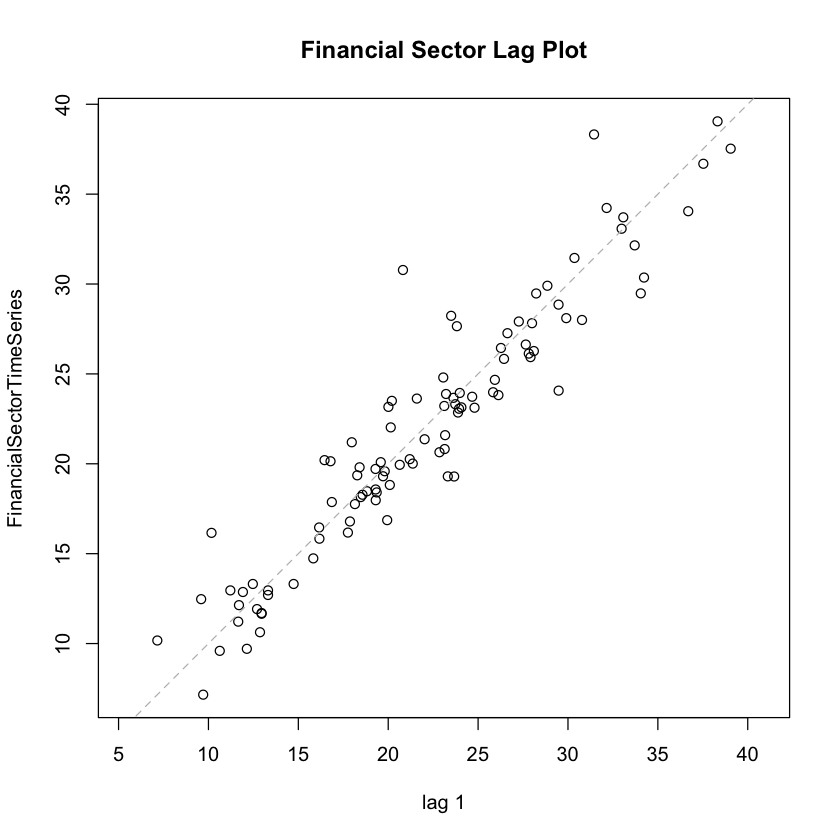

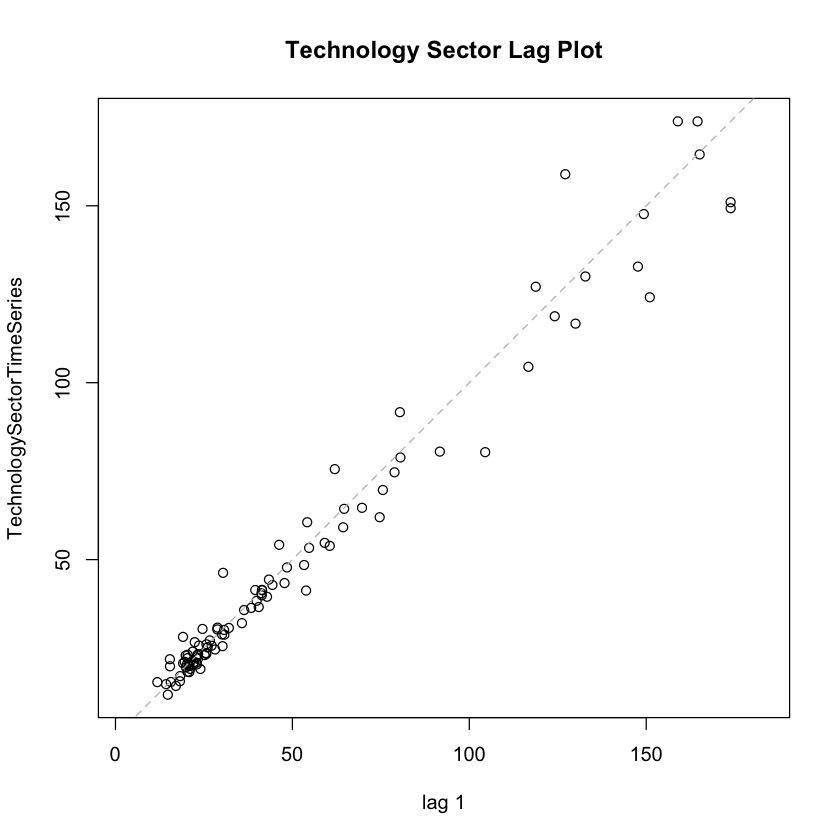

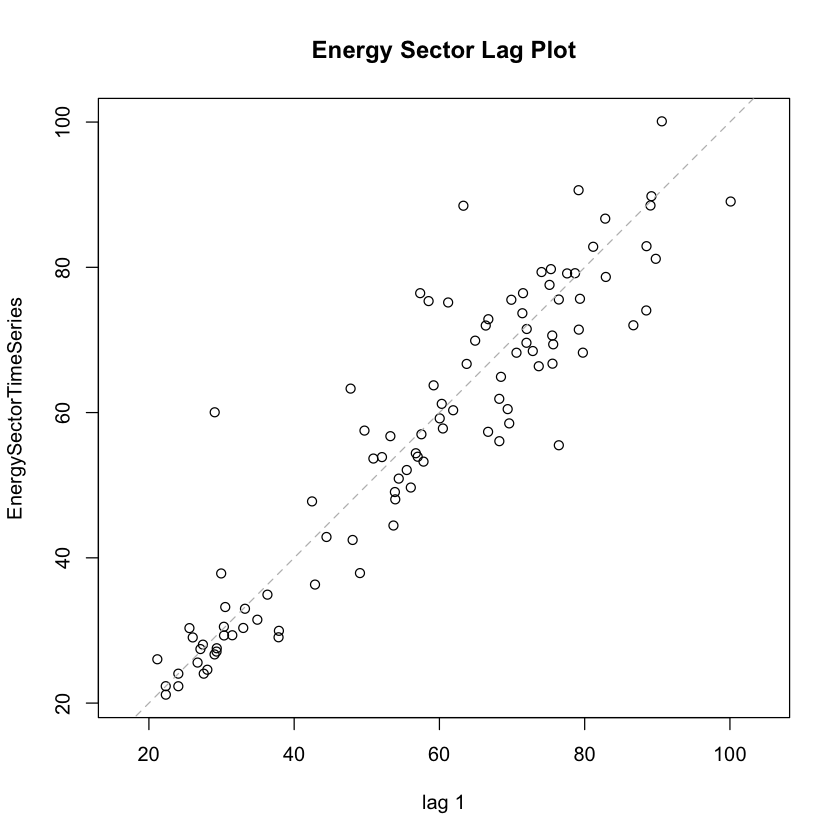

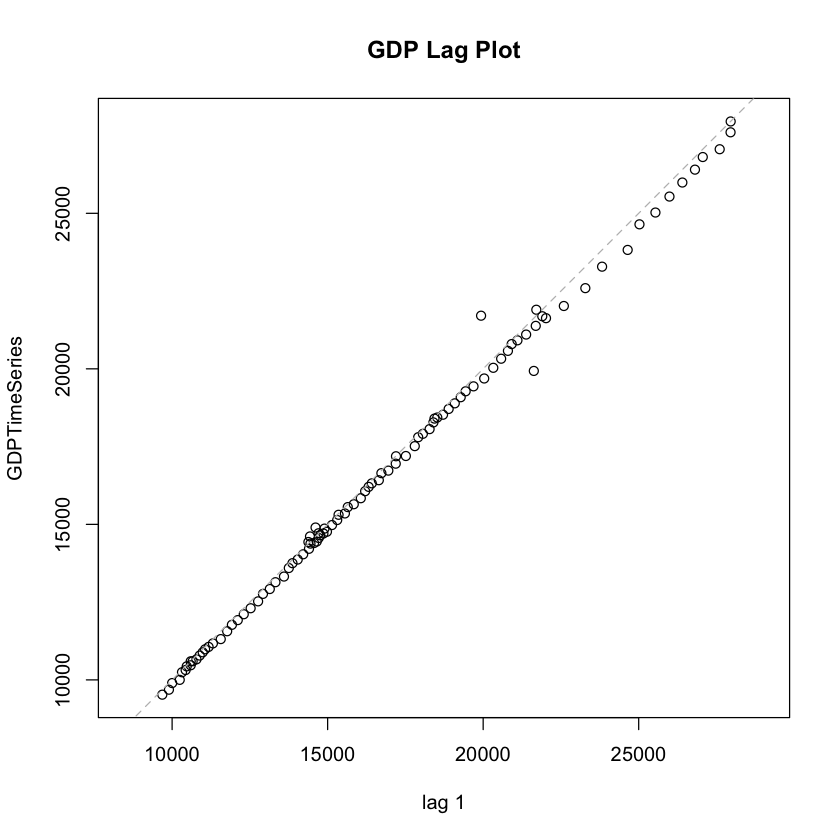

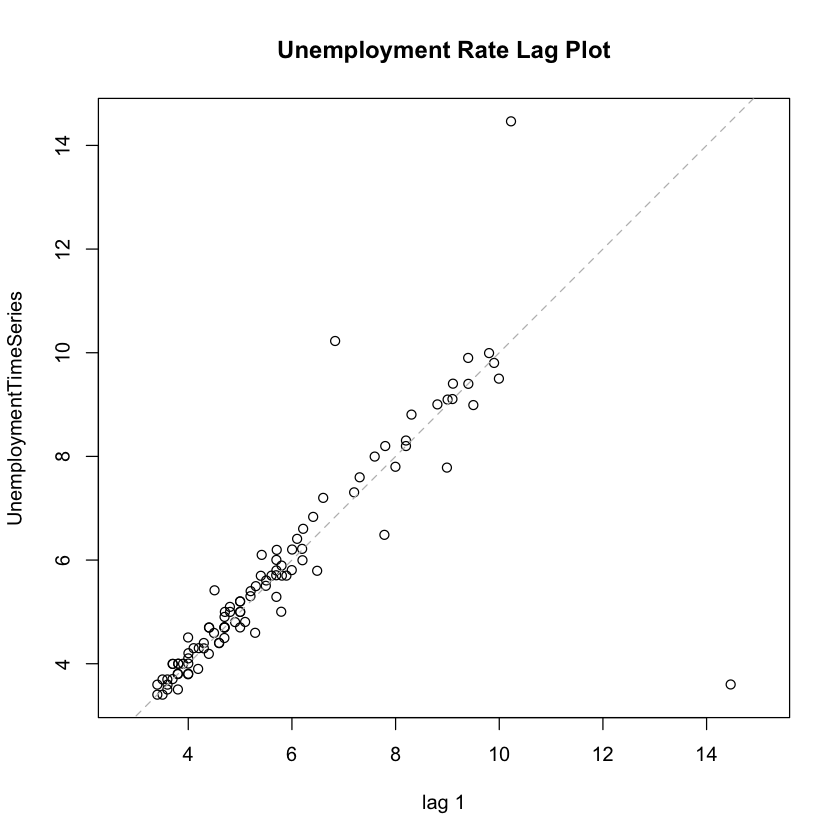

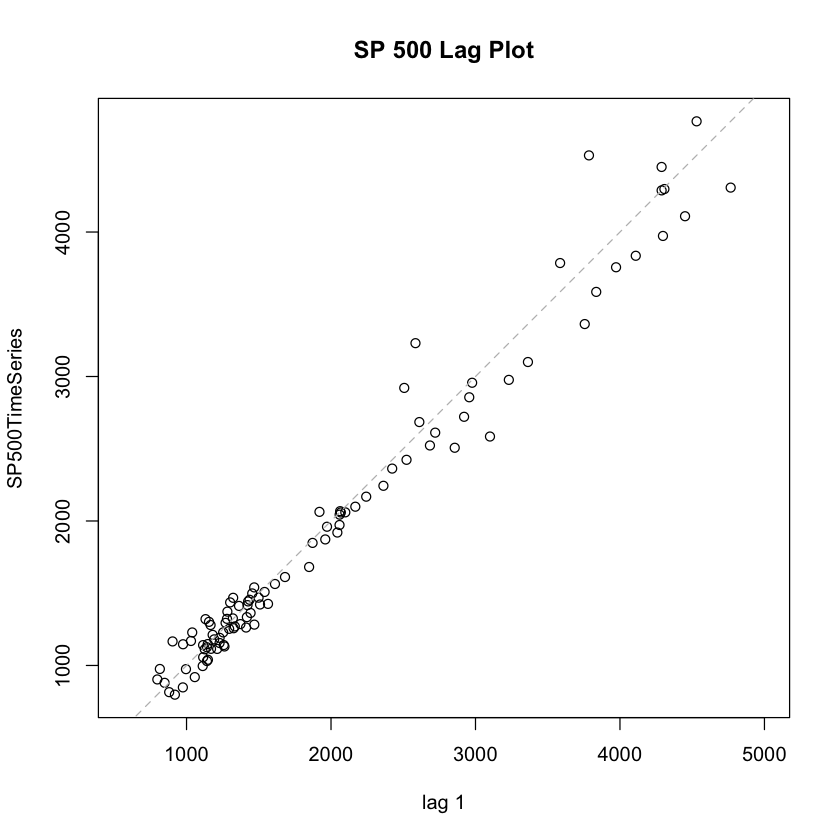

In [490]:
# Lag plots for all variables

lag.plot(AppleTimeSeries, lags=1, do.lines=FALSE, main="Apple Lag Plot") 
lag.plot(IBMTimeSeries, lags=1, do.lines=FALSE, main="IBM Lag Plot") 
lag.plot(AmericanExpressTimeSeries, lags=1, do.lines=FALSE, main="American Express Lag Plot") 
lag.plot(JPMorganChaseTimeSeries, lags=1, do.lines=FALSE, main="JPMorgan Chase Lag Plot") 
lag.plot(ExxonMobilTimeSeries, lags=1, do.lines=FALSE, main="Exxon Mobil Lag Plot") 
lag.plot(OccidentalPetroleumTimeSeries, lags=1, do.lines=FALSE, main="Occidental Petroleum Lag Plot") 
lag.plot(FinancialSectorTimeSeries, lags=1, do.lines=FALSE, main="Financial Sector Lag Plot")
lag.plot(TechnologySectorTimeSeries, lags=1, do.lines=FALSE, main="Technology Sector Lag Plot")
lag.plot(EnergySectorTimeSeries, lags=1, do.lines=FALSE, main="Energy Sector Lag Plot")
lag.plot(GDPTimeSeries, lags=1, do.lines=FALSE, main="GDP Lag Plot")
lag.plot(UnemploymentTimeSeries, lags=1, do.lines=FALSE, main="Unemployment Rate Lag Plot")
lag.plot(SP500TimeSeries, lags=1, do.lines=FALSE, main="SP 500 Lag Plot")

For all variables, autocorrelation was present suggesting that past values have a prolonged effect on future values.
Due to autocorrelation being present lagged variables and rolling statistic functions will be introduced and tried in the LSTM model.

Features such as rolling statistics and lagged features provide the ability to capture temporal dependencies, enhanced learning, smoothing and trend-capturing abilities.

# 8. Feature Engineering

In [491]:
# Rolling statistic function (Rolling mean & standard deviation)

rollingfeatures = function(data, target_column, window_size) {
  data[[paste0(target_column, "_rolling_mean_", window_size)]] = rollapply(data[[target_column]], width = window_size, FUN = mean, fill = NA, align = "right")
  data[[paste0(target_column, "_rolling_sd_", window_size)]] = rollapply(data[[target_column]], width = window_size, FUN = sd, fill = NA, align = "right")
  return(data)
}

window_size = 10

# Lag function

lagfeatures = function(data, target_column, lags) {
  for (i in seq_len(lags)) {
    data[[paste0(target_column, "_lag_", i)]] = dplyr::lag(data[[target_column]], i)
  }
  return(data)
}

lags = 5

# **9. LSTM Modeling**

Each variable has its own LSTM model. Models were built for each variable specifically by adjusting features, layers and hyperparameters. Models here are the models that lead to the best results for each variable. Models were evaluated with loss and MAE (Mean Absolute Error).

The loss function used was Mean Squared Error (MSE), which measures the average squared difference between the predicted and actual values. Lower loss indicates better model performance. Mean Absolute Error (MAE) measures the average absolute difference between the predicted and actual values. It provides a straightforward interpretation of prediction accuracy.

For every model, adding layers led to overfitting and drastically worse results. The increase of hyperparameters increased model fit but after Epoch set to 100 and batch size to 64, model hyperparameter tuning started to have drastically diminishing returns with longer training times.

For various variables adding lagged features to the model increased model fit a lot and led to the best results from multiple different models. A few models had their best results with rolling statistics. The combination of lagged variables and rolling statistics had mostly similar results as models with only one added feature.

## 9.1 Splitting & Sequences

In [492]:
# Normalized daily data without date column

NormalizedColumns = as.data.frame(lapply(MergedData[, c("AAPL.Close", "IBM.Close", "AXP.Close", "JPM.Close", "XOM.Close", "OXY.Close", "GSPC.Close", "UNRATE", "GDP", "XLF.Close", "XLK.Close", "XLE.Close")], normalize))

# Training & Test with 80/20 split

set.seed(123)

train_size = 0.8  
train_len = floor(train_size * nrow(NormalizedColumns))

trainingdata = NormalizedColumns[1:train_len, ]
testingdata = NormalizedColumns[(train_len + 1):nrow(NormalizedColumns), ]

str(trainingdata)
str(testingdata)

# Sequence function

create_sequences = function(data, target_column, sequence_length) {
  x = array(dim = c(nrow(data) - sequence_length + 1, sequence_length, ncol(data)))
  y = array(dim = c(nrow(data) - sequence_length + 1, 1))
  
  for (i in 1:(nrow(data) - sequence_length + 1)) {
    x[i, , ] = as.matrix(data[i:(i + sequence_length - 1), ])
    y[i] = data[i + sequence_length - 1, target_column]
  }
  
  return(list(x = x, y = y))
}

sequence_length = 10

'data.frame':	7229 obs. of  12 variables:
 $ AAPL.Close: num  0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ IBM.Close : num  0.227 0.247 0.245 0.249 0.241 ...
 $ AXP.Close : num  0.1029 0.0999 0.1062 0.1081 0.1131 ...
 $ JPM.Close : num  0.208 0.21 0.217 0.23 0.223 ...
 $ XOM.Close : num  0.0672 0.0637 0.0797 0.079 0.0766 ...
 $ OXY.Close : num  0.011 0.011 0.013 0.0124 0.0121 ...
 $ GSPC.Close: num  0.134 0.138 0.145 0.144 0.145 ...
 $ UNRATE    : num  0.0798 0.0801 0.0804 0.0806 0.0809 ...
 $ GDP       : num  0.00 6.86e-05 1.37e-04 2.06e-04 2.75e-04 ...
 $ XLF.Close : num  0.385 0.39 0.407 0.415 0.419 ...
 $ XLK.Close : num  0.127 0.132 0.138 0.137 0.138 ...
 $ XLE.Close : num  0.0433 0.0418 0.0512 0.0498 0.0512 ...
'data.frame':	1808 obs. of  12 variables:
 $ AAPL.Close: num  0.279 0.279 0.28 0.283 0.273 ...
 $ IBM.Close : num  0.462 0.464 0.466 0.474 0.449 ...
 $ AXP.Close : num  0.509 0.505 0.501 0.5 0.487 ...
 $ JPM.Close : num  0.588 0.585 0.582 0.574 0.562 ...
 $ XOM.Clos

# **IBM**

In [493]:
# Lagged features to IBM model

Normalizedlagged = lagfeatures(NormalizedColumns, "IBM.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# IBM Sequences

IBMTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "IBM.Close", sequence_length)
IBMTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "IBM.Close", sequence_length)
str(IBMTrainSequences)
str(IBMTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.234 0.219 0.233 0.238 0.244 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.402 0.375 0.376 0.384 0.377 ...


In [494]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_57"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_57 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [495]:
# Training, Evaluation & Results

history = model %>% fit(
  x = IBMTrainSequences$x, 
  y = IBMTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

results = model %>% evaluate(
  x = IBMTestSequences$x,
  y = IBMTestSequences$y
)

print(results)

$loss
[1] 5.087766e-05

$mean_absolute_error
[1] 0.005555241



In [496]:
# Denormalize function for visualization

denormalize = function(x, min_x, max_x) {
  return (x * (max_x - min_x) + min_x)
}

min_price = min(MergedData$IBM.Close, na.rm = TRUE)
max_price = max(MergedData$IBM.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(IBMTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(IBMTestSequences$y, min_price, max_price)

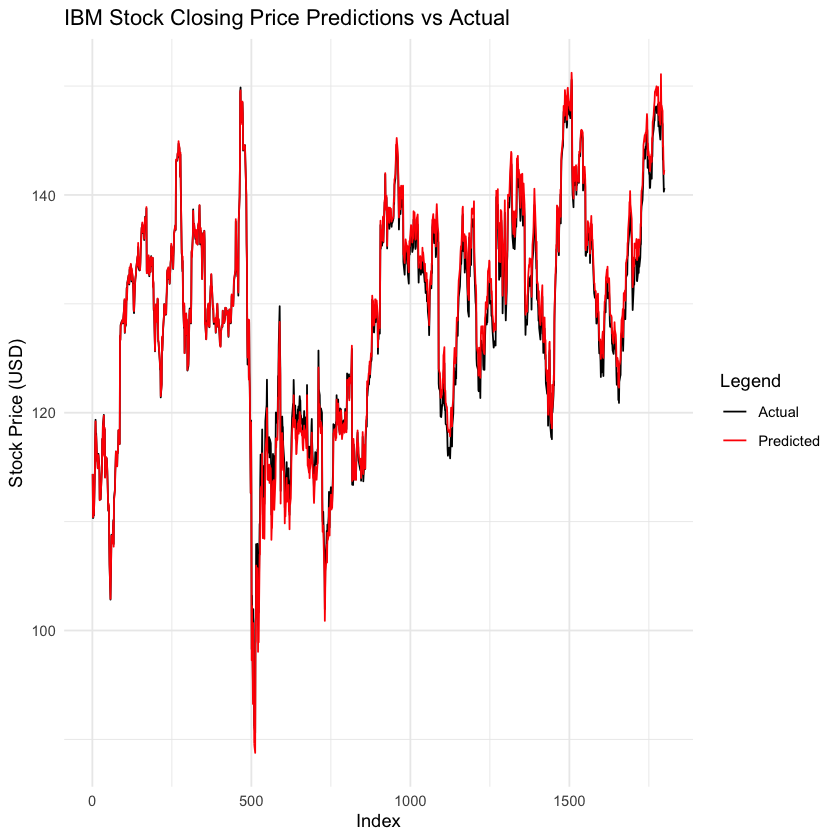

In [497]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "IBM Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Apple**

In [498]:
# Lagged features to Apple model

Normalizedlagged = lagfeatures(NormalizedColumns, "AAPL.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Apple sequences

AppleTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "AAPL.Close", sequence_length)
AppleTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "AAPL.Close", sequence_length)
str(AppleTrainSequences)
str(AppleTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.000922 0.000689 0.000686 0.000681 0.000676 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.269 0.271 0.278 0.282 0.263 ...


In [499]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_58"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_58 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_58 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [500]:
# Training, Evaluation & Results

history = model %>% fit(
  x = AppleTrainSequences$x, 
  y = AppleTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = AppleTestSequences$x,
  y = AppleTestSequences$y
)

print(results)

$loss
[1] 3.08333e-05

$mean_absolute_error
[1] 0.004030683



In [501]:
# Denormalization for visualization

min_price = min(MergedData$AAPL.Close, na.rm = TRUE)
max_price = max(MergedData$AAPL.Close, na.rm = TRUE)

predictions = model %>% predict(AppleTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(AppleTestSequences$y, min_price, max_price)

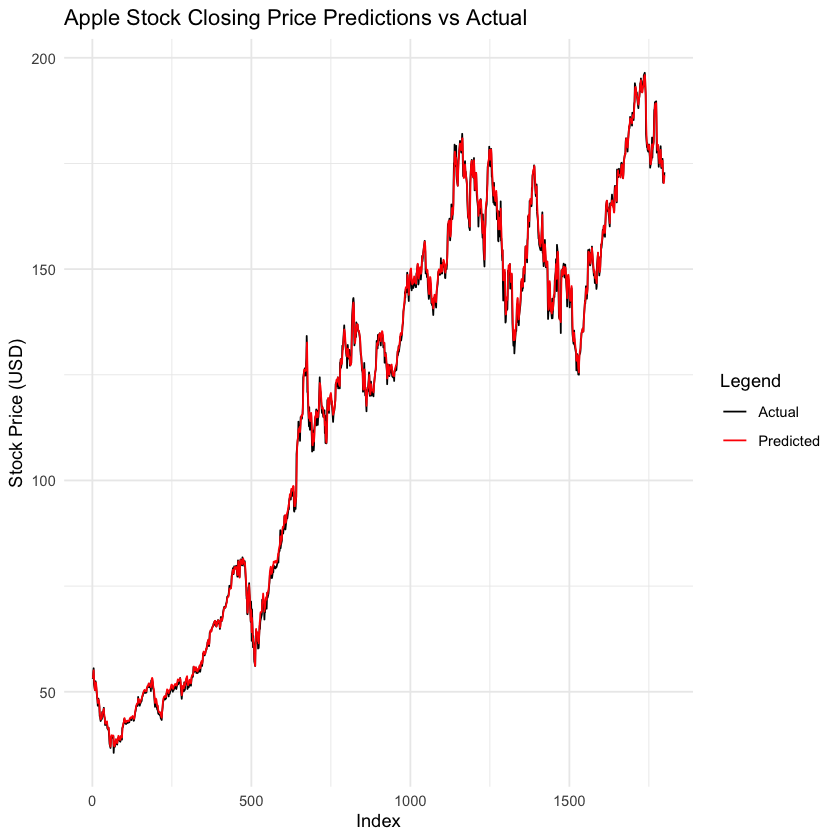

In [502]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Apple Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **American Express**

In [503]:
# Lagged features to American Express model

Normalizedlagged = lagfeatures(NormalizedColumns, "AXP.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# American Express sequences

AmexTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "AXP.Close", sequence_length)
AmexTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "AXP.Close", sequence_length)
str(AmexTrainSequences)
str(AmexTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.0985 0.0944 0.1073 0.1058 0.1043 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.483 0.488 0.492 0.499 0.497 ...


In [504]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_59"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_59 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_59 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [505]:
# Training, Evaluation & Results

history = model %>% fit(
  x = AmexTrainSequences$x, 
  y = AmexTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = AmexTestSequences$x,
  y = AmexTestSequences$y
)

print(results)

$loss
[1] 9.61576e-05

$mean_absolute_error
[1] 0.007796402



In [506]:
# Denormalization for visualization

min_price = min(MergedData$AXP.Close, na.rm = TRUE)
max_price = max(MergedData$AXP.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(AmexTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(AmexTestSequences$y, min_price, max_price)

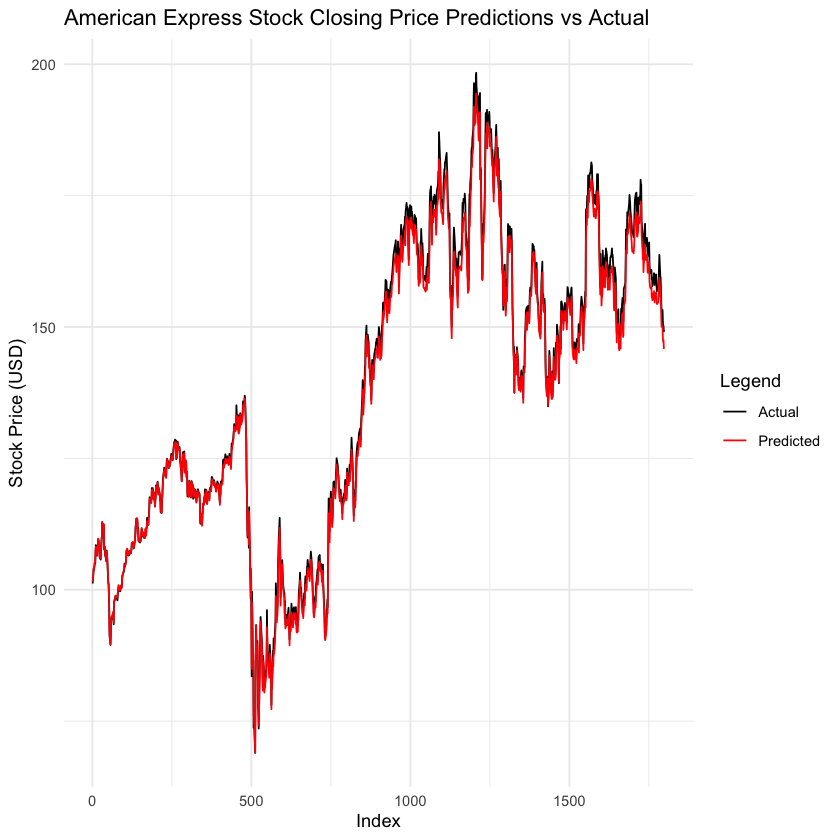

In [507]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "American Express Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **JPMorgan Chase**

In [508]:
# Lagged features to JPMorgan Chase model

Normalizedlagged = lagfeatures(NormalizedColumns, "JPM.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# JPMorgan Chase sequences

JPMTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "JPM.Close", sequence_length)
JPMTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "JPM.Close", sequence_length)
str(JPMTrainSequences)
str(JPMTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.207 0.192 0.203 0.207 0.211 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.572 0.584 0.599 0.598 0.594 ...


In [509]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_60"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_60 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [510]:
# Training, Evaluation & Results

history = model %>% fit(
  x = JPMTrainSequences$x, 
  y = JPMTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = JPMTestSequences$x,
  y = JPMTestSequences$y
)

print(results)

$loss
[1] 1.260871e-05

$mean_absolute_error
[1] 0.002806442



In [511]:
# Denormalization for visualization

min_price = min(MergedData$JPM.Close, na.rm = TRUE)
max_price = max(MergedData$JPM.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(JPMTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(JPMTestSequences$y, min_price, max_price)

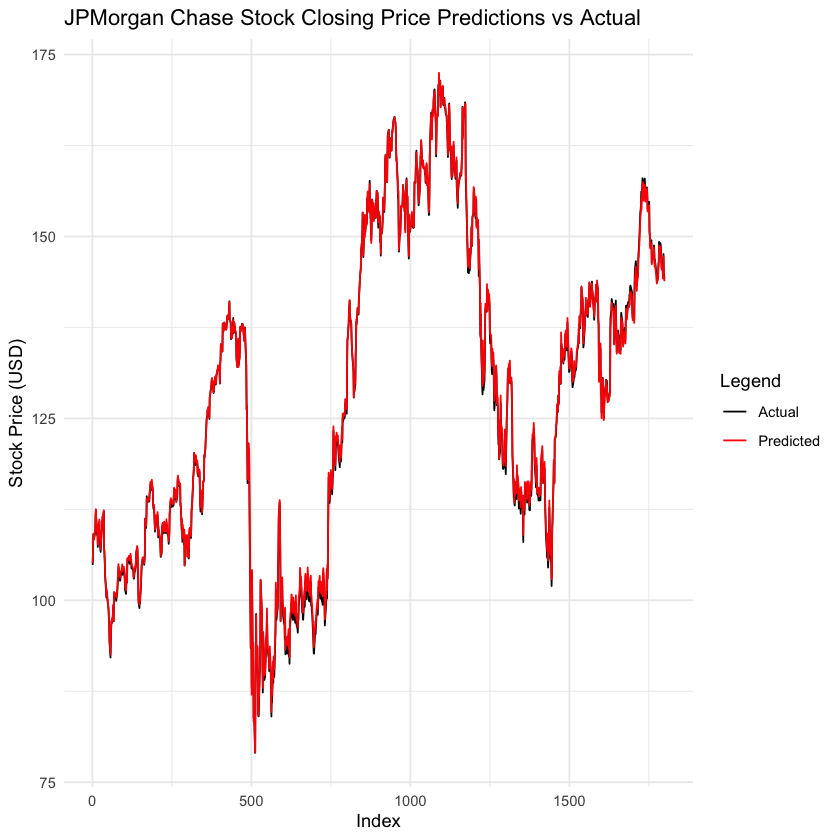

In [512]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "JPMorgan Chase Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Exxon Mobil**

In [513]:
# Lagged features to Exxon Mobil model

Normalizedlagged = lagfeatures(NormalizedColumns, "XOM.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Exxon Mobil sequences

ExxonTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "XOM.Close", sequence_length)
ExxonTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "XOM.Close", sequence_length)
str(ExxonTrainSequences)
str(ExxonTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.0554 0.0512 0.0585 0.0585 0.0585 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.52 0.539 0.549 0.56 0.575 ...


In [514]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_61"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_61 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [515]:
# Training, Evaluation & Results

history = model %>% fit(
  x = ExxonTrainSequences$x, 
  y = ExxonTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = ExxonTestSequences$x,
  y = ExxonTestSequences$y
)

print(results)

$loss
[1] 2.518778e-05

$mean_absolute_error
[1] 0.003764171



In [516]:
# Denormalization for visualization

min_price = min(MergedData$XOM.Close, na.rm = TRUE)
max_price = max(MergedData$XOM.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(ExxonTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(ExxonTestSequences$y, min_price, max_price)

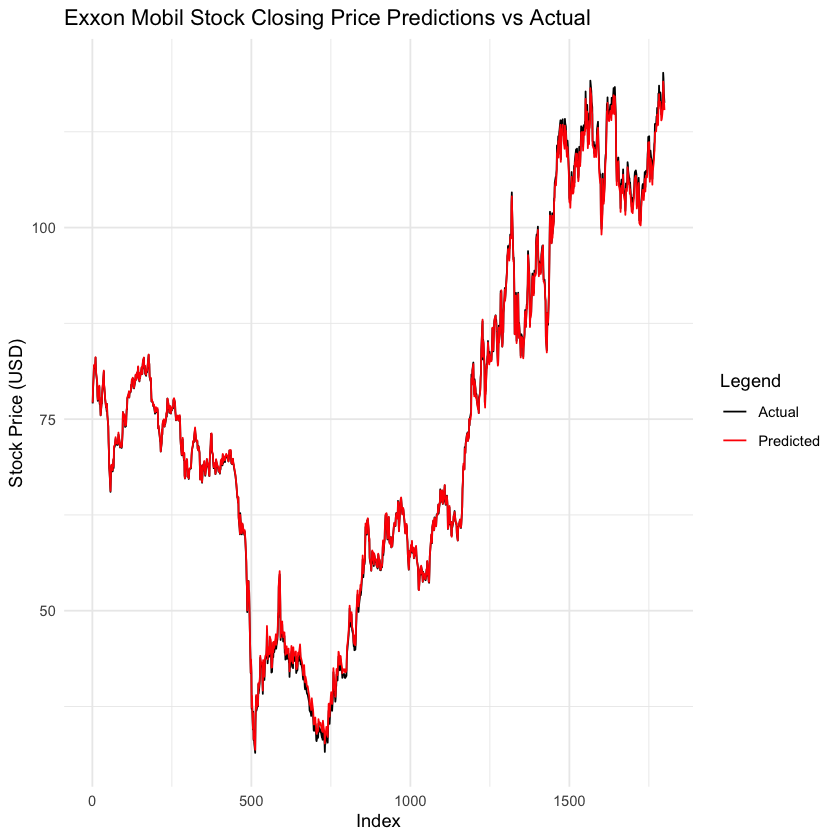

In [517]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Exxon Mobil Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Occidental Petroleum**

In [518]:
# Lagged features to Occidental Petroleum model

Normalizedlagged = lagfeatures(NormalizedColumns, "OXY.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Occidental Petroleum sequences

OccidentalTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "OXY.Close", sequence_length)
OccidentalTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "OXY.Close", sequence_length)
str(OccidentalTrainSequences)
str(OccidentalTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.0121 0.0115 0.0124 0.0121 0.0118 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.572 0.583 0.578 0.59 0.59 ...


In [519]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_62"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_62 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_62 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [520]:
# Training, Evaluation & Results

history = model %>% fit(
  x = OccidentalTrainSequences$x, 
  y = OccidentalTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)


results = model %>% evaluate(
  x = OccidentalTestSequences$x,
  y = OccidentalTestSequences$y
)

print(results)

$loss
[1] 8.370064e-05

$mean_absolute_error
[1] 0.007579344



In [521]:
# Denormalization for visualization

min_price = min(MergedData$OXY.Close, na.rm = TRUE)
max_price = max(MergedData$OXY.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(OccidentalTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(OccidentalTestSequences$y, min_price, max_price)

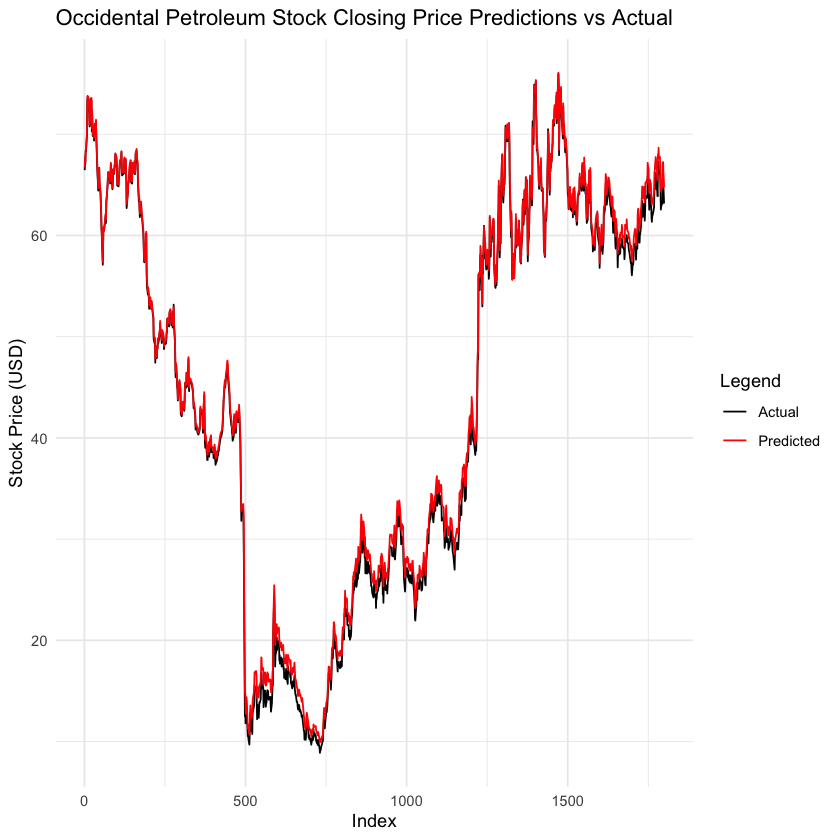

In [522]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Occidental Petroleum Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Financial Sector Index**

In [523]:
# Rolling features to Financial Sector Model

Normalizedrolling = rollingfeatures(NormalizedColumns, "XLF.Close", window_size)
any(is.na(Normalizedrolling))
Normalizedrolling = as.data.frame(lapply(Normalizedrolling, na.fill, fill = "extend"))
any(is.na(Normalizedrolling))

FinSecTrainSequences = create_sequences(Normalizedrolling[1:train_len, ], "XLF.Close", sequence_length)
FinSecTestSequences = create_sequences(Normalizedrolling[(train_len + 1):nrow(Normalizedrolling), ], "XLF.Close", sequence_length)
str(FinSecTrainSequences)
str(FinSecTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:14] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.388 0.375 0.389 0.389 0.388 ...
List of 2
 $ x: num [1:1799, 1:10, 1:14] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.562 0.574 0.584 0.587 0.587 ...


In [524]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedrolling)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_63"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                    │ (None, 50)               │        13,000 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_63 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,051 (50.98 KB)
 Trainable params: 13,051 (50.98 KB)
 Non-trainable params: 0 (0.00 B)


In [525]:
# Training, Evaluation & Results

history = model %>% fit(
  x = FinSecTrainSequences$x, 
  y = FinSecTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model

results <- model %>% evaluate(
  x = FinSecTestSequences$x,
  y = FinSecTestSequences$y
)

print(results)

$loss
[1] 9.703339e-05

$mean_absolute_error
[1] 0.007811092



In [526]:
# Denormalization for visualization

min_price = min(MergedData$XLF.Close, na.rm = TRUE)
max_price = max(MergedData$XLF.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(FinSecTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(FinSecTestSequences$y, min_price, max_price)

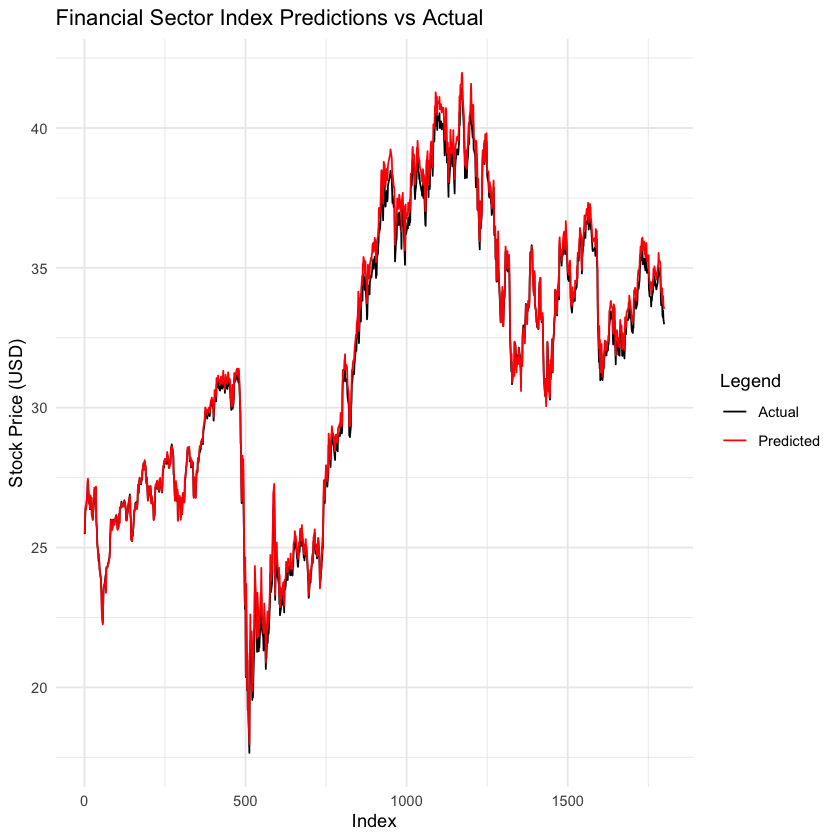

In [527]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Financial Sector Index Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Technology Sector Index**

In [531]:
# Technology Sector sequences

Normalizedlagged = lagfeatures(NormalizedColumns, "XLK.Close", lags)
any(is.na(Normalizedlagged))
Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

TecSecTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "XLK.Close", sequence_length)
TecSecTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "XLK.Close", sequence_length)
str(TecSecTrainSequences)
str(TecSecTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.134 0.132 0.138 0.139 0.141 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.328 0.333 0.342 0.347 0.339 ...


In [532]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_65"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_65 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_65 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [533]:
# Training, Evaluation & Results

history = model %>% fit(
  x = TecSecTrainSequences$x, 
  y = TecSecTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

results = model %>% evaluate(
  x = TecSecTestSequences$x,
  y = TecSecTestSequences$y
)

print(results)

$loss
[1] 0.0001026064

$mean_absolute_error
[1] 0.006956598



In [534]:
# Denormalization for visualization

min_price = min(MergedData$XLK.Close, na.rm = TRUE)
max_price = max(MergedData$XLK.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(TecSecTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(TecSecTestSequences$y, min_price, max_price)

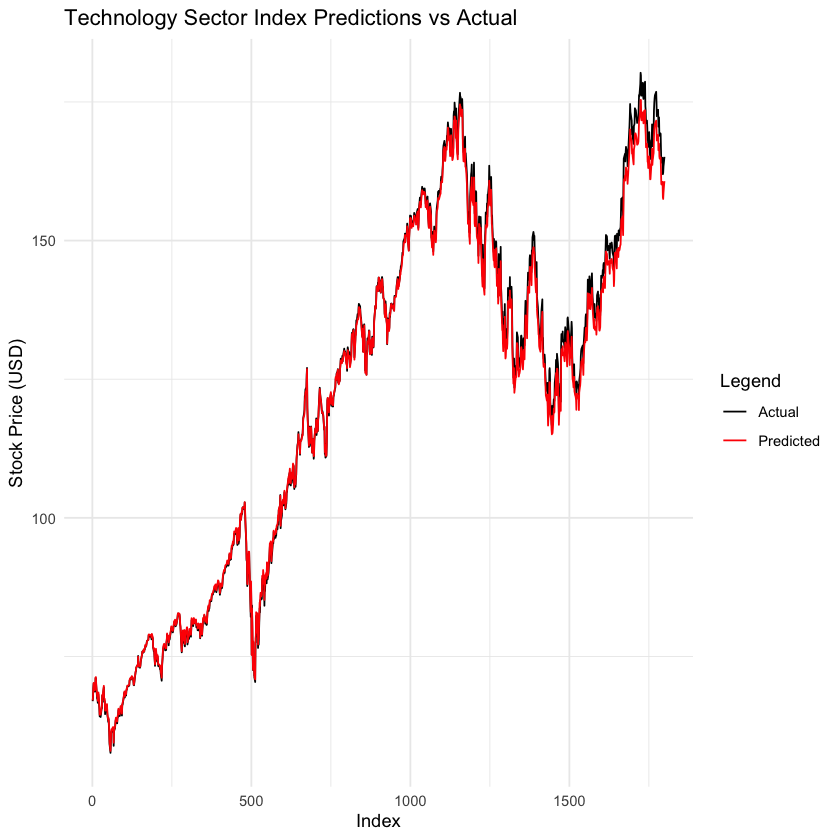

In [535]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Technology Sector Index Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Energy Sector Index**

In [536]:
# Lagged features to Financial Sector Model

Normalizedlagged = lagfeatures(NormalizedColumns, "XLE.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Sequences

EnergySectorTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "XLE.Close", sequence_length)
EnergySectorTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "XLE.Close", sequence_length)
str(EnergySectorTrainSequences)
str(EnergySectorTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.037 0.0316 0.0358 0.0358 0.0358 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.558 0.576 0.581 0.588 0.586 ...


In [537]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_66"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_66 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [538]:
# Training, Evaluation & Predictions

history = model %>% fit(
  x = EnergySectorTrainSequences$x, 
  y = EnergySectorTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = EnergySectorTestSequences$x,
  y = EnergySectorTestSequences$y
)

print(results)

$loss
[1] 4.854473e-05

$mean_absolute_error
[1] 0.005283509



In [539]:
# Denormalization for visualization

min_price = min(MergedData$XLE.Close, na.rm = TRUE)
max_price = max(MergedData$XLE.Close, na.rm = TRUE)

# Predictions
predictions = model %>% predict(EnergySectorTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(EnergySectorTestSequences$y, min_price, max_price)

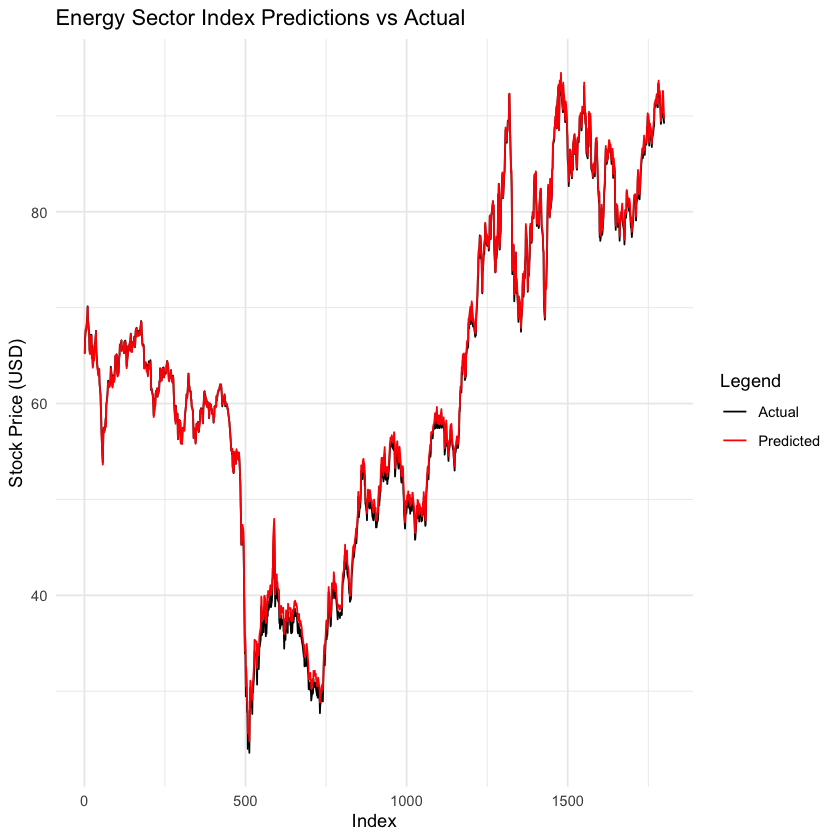

In [540]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Energy Sector Index Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **GDP**

In [541]:
# Lagged features to GDP Model

Normalizedlagged = lagfeatures(NormalizedColumns, "GDP", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Sequences

GDPTrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "GDP", sequence_length)
GDPTestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "GDP", sequence_length)
str(GDPTrainSequences)
str(GDPTestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.000618 0.000686 0.000755 0.000824 0.000892 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.623 0.624 0.624 0.624 0.624 ...


In [542]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_67"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_67 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_67 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [544]:
# Training, Evaluation & Predictions

history = model %>% fit(
  x = GDPTrainSequences$x, 
  y = GDPTrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = GDPTestSequences$x,
  y = GDPTestSequences$y
)

print(results)

$loss
[1] 0.0005945606

$mean_absolute_error
[1] 0.02028712



In [545]:
# Denormalization for visualization

min_price = min(MergedData$GDP, na.rm = TRUE)
max_price = max(MergedData$GDP, na.rm = TRUE)

# Predictions

predictions = model %>% predict(GDPTestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(GDPTestSequences$y, min_price, max_price)

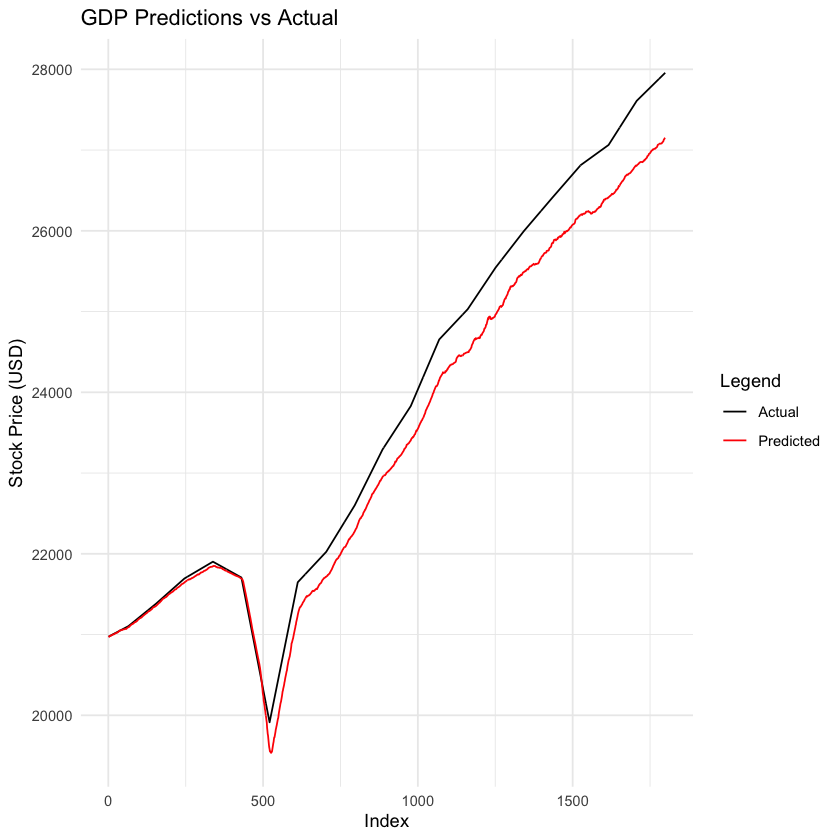

In [546]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "GDP Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Unemployment Rate**

In [547]:
# Lagged features to Unemployment Rate model

Normalizedlagged = lagfeatures(NormalizedColumns, "UNRATE", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

UNRATETrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "UNRATE", sequence_length)
UNRATETestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "UNRATE", sequence_length)
str(UNRATETrainSequences)
str(UNRATETestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:17] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.0823 0.0826 0.0829 0.0832 0.0835 ...
List of 2
 $ x: num [1:1799, 1:10, 1:17] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.0351 0.0351 0.0351 0.0351 0.0354 ...


In [548]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_68"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                    │ (None, 50)               │        13,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_68 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 13,651 (53.32 KB)
 Trainable params: 13,651 (53.32 KB)
 Non-trainable params: 0 (0.00 B)


In [549]:
# Training, Evaluation & Result

history = model %>% fit(
  x = UNRATETrainSequences$x, 
  y = UNRATETrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = UNRATETestSequences$x,
  y = UNRATETestSequences$y
)

print(results)

$loss
[1] 8.883823e-05

$mean_absolute_error
[1] 0.004068905



In [550]:
# Denormalization for visualization

min_price = min(MergedData$UNRATE, na.rm = TRUE)
max_price = max(MergedData$UNRATE, na.rm = TRUE)

# Predictions

predictions = model %>% predict(UNRATETestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(UNRATETestSequences$y, min_price, max_price)

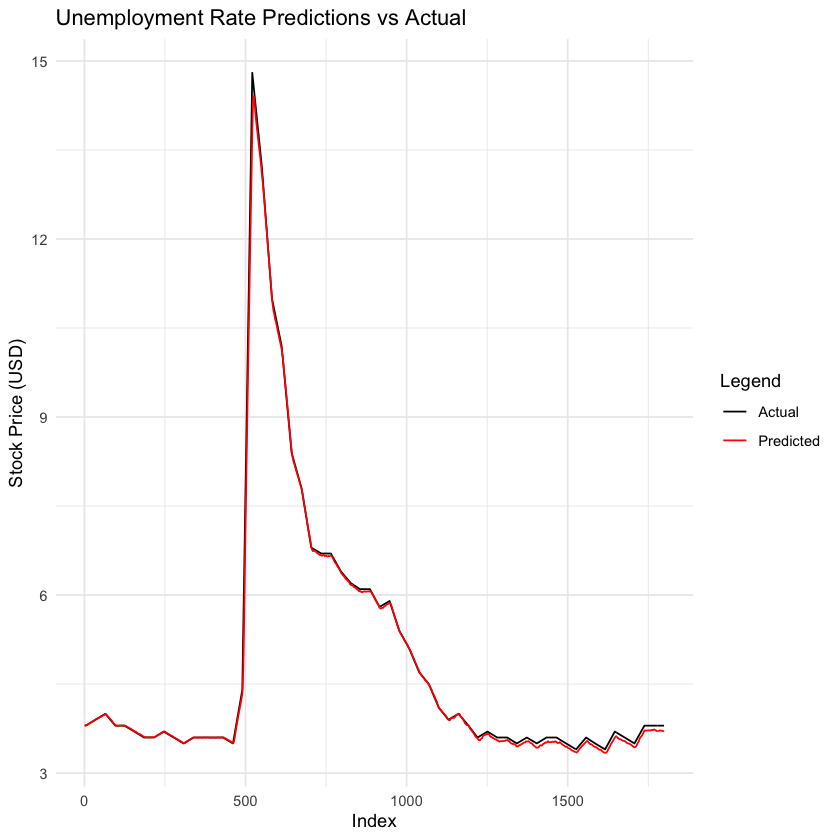

In [551]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "Unemployment Rate Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **SP500**

In [552]:
# Lagged features to model

Normalizedlagged = lagfeatures(Normalizedlagged, "GSPC.Close", lags)
any(is.na(Normalizedlagged))

Normalizedlagged = as.data.frame(lapply(Normalizedlagged, na.fill, fill = "extend"))
any(is.na(Normalizedlagged))

# Sequences

SP500TrainSequences = create_sequences(Normalizedlagged[1:train_len, ], "GSPC.Close", sequence_length)
SP500TestSequences = create_sequences(Normalizedlagged[(train_len + 1):nrow(Normalizedlagged), ], "GSPC.Close", sequence_length)
str(SP500TrainSequences)
str(SP500TestSequences)

[1] TRUE

[1] FALSE

List of 2
 $ x: num [1:7220, 1:10, 1:22] 0.000683 0.000777 0.000706 0.000854 0.000854 ...
 $ y: num [1:7220, 1] 0.135 0.13 0.138 0.138 0.139 ...
List of 2
 $ x: num [1:1799, 1:10, 1:22] 0.279 0.279 0.28 0.283 0.273 ...
 $ y: num [1:1799, 1] 0.477 0.487 0.494 0.501 0.497 ...


In [553]:
# Model

model = keras_model_sequential() %>%
  layer_lstm(units = 50, input_shape = c(sequence_length, ncol(Normalizedlagged)), return_sequences = FALSE) %>%
  layer_dense(units = 1)

model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(),
  metrics = c("mean_absolute_error")
)

summary(model)

Model: "sequential_69"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                    │ (None, 50)               │        14,600 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_69 (Dense)                  │ (None, 1)                │            51 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 14,651 (57.23 KB)
 Trainable params: 14,651 (57.23 KB)
 Non-trainable params: 0 (0.00 B)


In [555]:
# Training, Evaluation & Result

history = model %>% fit(
  x = SP500TrainSequences$x, 
  y = SP500TrainSequences$y,
  epochs = 100, 
  batch_size = 64
)

# Evaluate the model
results = model %>% evaluate(
  x = SP500TestSequences$x,
  y = SP500TestSequences$y
)

print(results)

$loss
[1] 1.07644e-05

$mean_absolute_error
[1] 0.002600507



In [556]:
# Denormalization for visualization

min_price = min(MergedData$GSPC.Close, na.rm = TRUE)
max_price = max(MergedData$GSPC.Close, na.rm = TRUE)

# Predictions

predictions = model %>% predict(SP500TestSequences$x)

denormalized_predictions = denormalize(predictions, min_price, max_price)
denormalized_actuals = denormalize(SP500TestSequences$y, min_price, max_price)

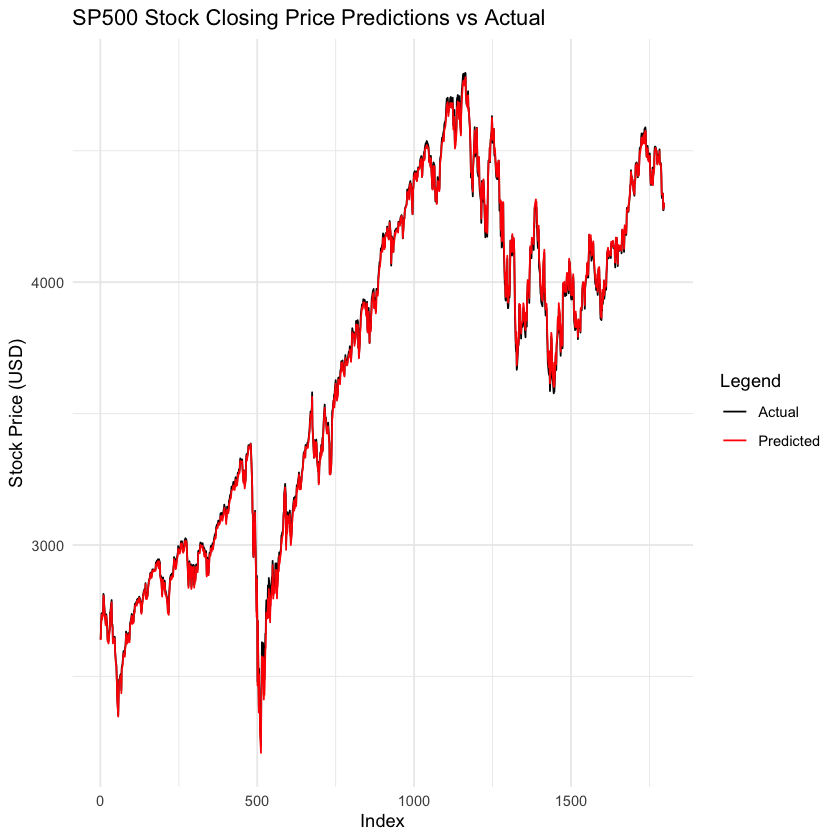

In [557]:
# Visualization of the results of the model

plot_data = data.frame(
  Index = 1:length(denormalized_actuals),
  Actual = denormalized_actuals,
  Predicted = denormalized_predictions
)

ggplot(plot_data, aes(x = Index)) +
  geom_line(aes(y = Actual, color = "Actual")) +
  geom_line(aes(y = Predicted, color = "Predicted")) +
  labs(title = "SP500 Stock Closing Price Predictions vs Actual",
       x = "Index",
       y = "Stock Price (USD)") +
  scale_color_manual(name = "Legend", values = c("Actual" = "Black", "Predicted" = "red")) +
  theme_minimal()

# **Results**

With all models Loss (MSE) and Mean Absolute Error (MAE) are extremely low, indicating great model fit. All Stocks and Sectors had Mae <0.01. This indicates that, on average, the absolute error between your model's predictions and the actual values is less than 1% of the range of the normalized data, meaning very precise predictions.

For Market Indices, the Unemployment Rate and SP500 MAE are <0.01 and for GDP approx. 0.02. Of all considered variables GDP had the highest MAE. For GDP, on average, the absolute error between your model's predictions and the actual values is around 2% which is considered a great result.

Visualization of Actual / Predicted values presents the accuracy of each model on test data.
